In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')
sns.set_context("talk")

In [3]:
from src.load_data import load_data
from src.parameters import EDGE_ORDER, EDGE_SPACING

epoch_key = 'Jaq', 3, 12 # animal, day, epoch

data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

14-Dec-20 14:28:21 Loading position info...
14-Dec-20 14:28:53 Loading multiunit...
14-Dec-20 14:29:17 Loading spikes...
14-Dec-20 14:30:40 Finding ripple times...


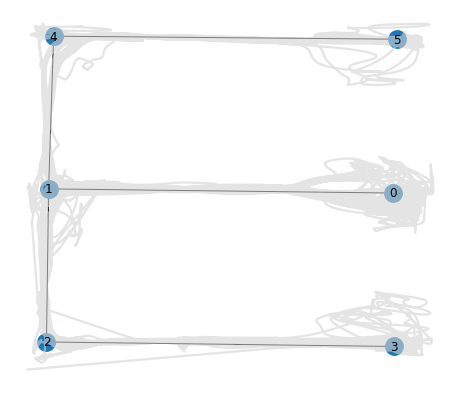

In [4]:
from track_linearization import plot_track_graph

plt.figure(figsize=(8, 7))
plt.plot(data['position_info'].nose_x, data['position_info'].nose_y, color='lightgrey', alpha=0.6)
plot_track_graph(data['track_graph'])
sns.despine(bottom=True, left=True)

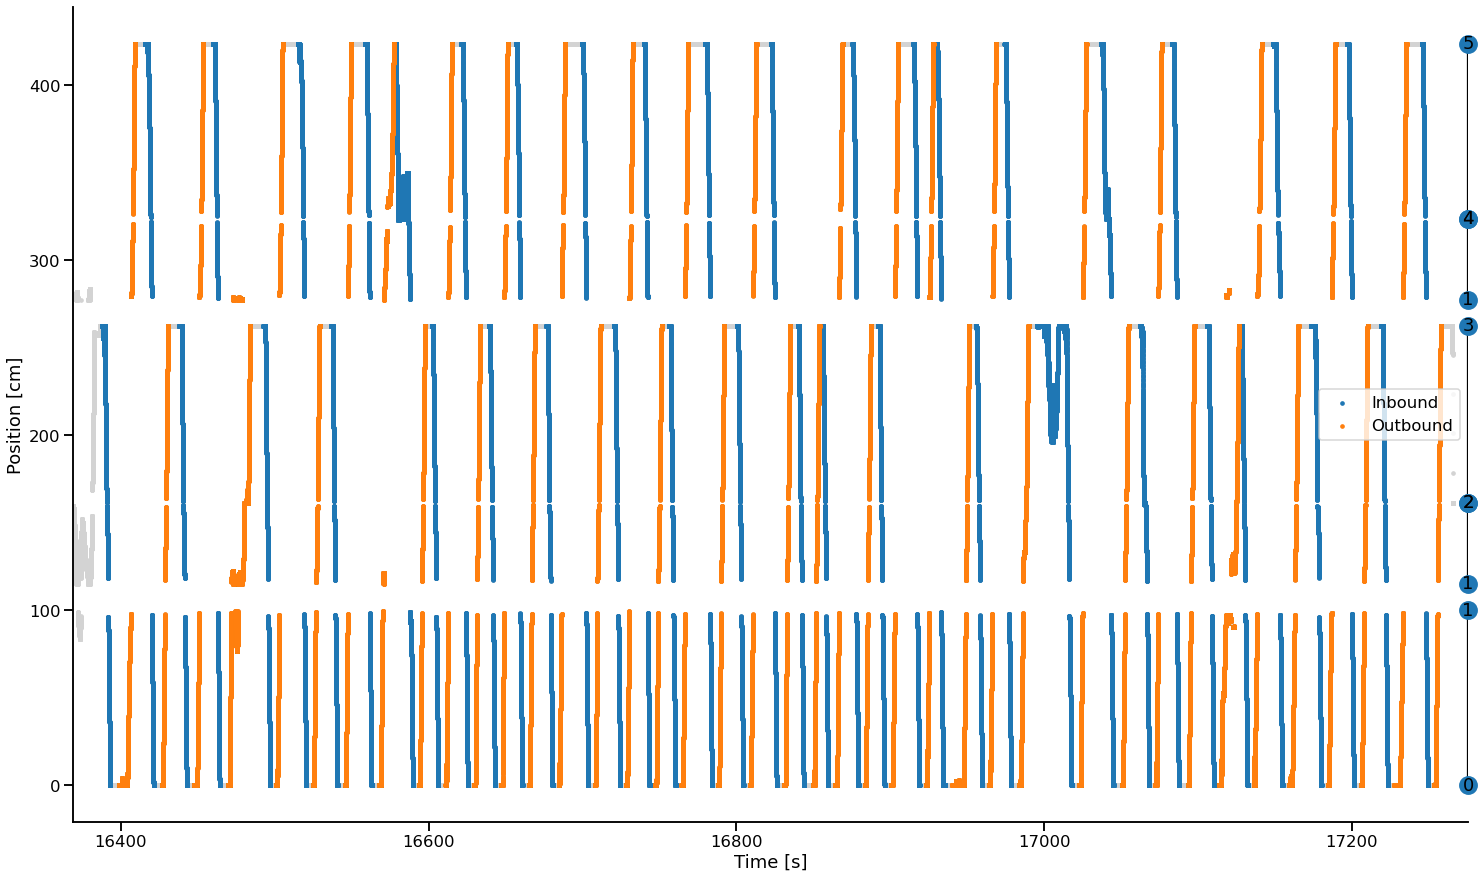

In [5]:
from track_linearization import plot_graph_as_1D

plt.figure(figsize=(25, 15))

time = data['position_info'].index / np.timedelta64(1, 's')
plt.scatter(time,
            data['position_info'].linear_position, color='lightgrey', s=10)

for name, df in data['position_info'].groupby('task'):
    plt.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=10, label=name)

plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=10.0 + time[-1])

plt.legend()
plt.ylabel('Position [cm]')
plt.xlabel('Time [s]')
plt.xlim((time[0], time[-1] + 10.0))

sns.despine()

In [6]:
continuous_transition_types = (
    [['random_walk', 'uniform', 'random_walk', 'uniform'],
     ['uniform',     'uniform', 'uniform',     'uniform'],
     ['random_walk', 'uniform', 'random_walk', 'uniform'],
     ['uniform',     'uniform', 'uniform',     'uniform']])

encoding_group_to_state = ['Inbound', 'Inbound', 'Outbound', 'Outbound']


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])}, 
}

In [7]:
from replay_trajectory_classification import ClusterlessClassifier

classifier = ClusterlessClassifier(**classifier_parameters)

In [8]:
data["position_info"].task.unique()

array([nan, 'Inbound', 'Outbound'], dtype=object)

In [9]:
data["position_info"].task.value_counts()

Outbound    111800
Inbound     107627
Name: task, dtype: int64

In [10]:
data["position_info"].shape

(448257, 36)

In [11]:
import pandas as pd

inbound_outbound_labels = np.asarray(data["position_info"].task).astype(str)

is_running = (np.abs(data["position_info"].nose_vel) > 4) & pd.notnull(data["position_info"].task)

classifier.fit(
    position=data["position_info"].linear_position,
    multiunits=data["multiunits"],
    is_training=is_running,
    track_graph=data["track_graph"],
    edge_order=EDGE_ORDER,
    edge_spacing=EDGE_SPACING,
    encoding_group_labels=inbound_outbound_labels,
    encoding_group_to_state=encoding_group_to_state
)

14-Dec-20 14:31:49 Fitting initial conditions...
14-Dec-20 14:31:49 Fitting state transition...
14-Dec-20 14:31:51 Fitting multiunits...


ClusterlessClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                    'random_walk', 'uniform'],
                                                   ['uniform', 'uniform',
                                                    'uniform', 'uniform'],
                                                   ['random_walk', 'uniform',
                                                    'random_walk', 'uniform'],
                                                   ['uniform', 'uniform',
                                                    'uniform', 'uniform']],
                      discrete_transition_diag=0.968,
                      discrete_transition_type='strong_diagonal',
                      infer_track_interior=True,
                      initial_conditions_type='uniform_on_track',
                      model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      model_kwargs={'bandwidth': array([20., 20., 

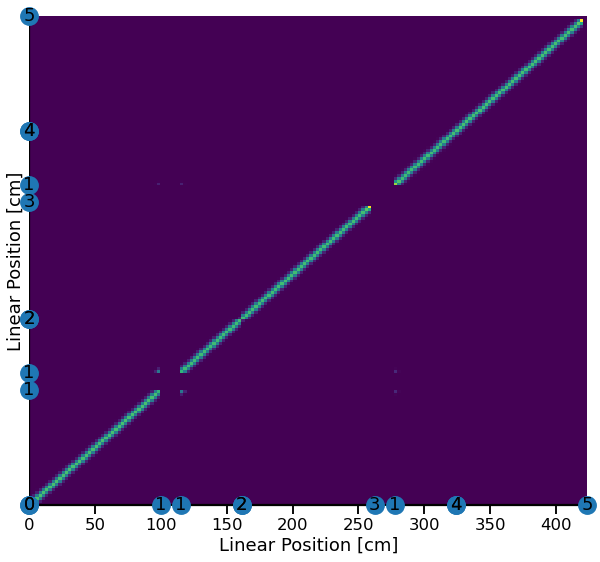

In [12]:
plt.figure(figsize=(10, 9))
plt.pcolormesh(classifier.edges_[0], classifier.edges_[0], classifier.continuous_state_transition_[0, 0].T)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='y', 
                 other_axis_start=0.0)
plot_graph_as_1D(data['track_graph'], edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING, axis='x', 
                 other_axis_start=0.0)

In [13]:
data['ripple_times']

,start_time,end_time,duration
replay_number,,,
1,0 days 04:33:14.317033333,0 days 04:33:14.370366666,0.053333
2,0 days 04:33:16.437033333,0 days 04:33:16.547699999,0.110667
3,0 days 04:33:30.252366666,0 days 04:33:30.301699999,0.049333
4,0 days 04:33:30.847699999,0 days 04:33:30.959699999,0.112000
5,0 days 04:33:32.775033333,0 days 04:33:32.845699999,0.070667
...,...,...,...
205,0 days 04:47:31.009033333,0 days 04:47:31.125033333,0.116000
206,0 days 04:47:32.435699999,0 days 04:47:32.514366666,0.078667
207,0 days 04:47:33.106366666,0 days 04:47:33.172366666,0.066000


In [14]:
from src.visualization import plot_classifier_inbound_outbound_time_slice


def plot_ripple_decode(data, classifier, ripple_number):
    start_time = data['ripple_times'].loc[ripple_number].start_time
    end_time = data['ripple_times'].loc[ripple_number].end_time

    results = classifier.predict(
        multiunits=data['multiunits'].sel(time=slice(start_time, end_time)),
        time=data['multiunits'].sel(time=slice(start_time, end_time)).time / np.timedelta64(1, 's'),
        state_names=['Inbound-Continuous', 'Inbound-Fragmented', 'Outbound-Continuous', 'Outbound-Fragmented']
        )
    time_slice = slice(start_time / np.timedelta64(1, 's'),
                       end_time / np.timedelta64(1, 's'))

    plot_classifier_inbound_outbound_time_slice(
        time_slice,
        classifier,
        results,
        data,
        posterior_type="acausal_posterior",
        figsize=(30, 15),
    )

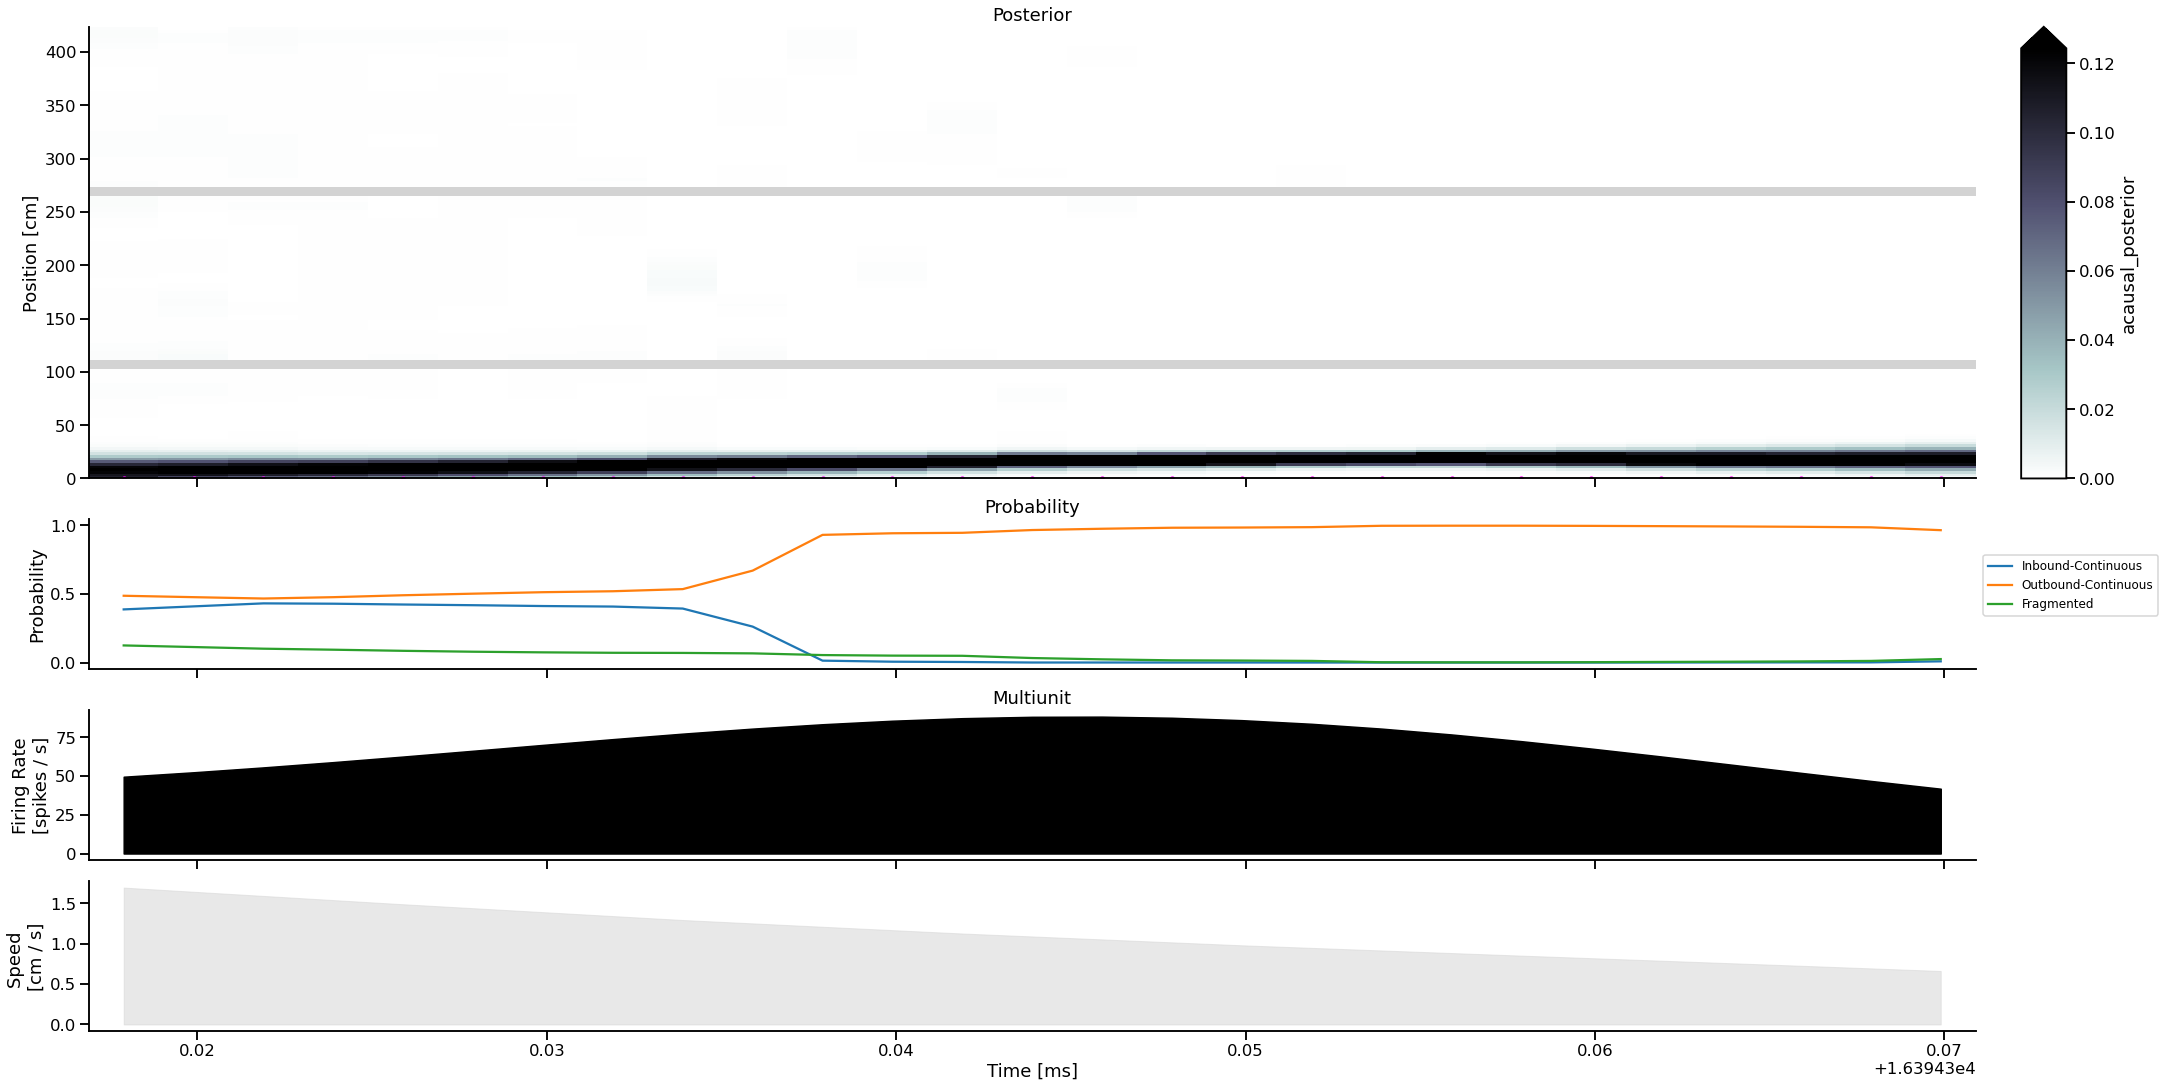

In [40]:
ripple_number = 1

plot_ripple_decode(data, classifier, ripple_number)

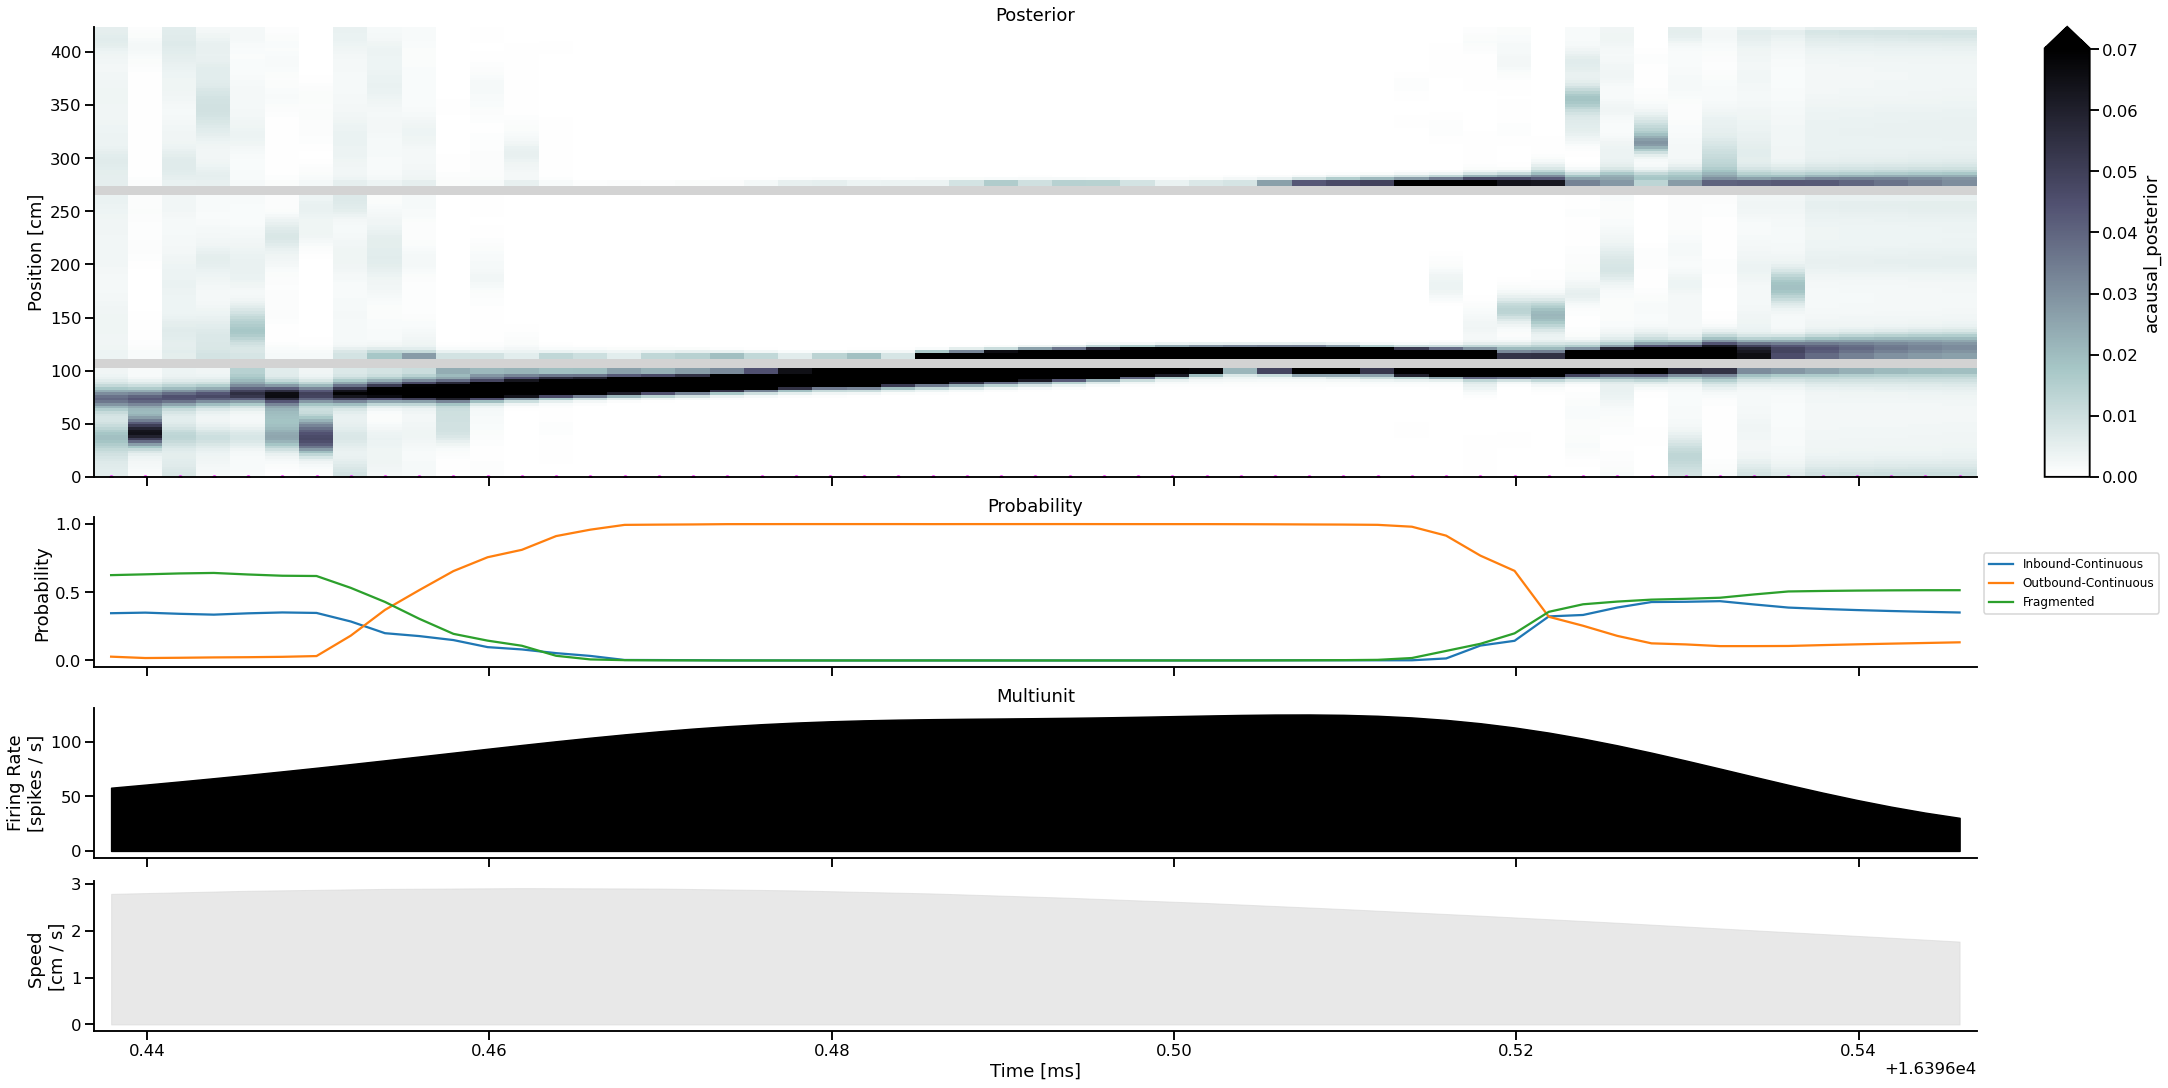

In [41]:
ripple_number = 2

plot_ripple_decode(data, classifier, ripple_number)

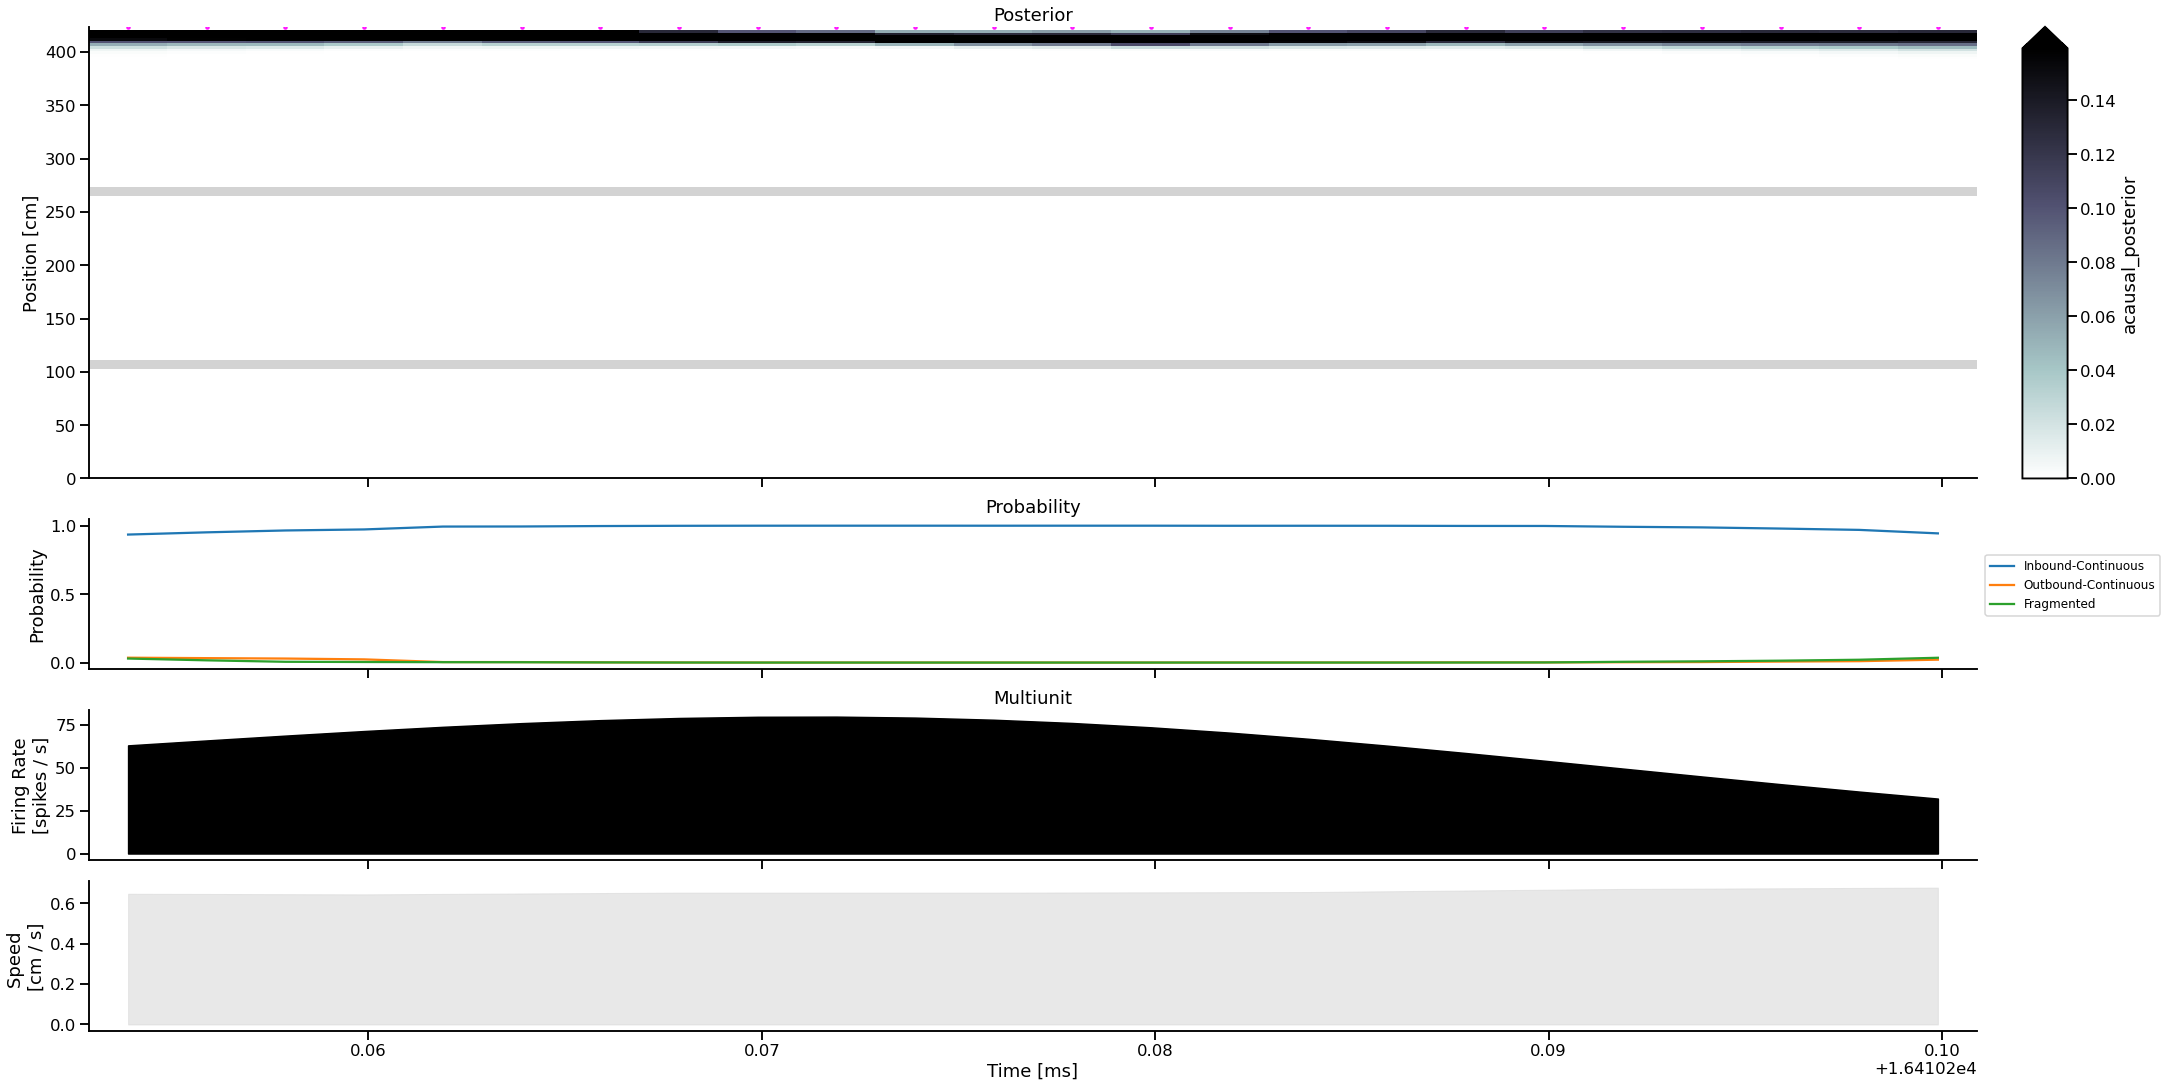

In [42]:
ripple_number = 3

plot_ripple_decode(data, classifier, ripple_number)

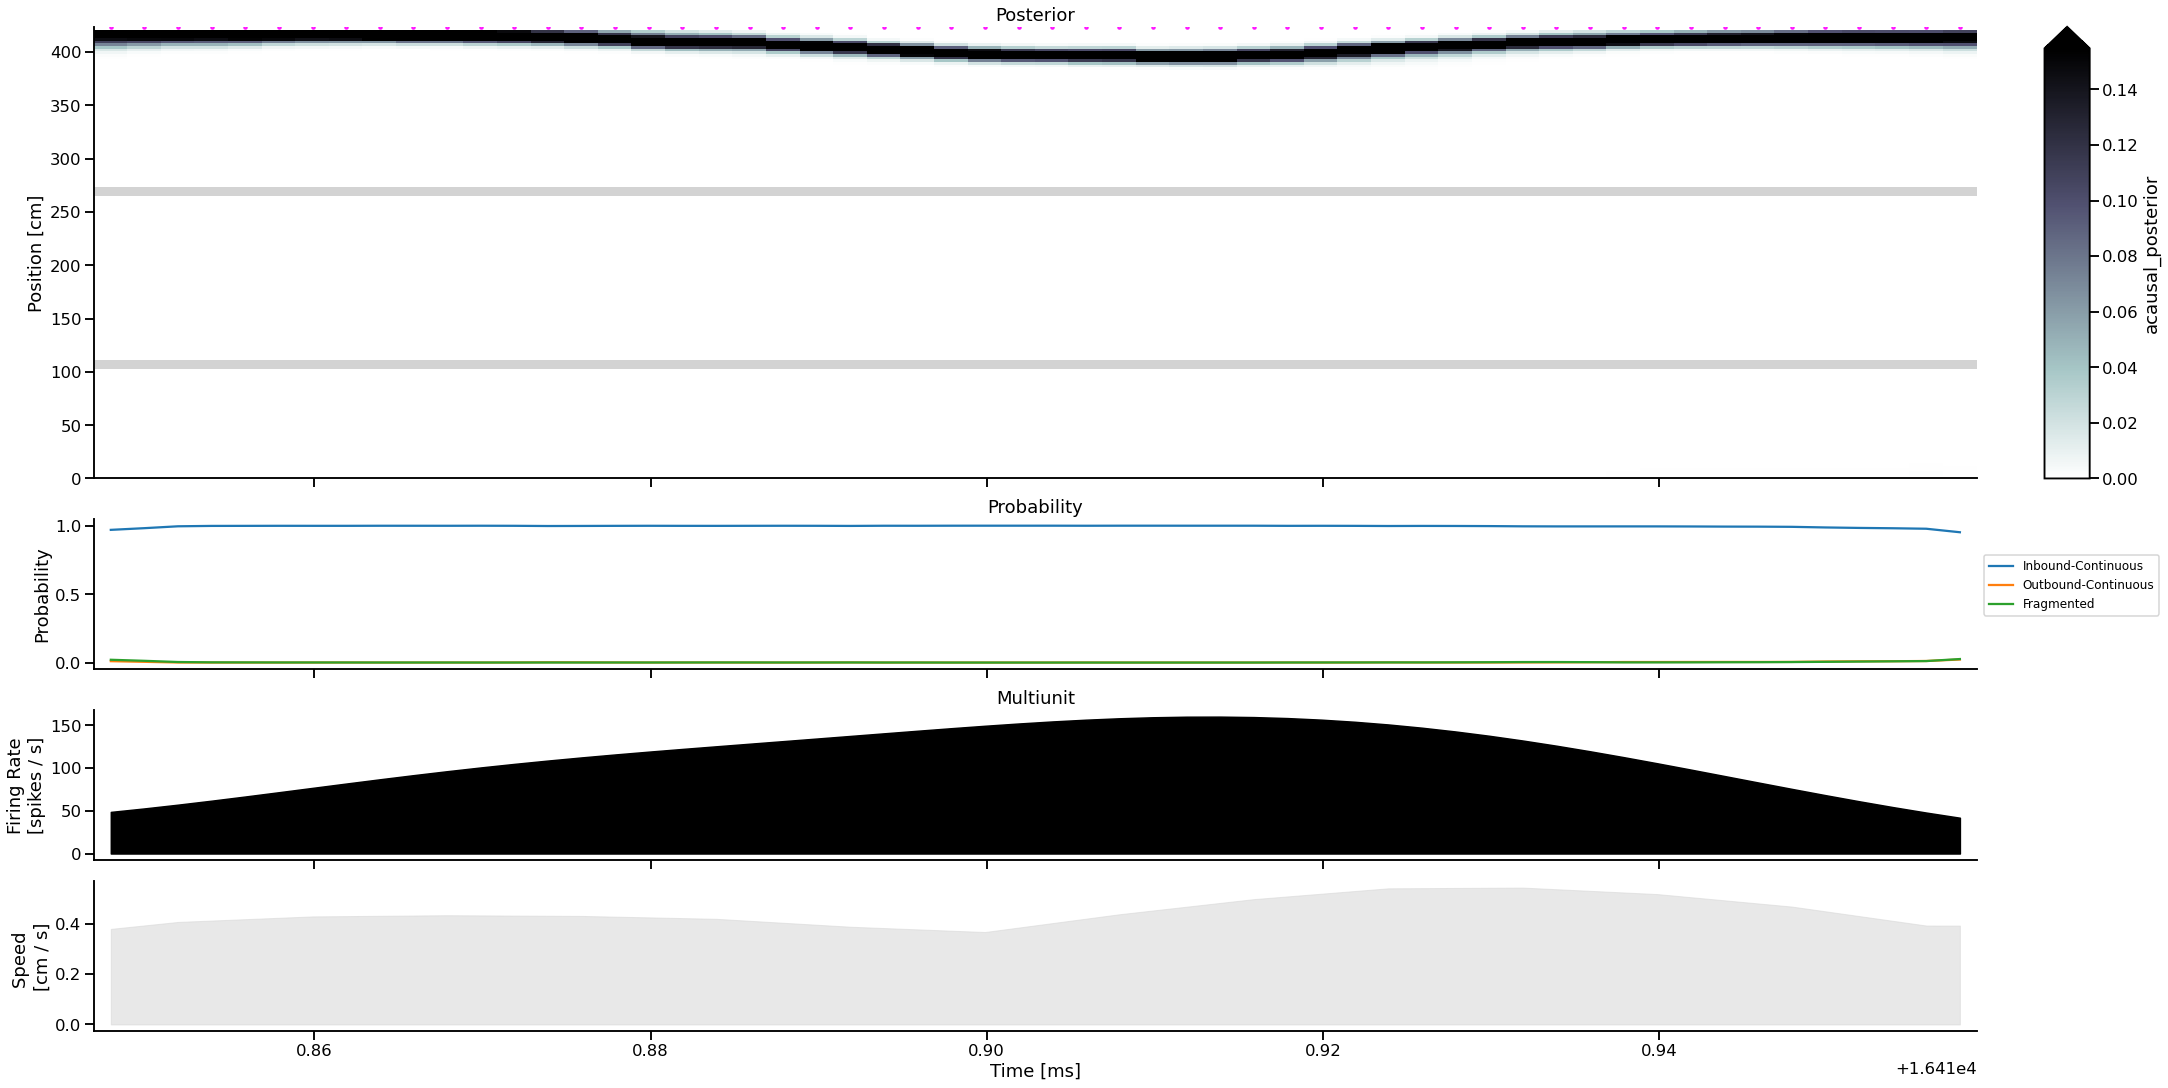

In [43]:
ripple_number = 4

plot_ripple_decode(data, classifier, ripple_number)

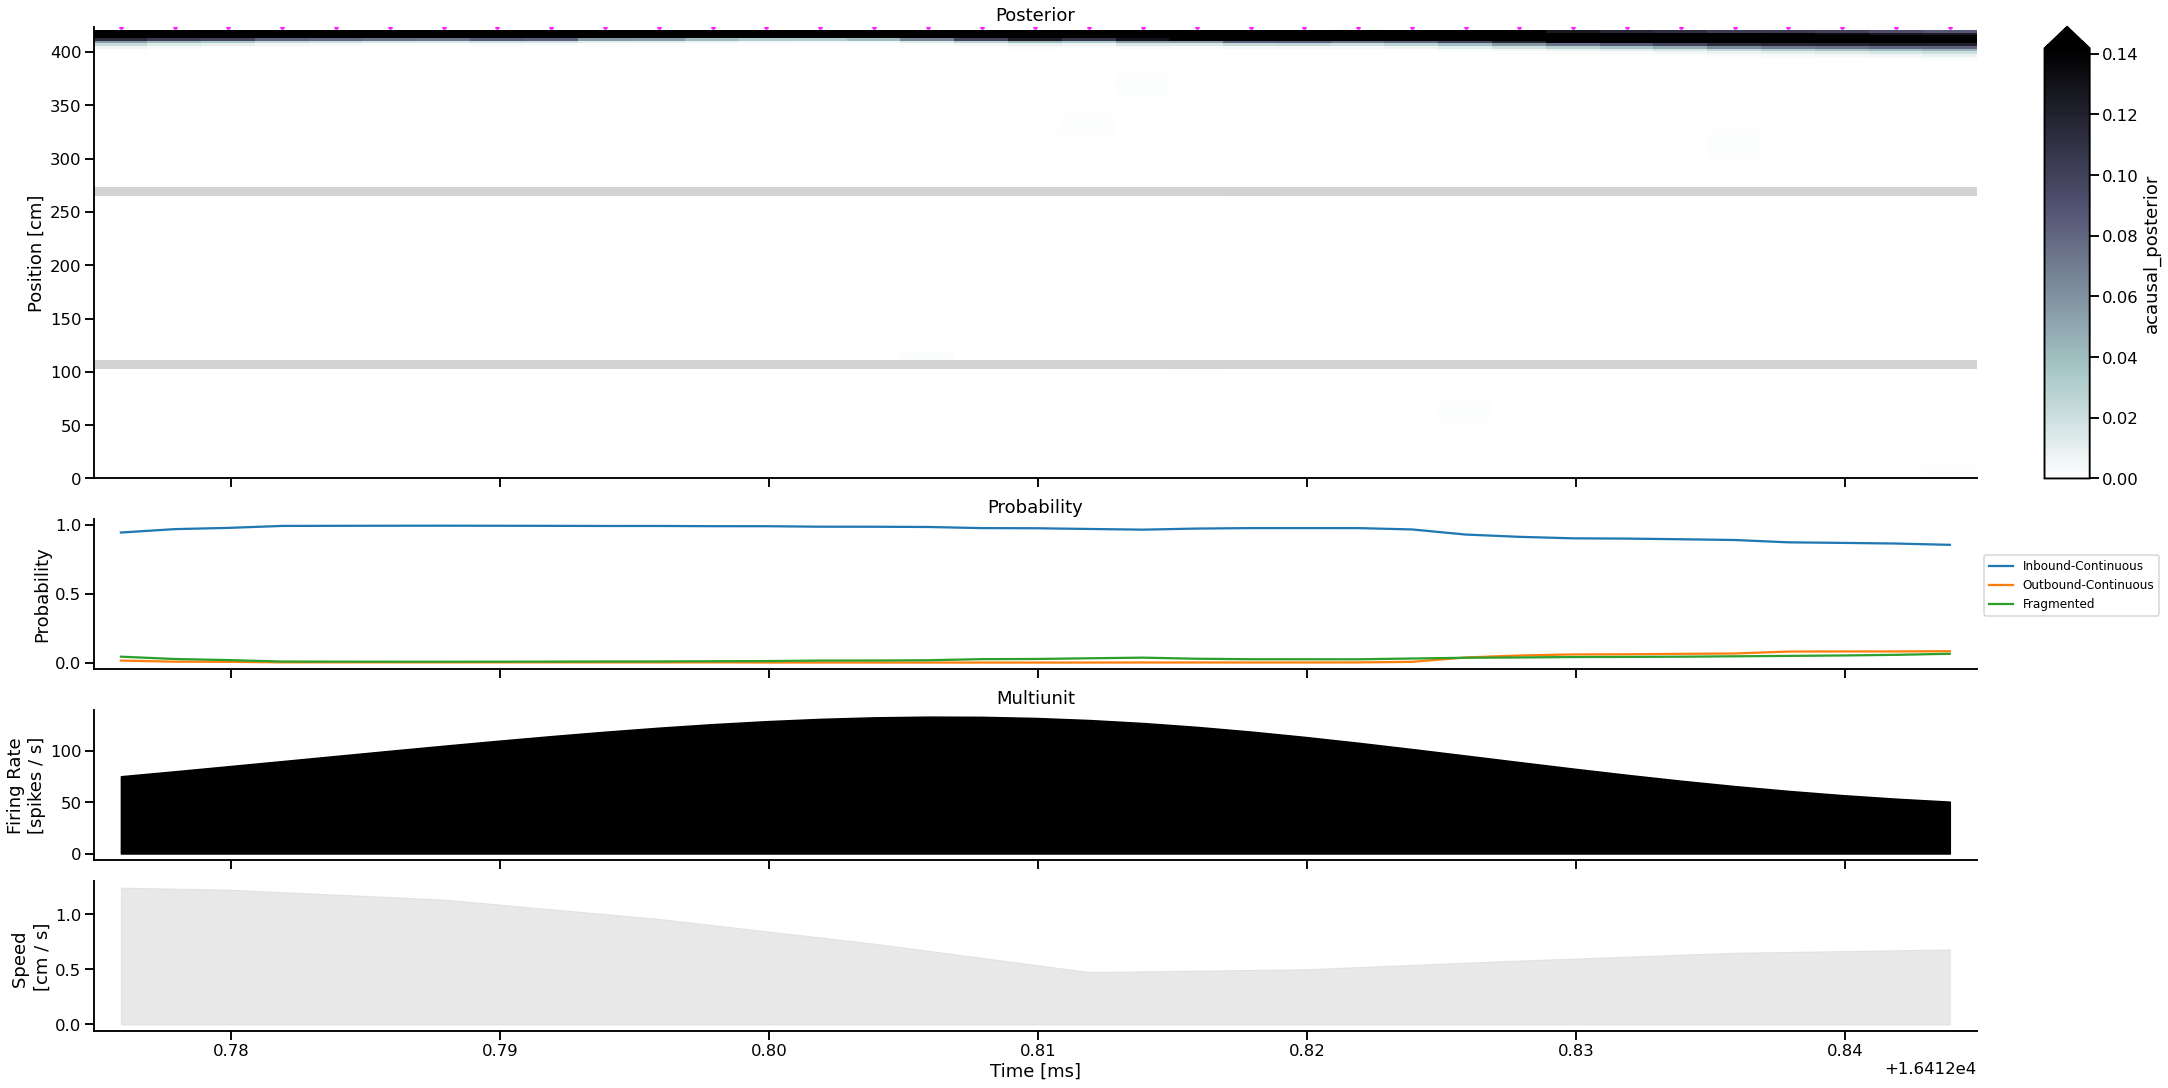

In [44]:
ripple_number = 5

plot_ripple_decode(data, classifier, ripple_number)

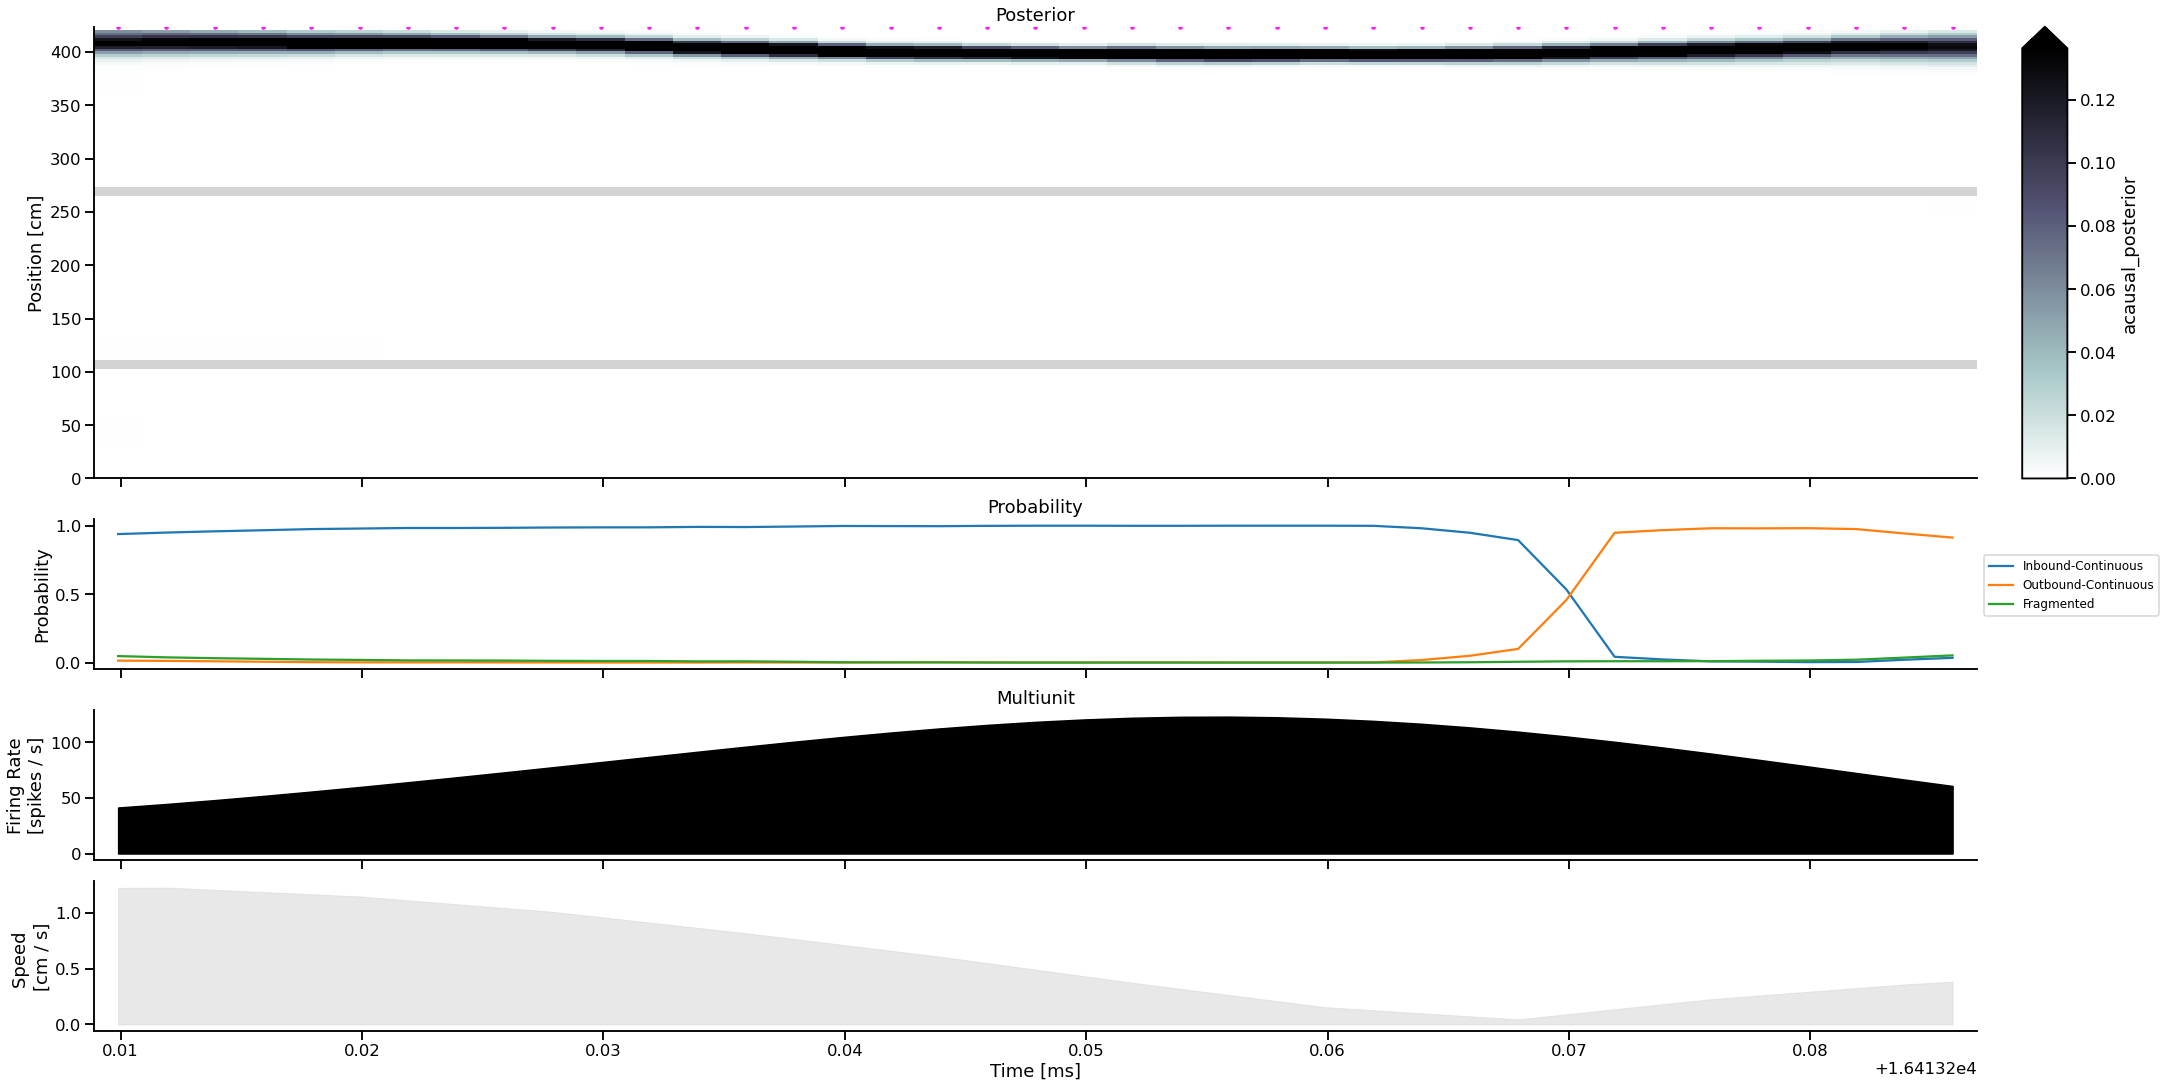

In [45]:
ripple_number = 6

plot_ripple_decode(data, classifier, ripple_number)

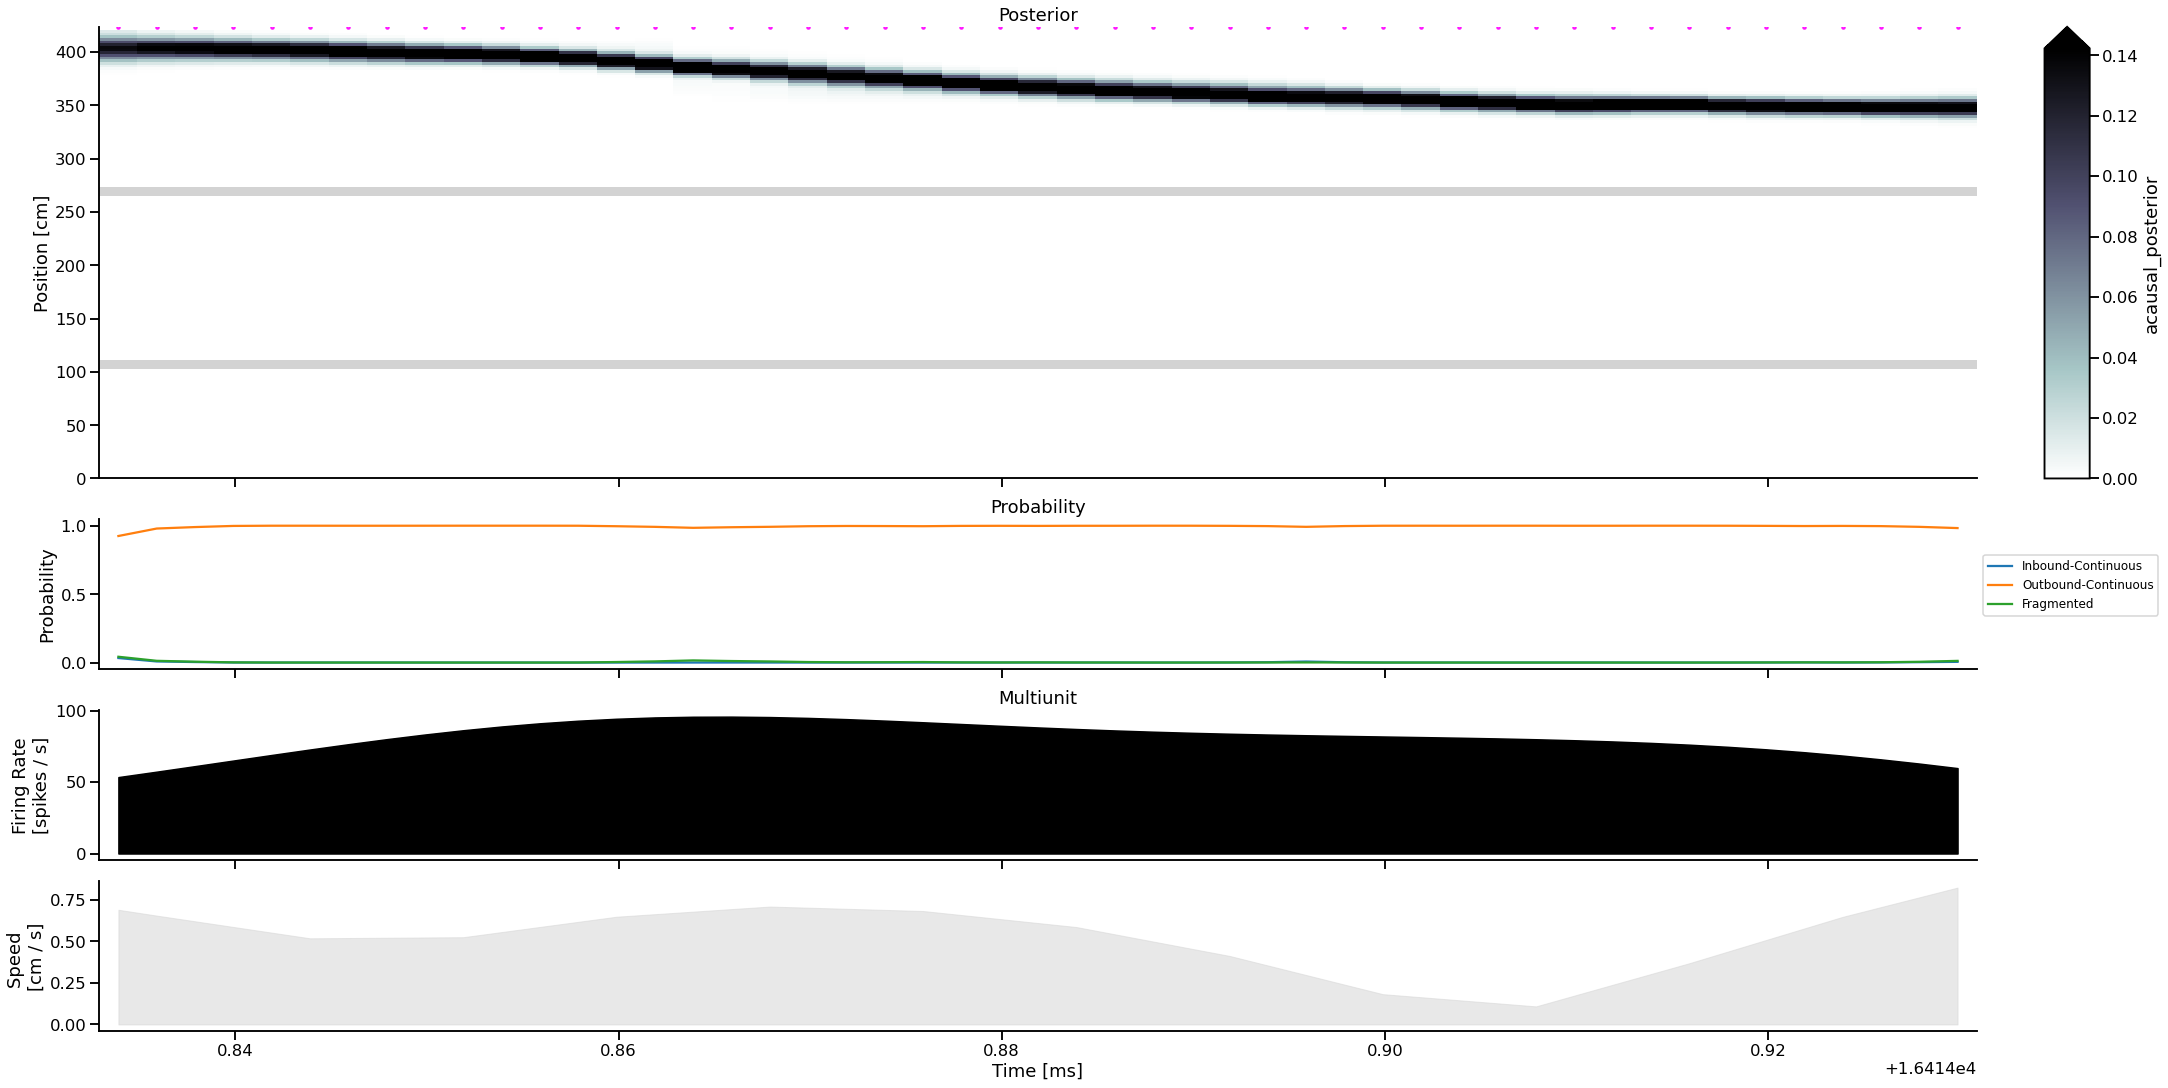

In [46]:
ripple_number = 7

plot_ripple_decode(data, classifier, ripple_number)

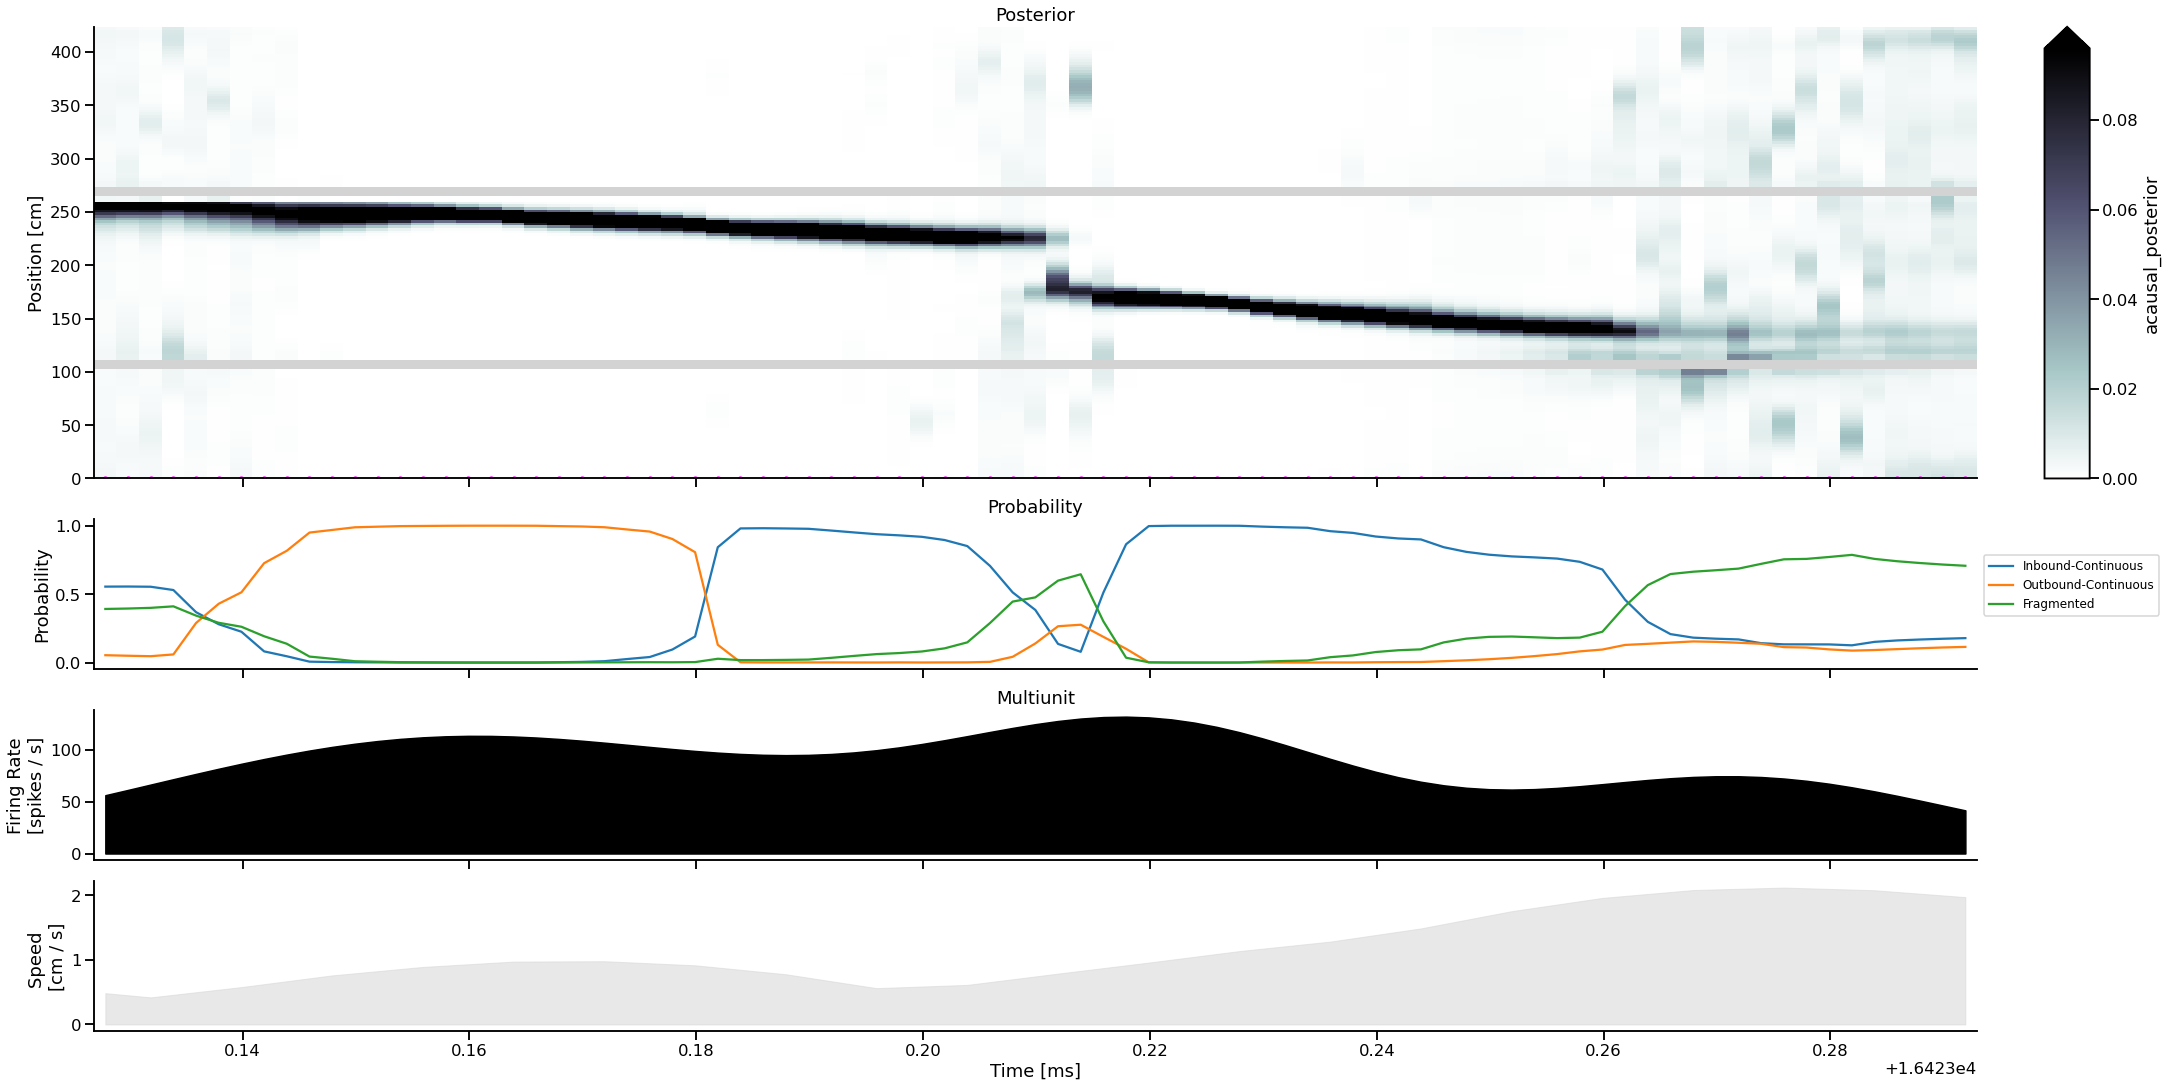

In [47]:
ripple_number = 8

plot_ripple_decode(data, classifier, ripple_number)

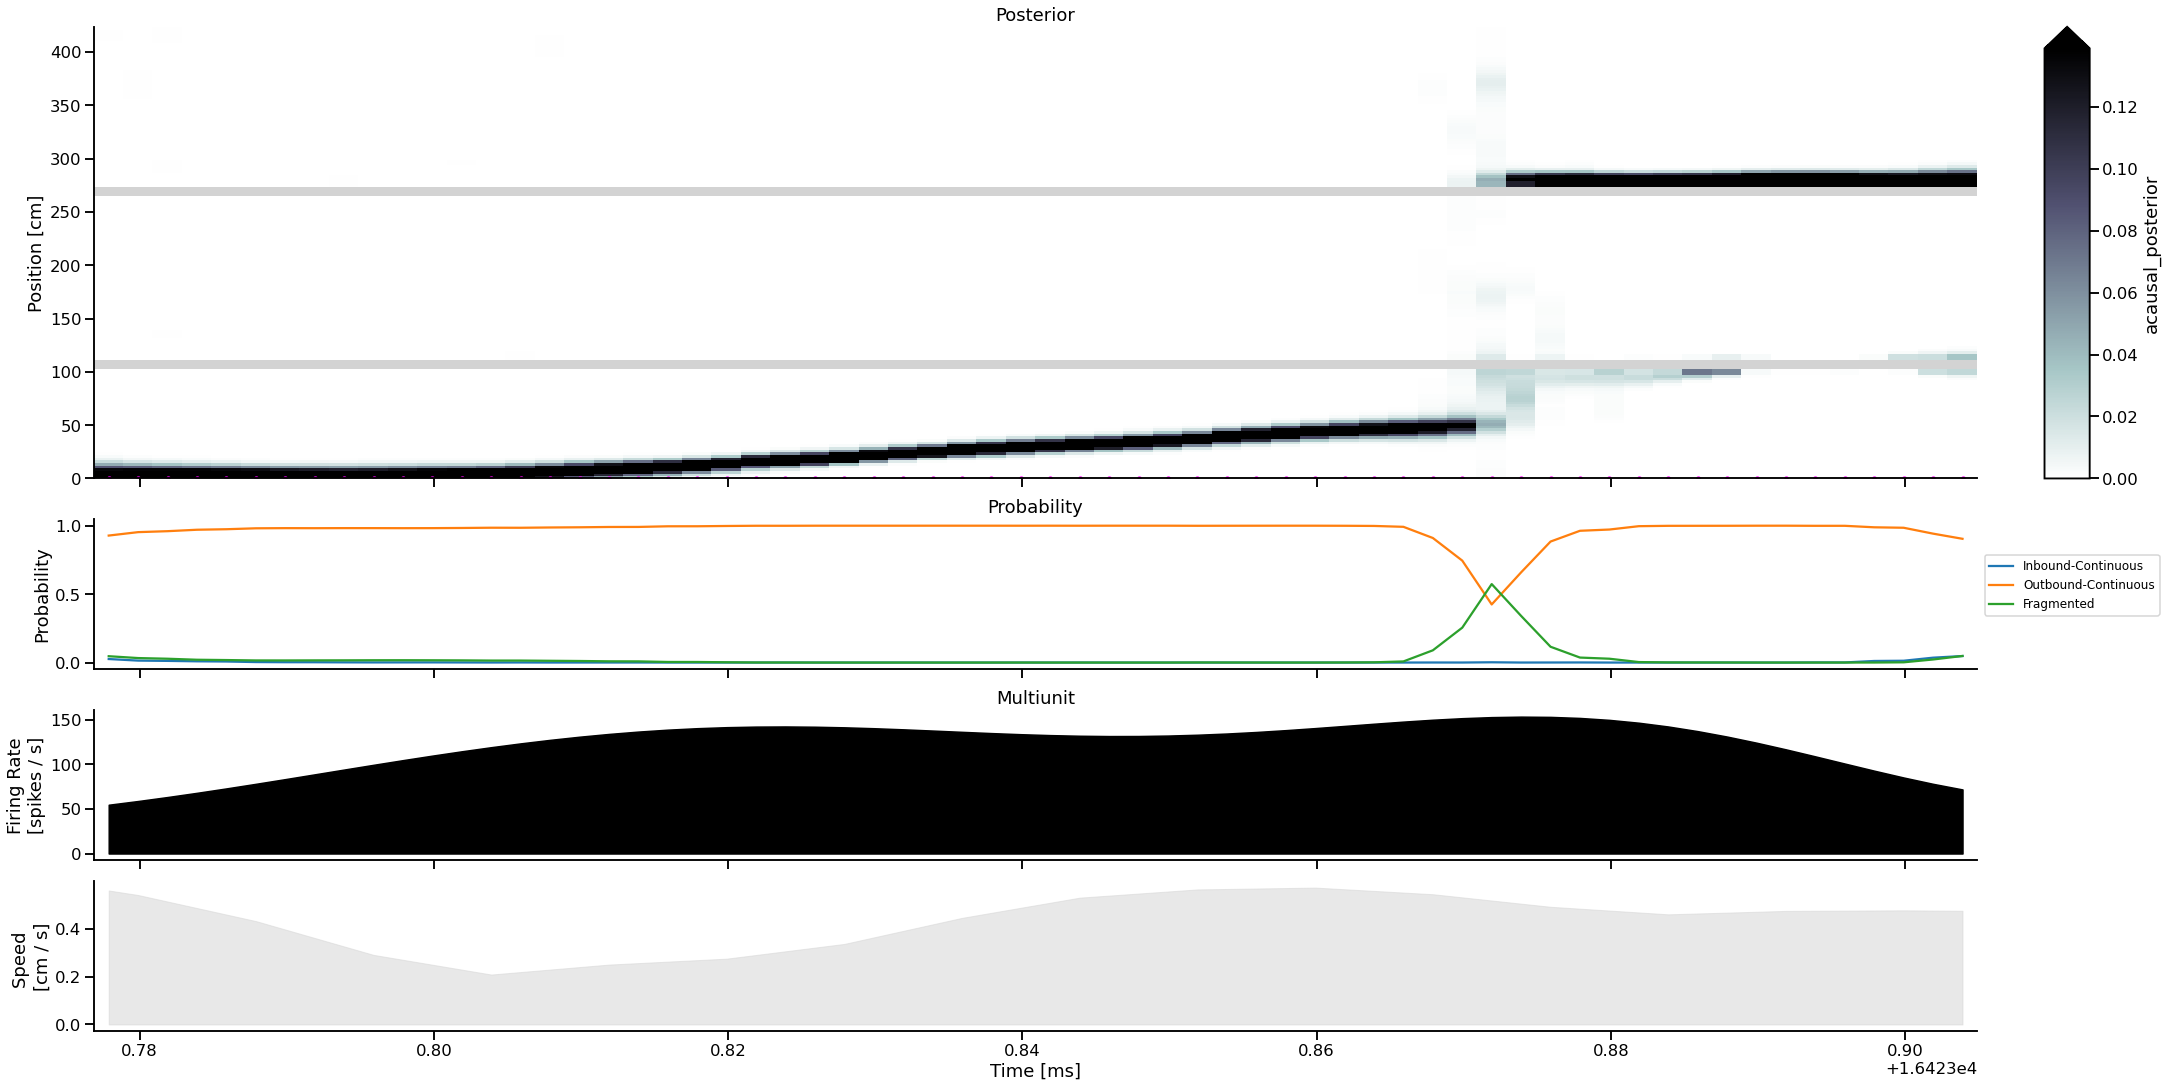

In [48]:
ripple_number = 9

plot_ripple_decode(data, classifier, ripple_number)

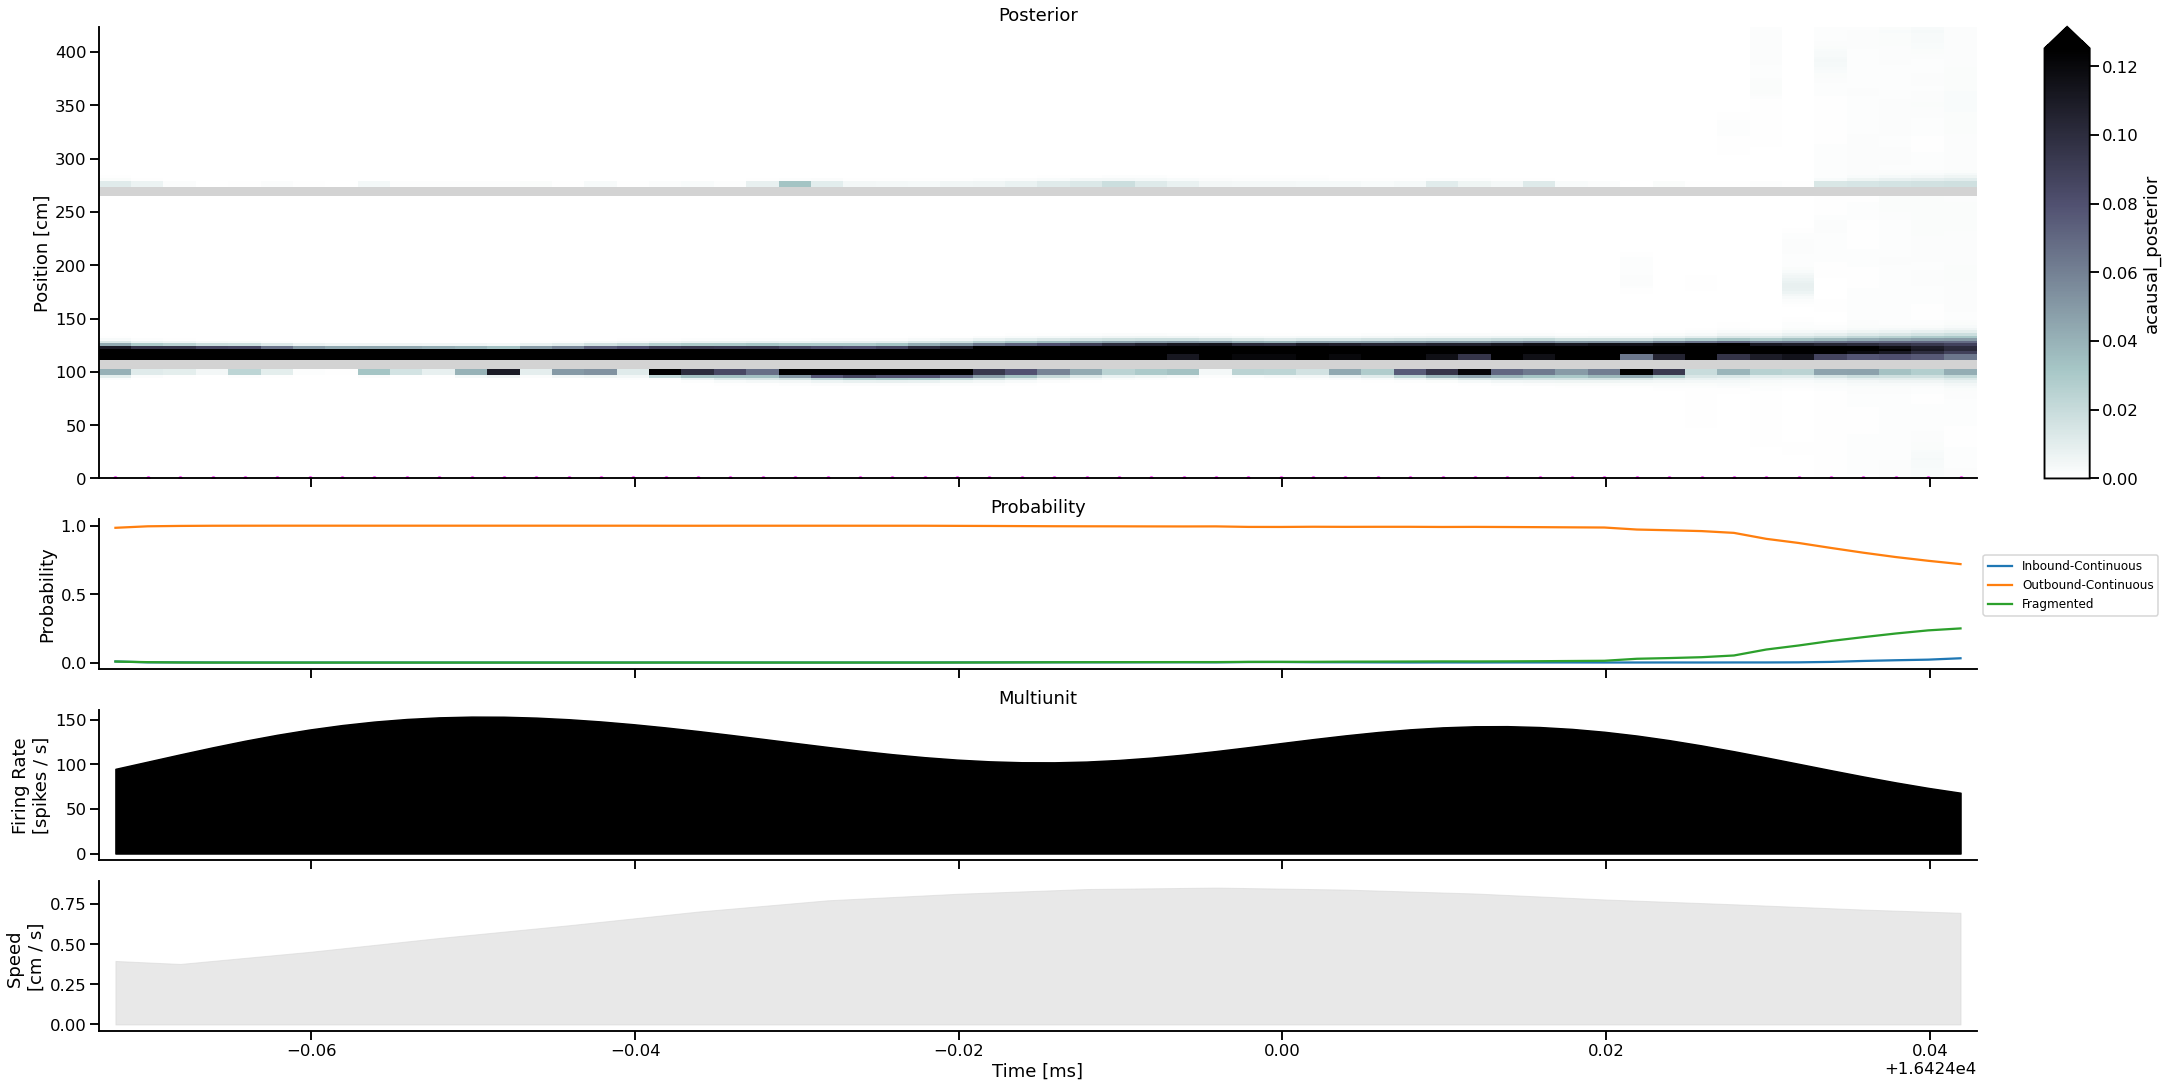

In [49]:
ripple_number = 10

plot_ripple_decode(data, classifier, ripple_number)

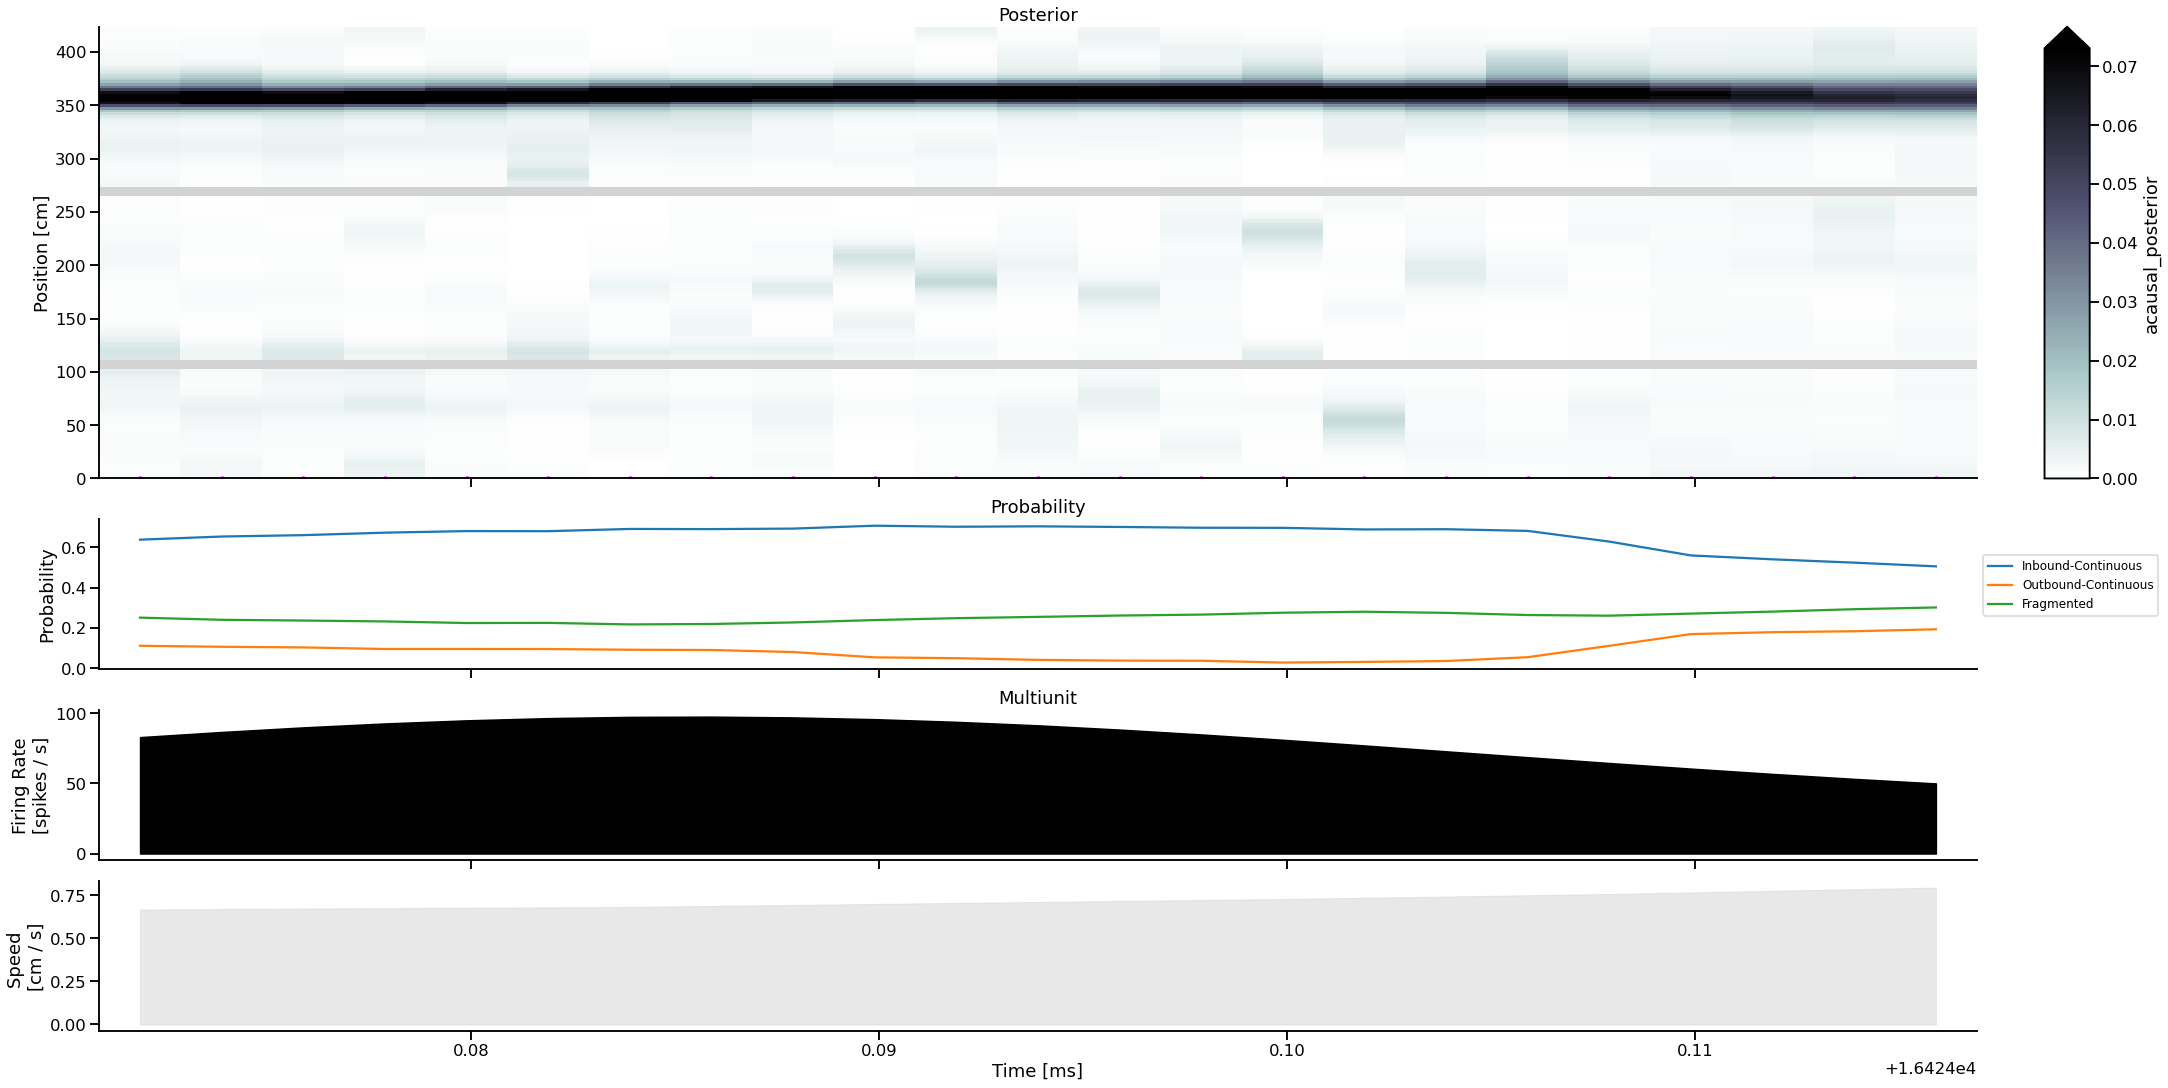

In [50]:
ripple_number = 11

plot_ripple_decode(data, classifier, ripple_number)

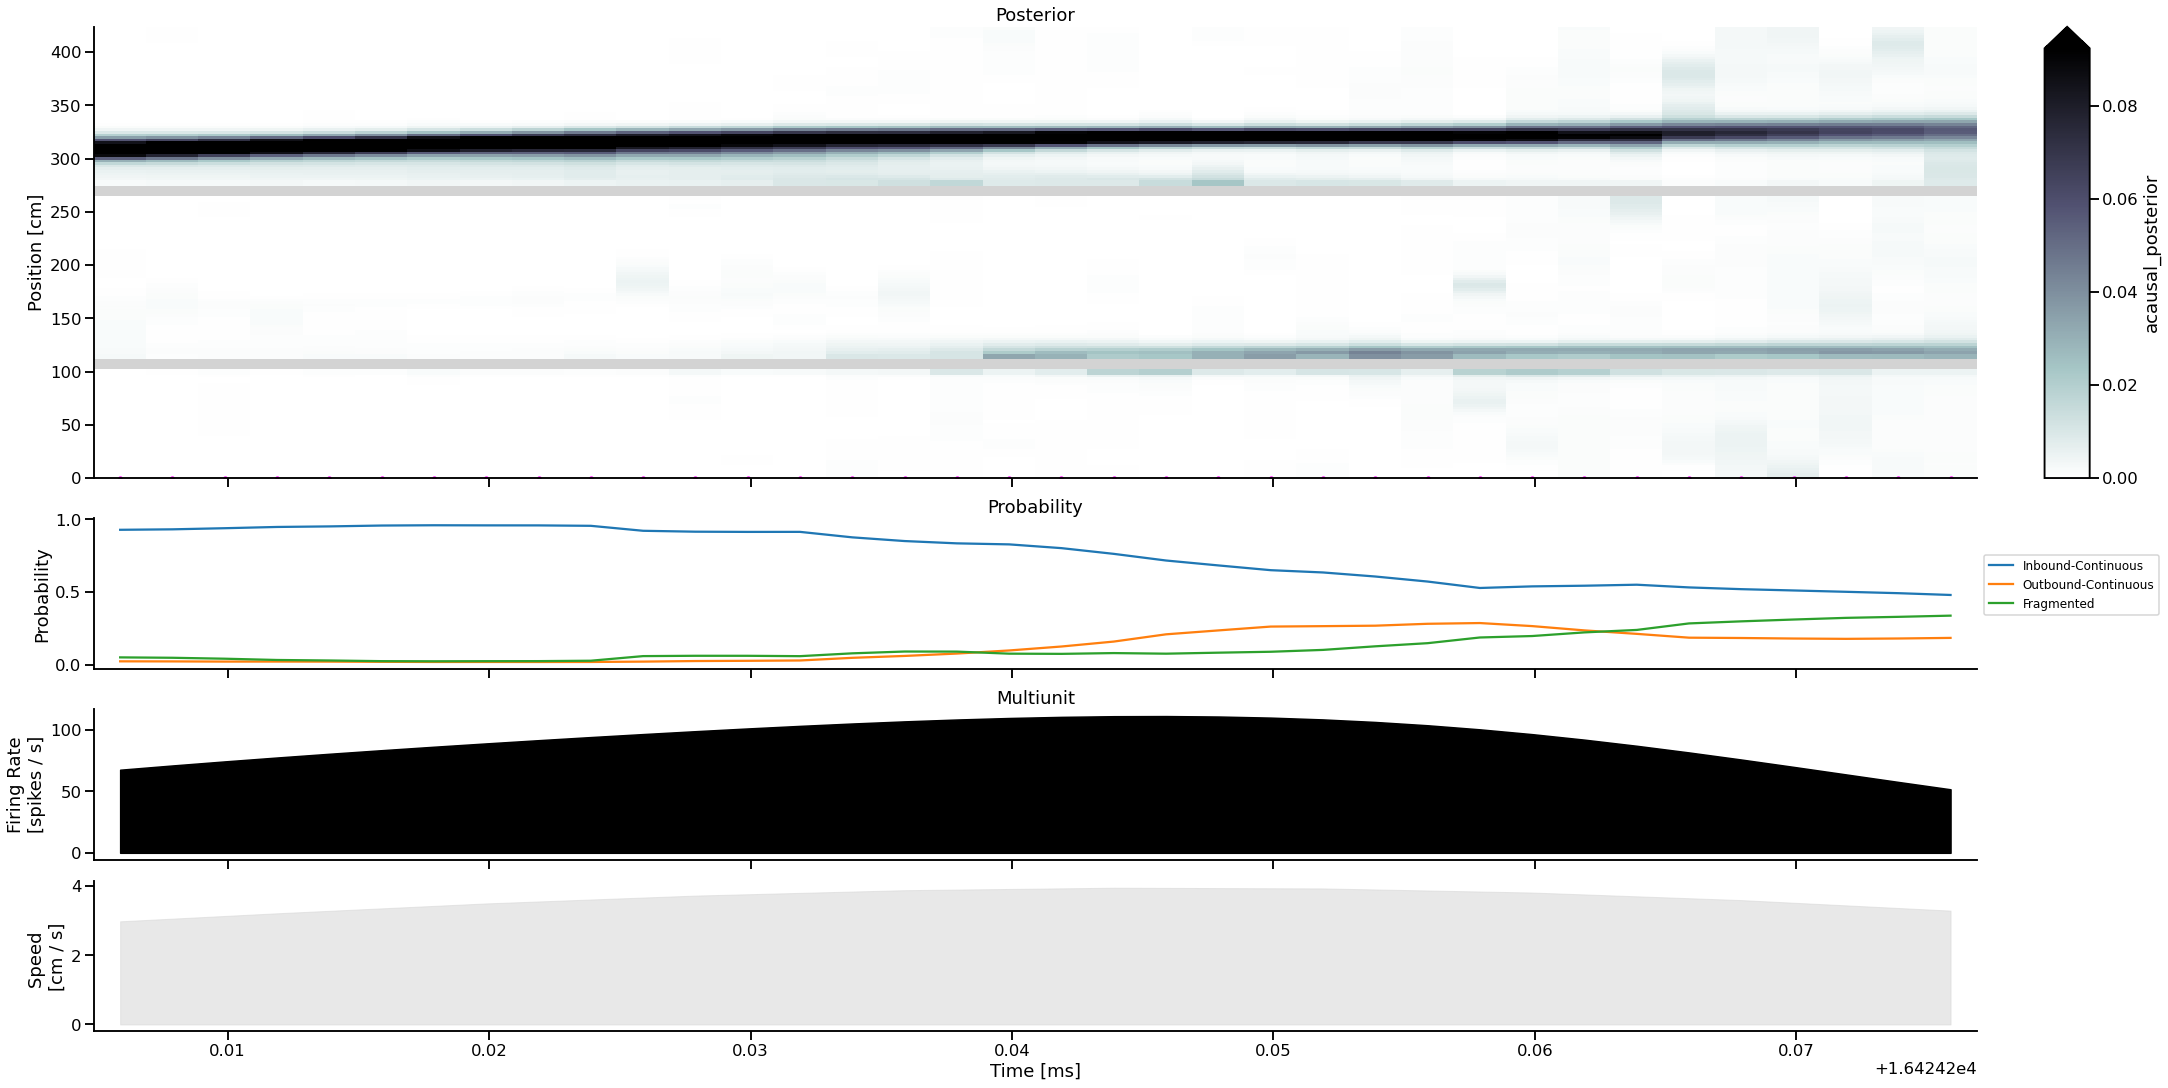

In [51]:
ripple_number = 12

plot_ripple_decode(data, classifier, ripple_number)

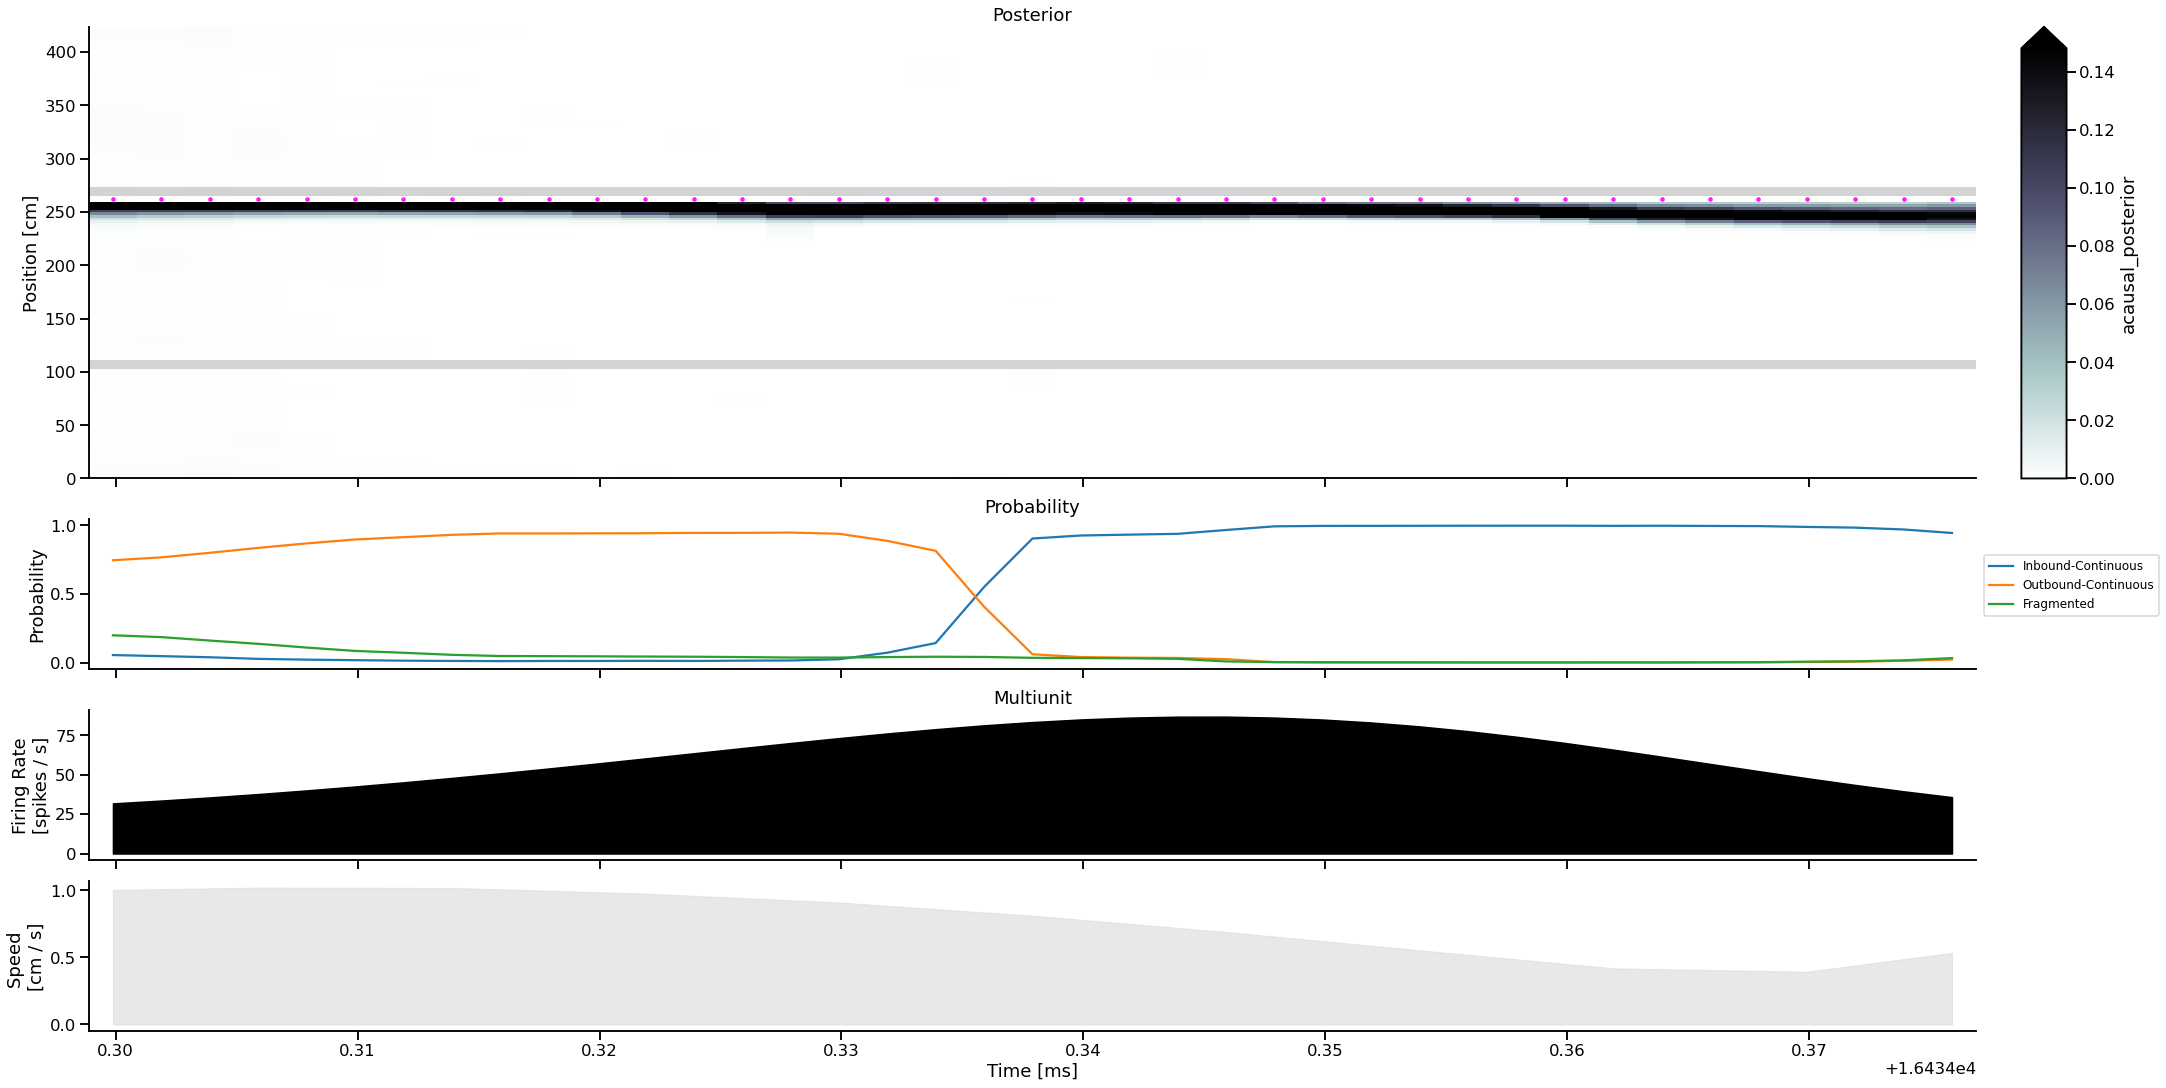

In [52]:
ripple_number = 13

plot_ripple_decode(data, classifier, ripple_number)

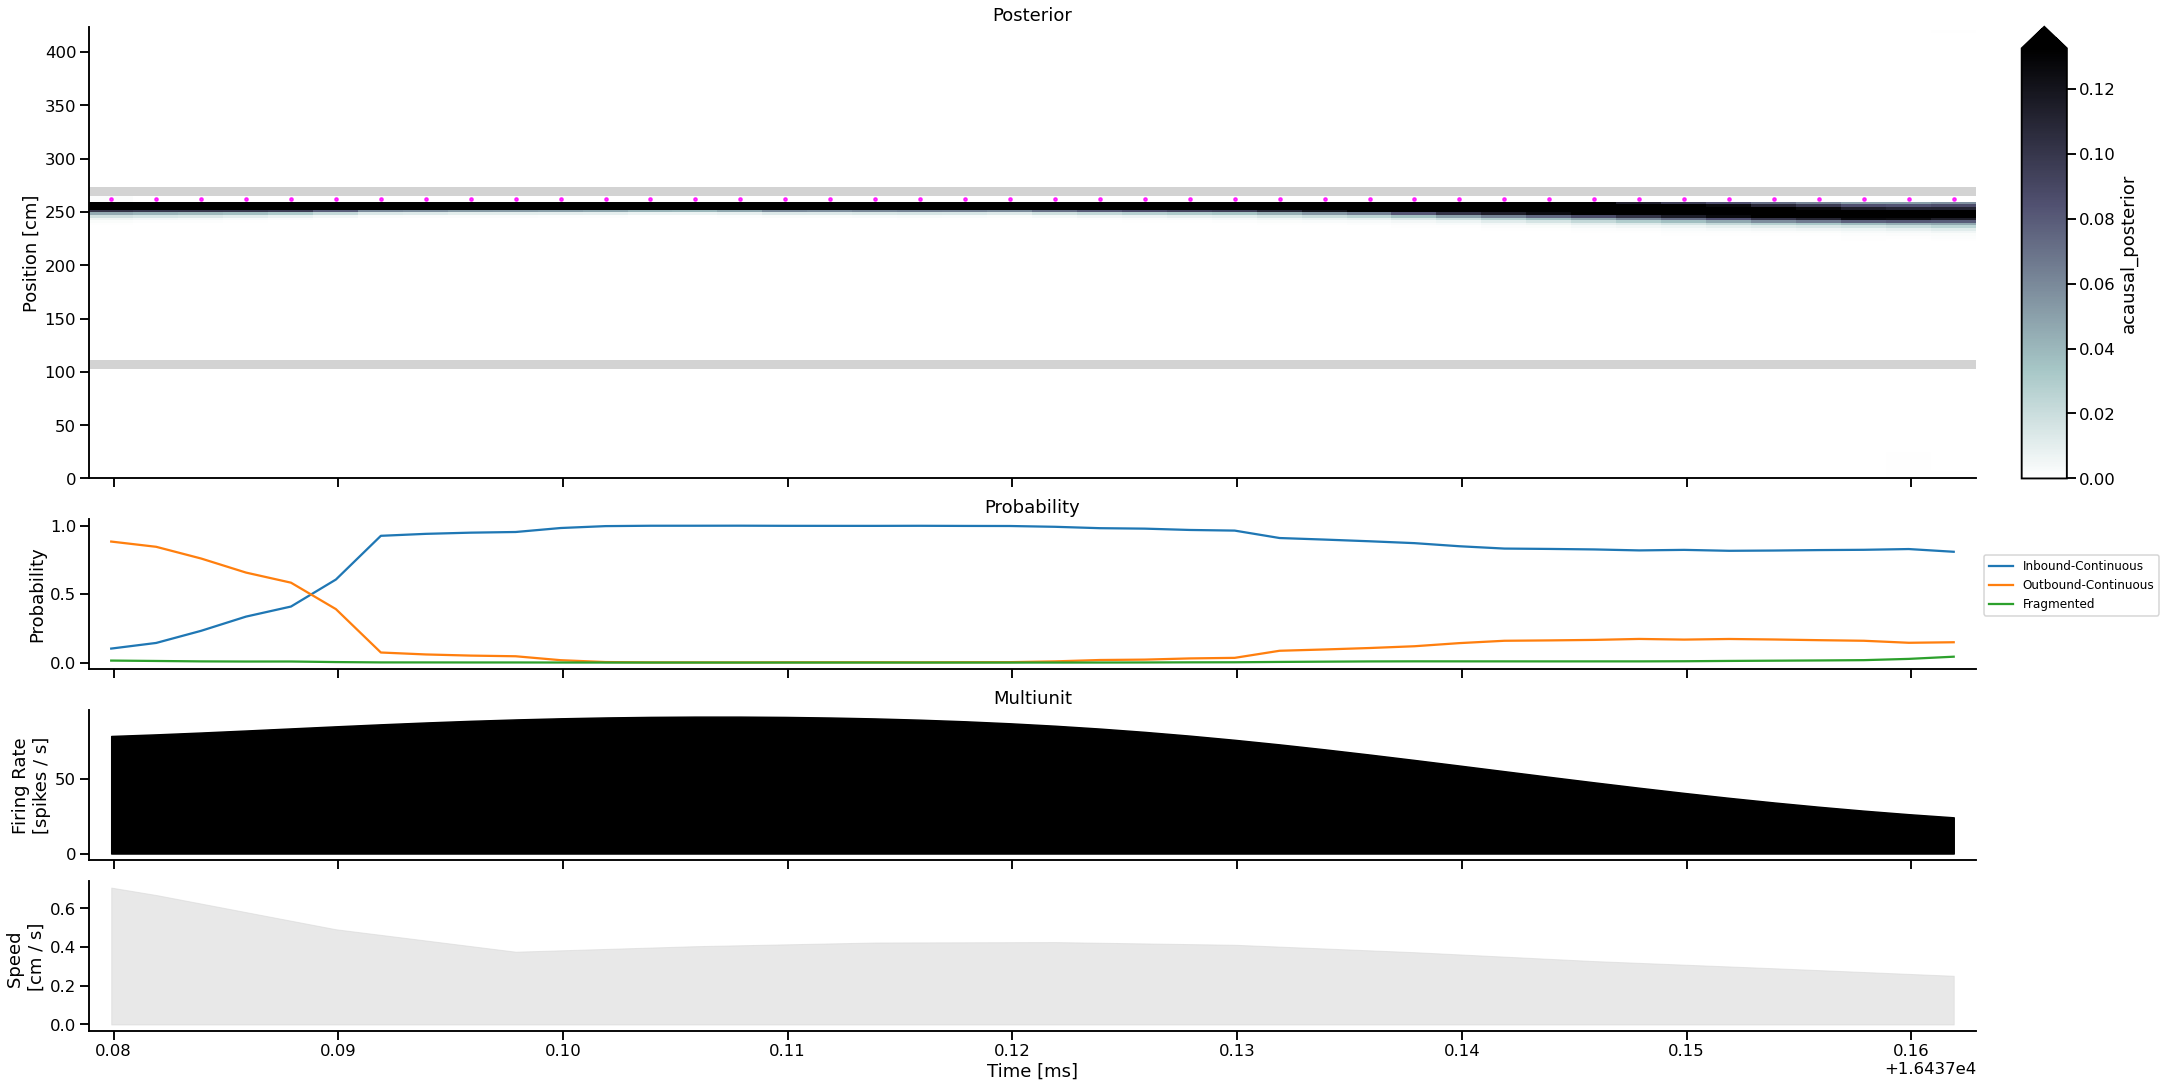

In [28]:
ripple_number = 14

plot_ripple_decode(data, classifier, ripple_number)

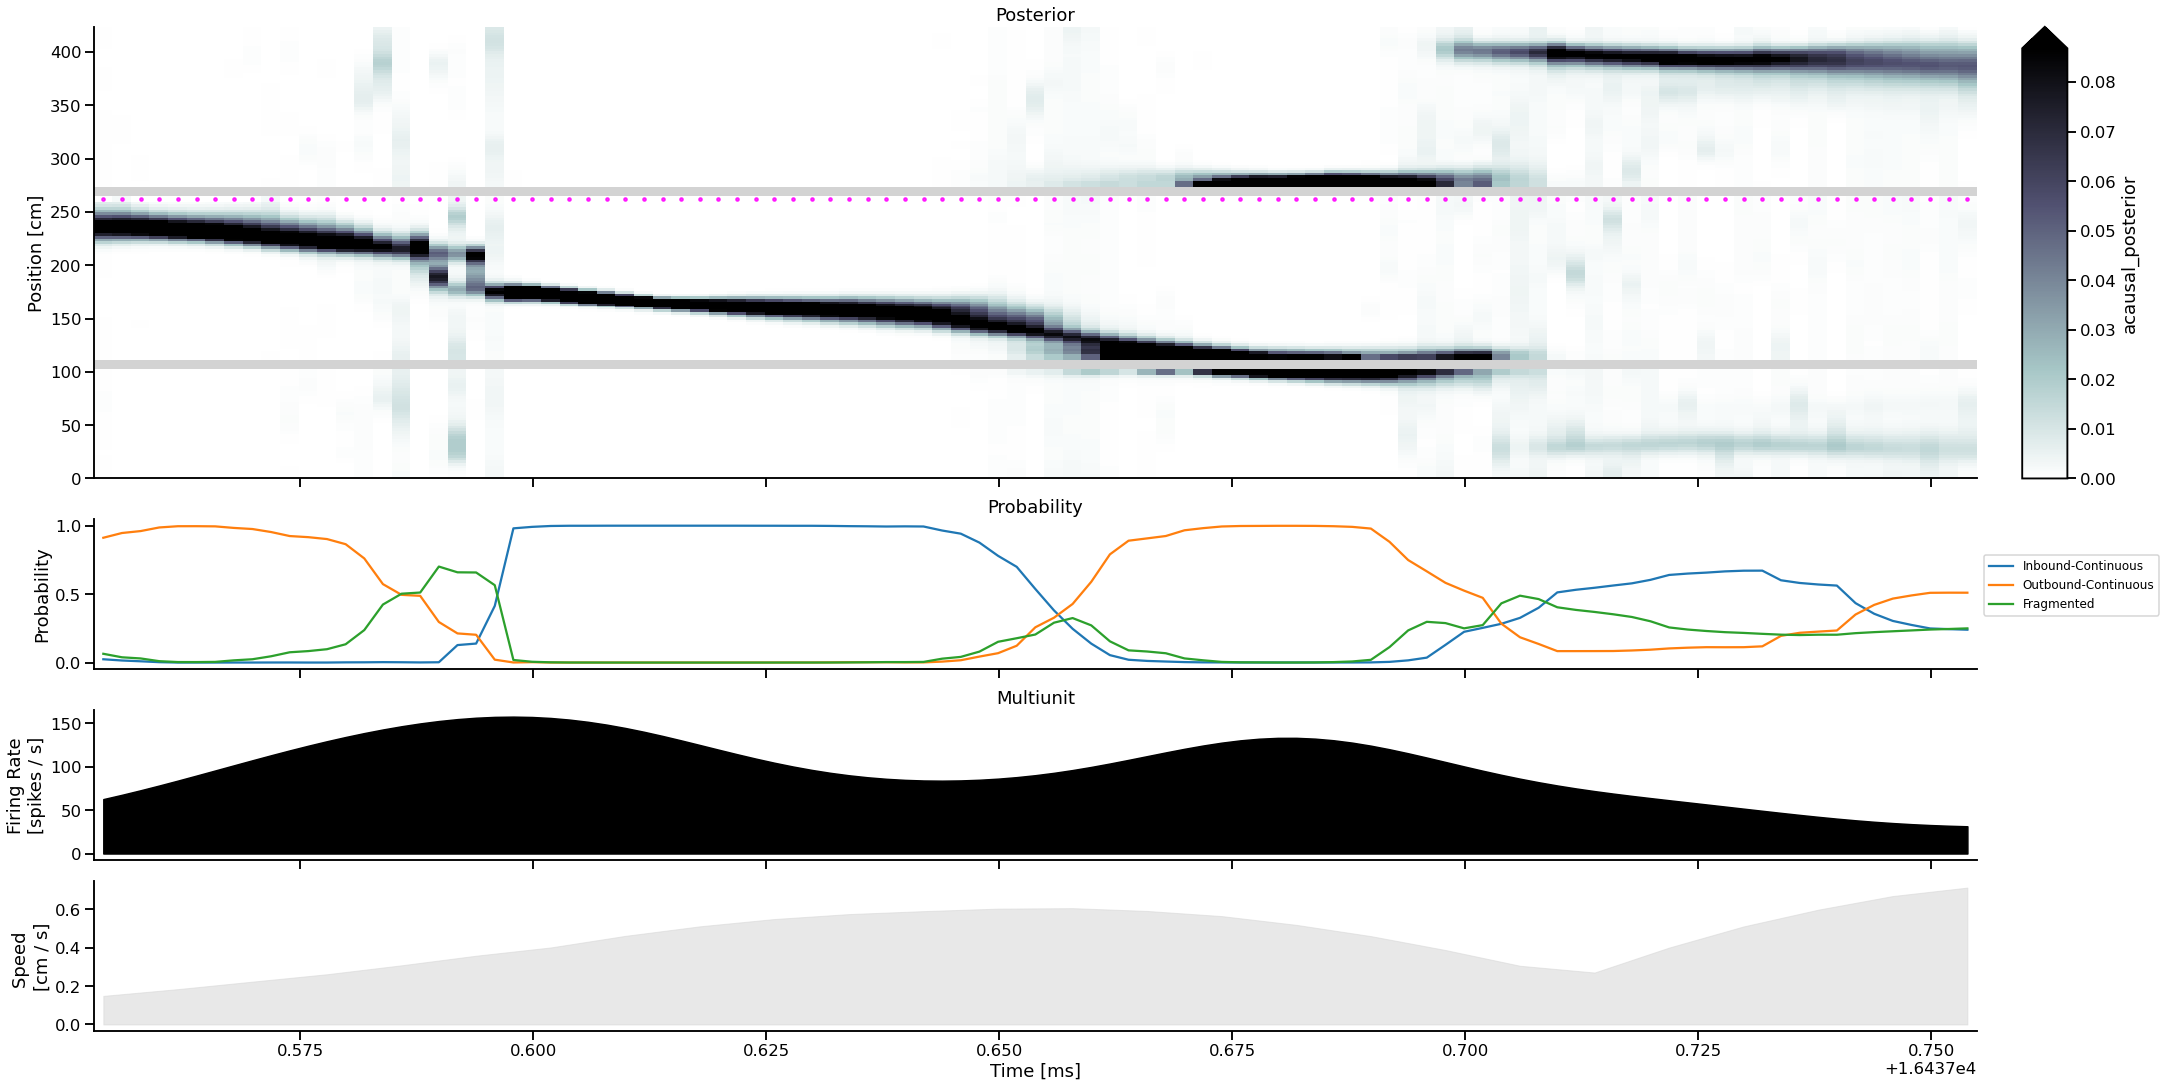

In [29]:
ripple_number = 15

plot_ripple_decode(data, classifier, ripple_number)

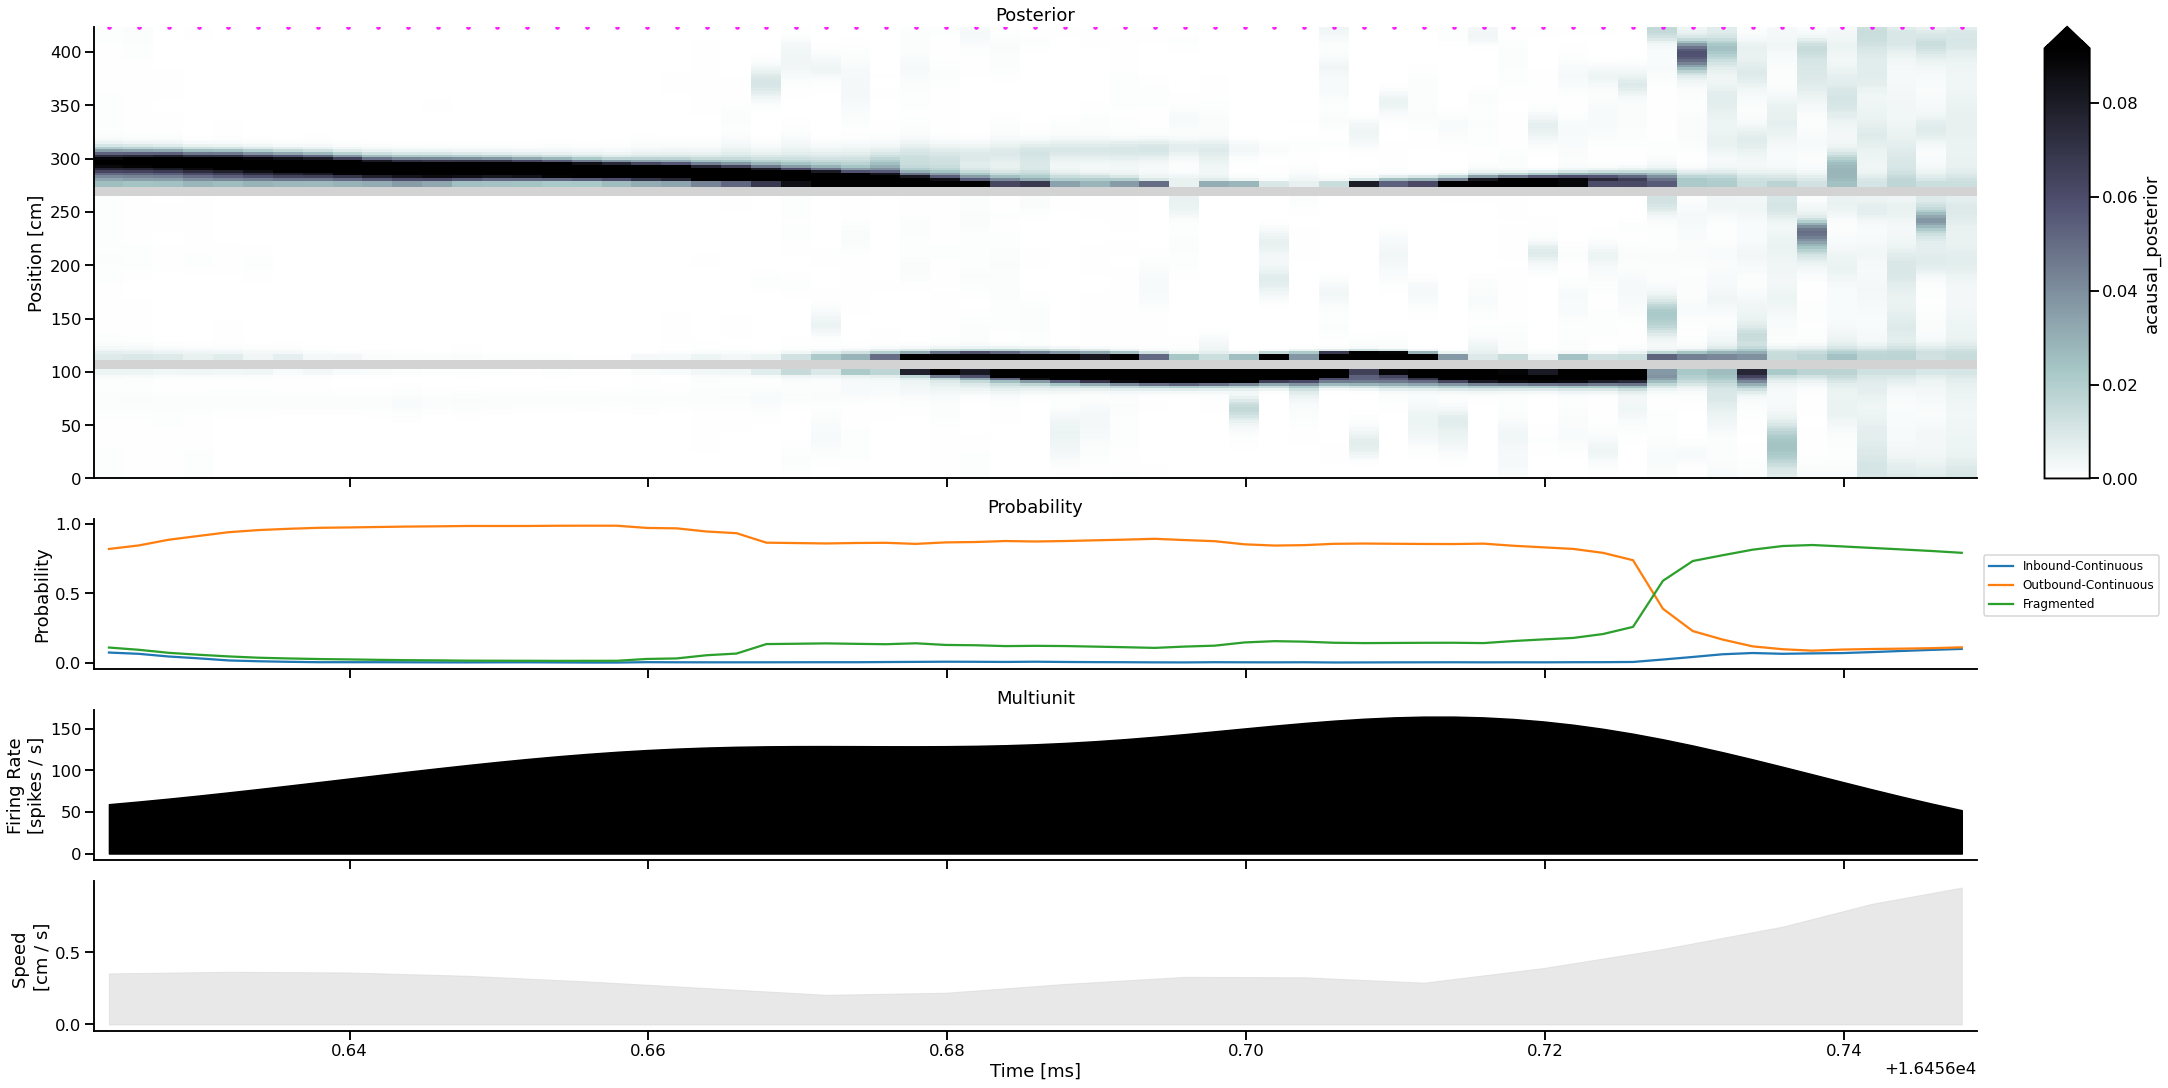

In [30]:
ripple_number = 16

plot_ripple_decode(data, classifier, ripple_number)

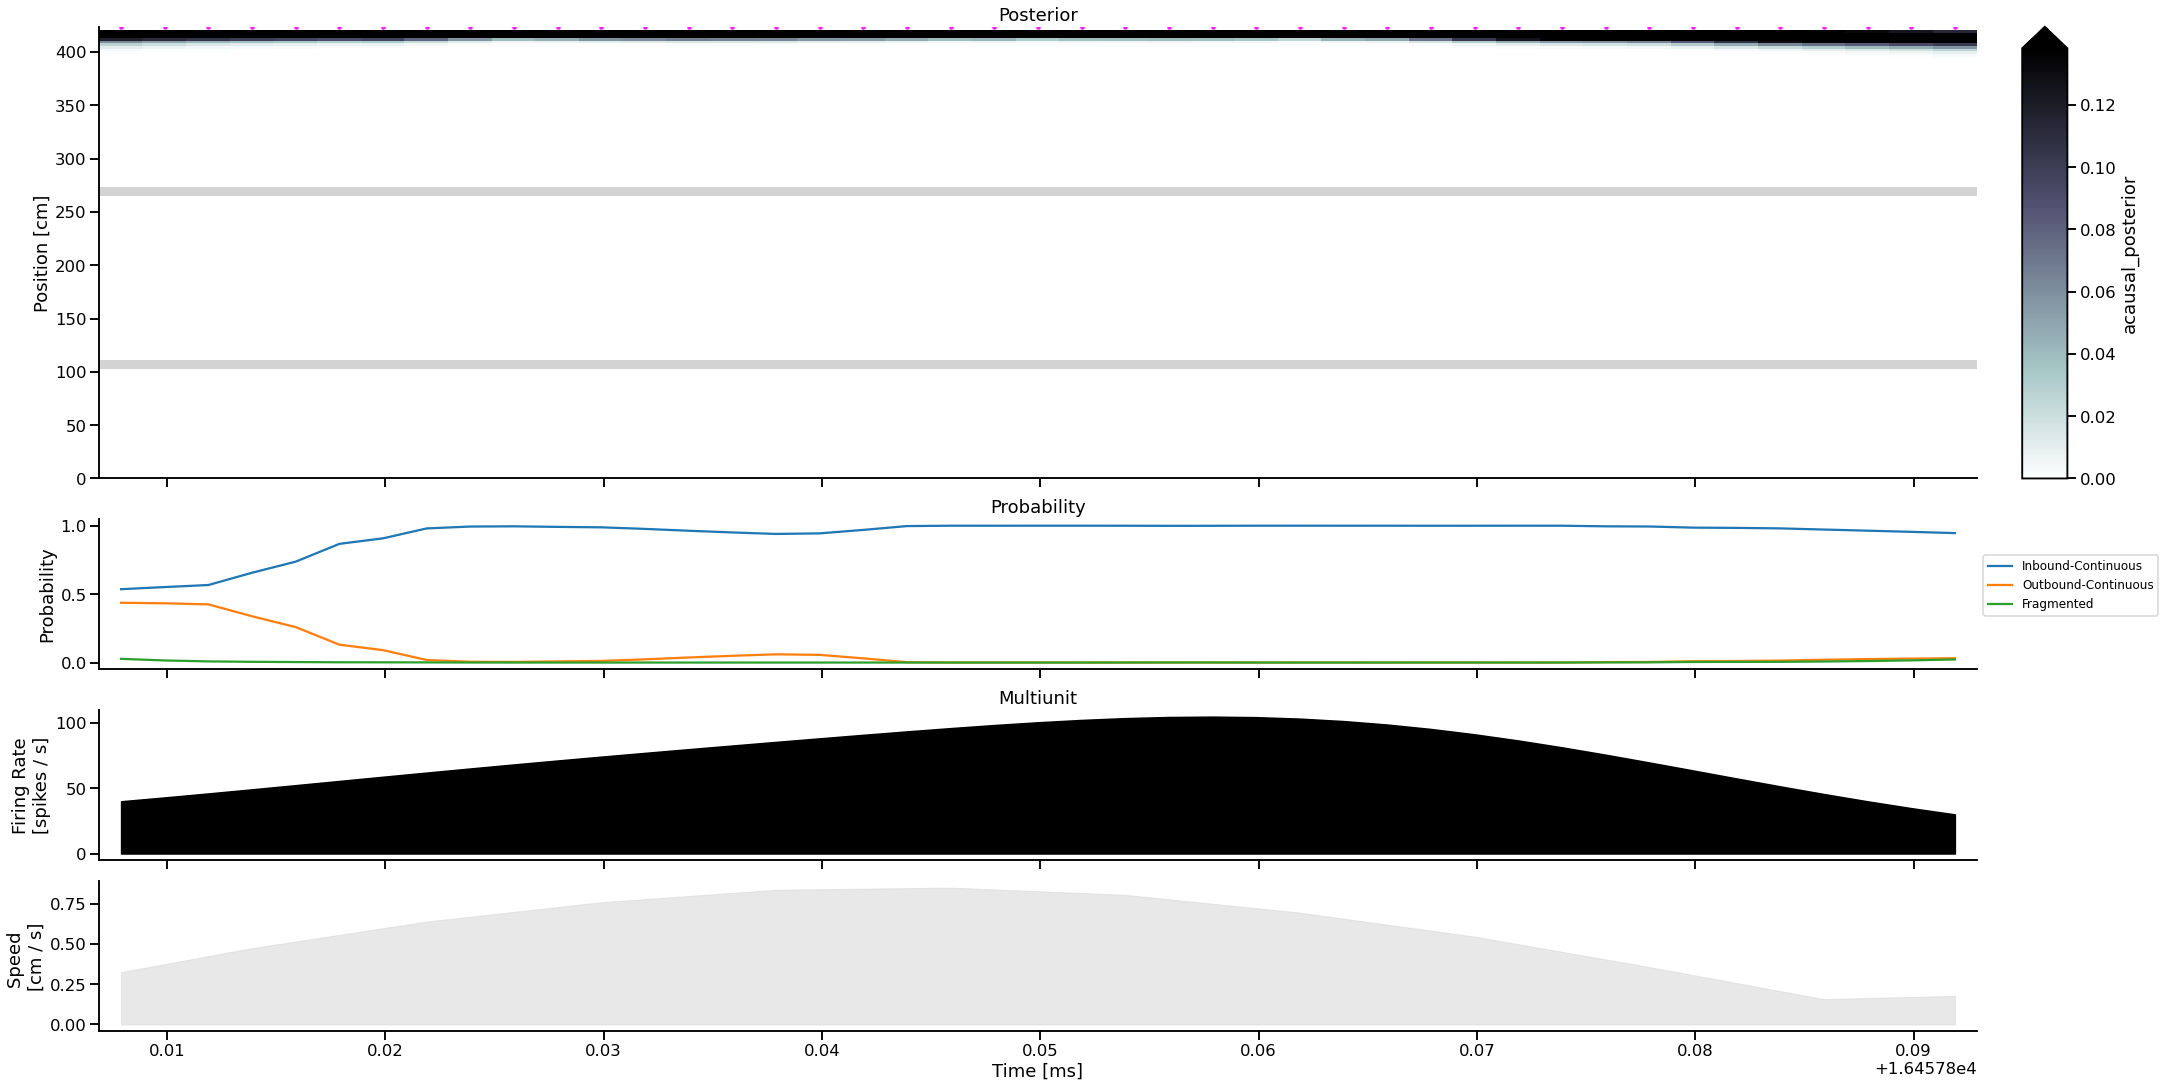

In [31]:
ripple_number = 17

plot_ripple_decode(data, classifier, ripple_number)

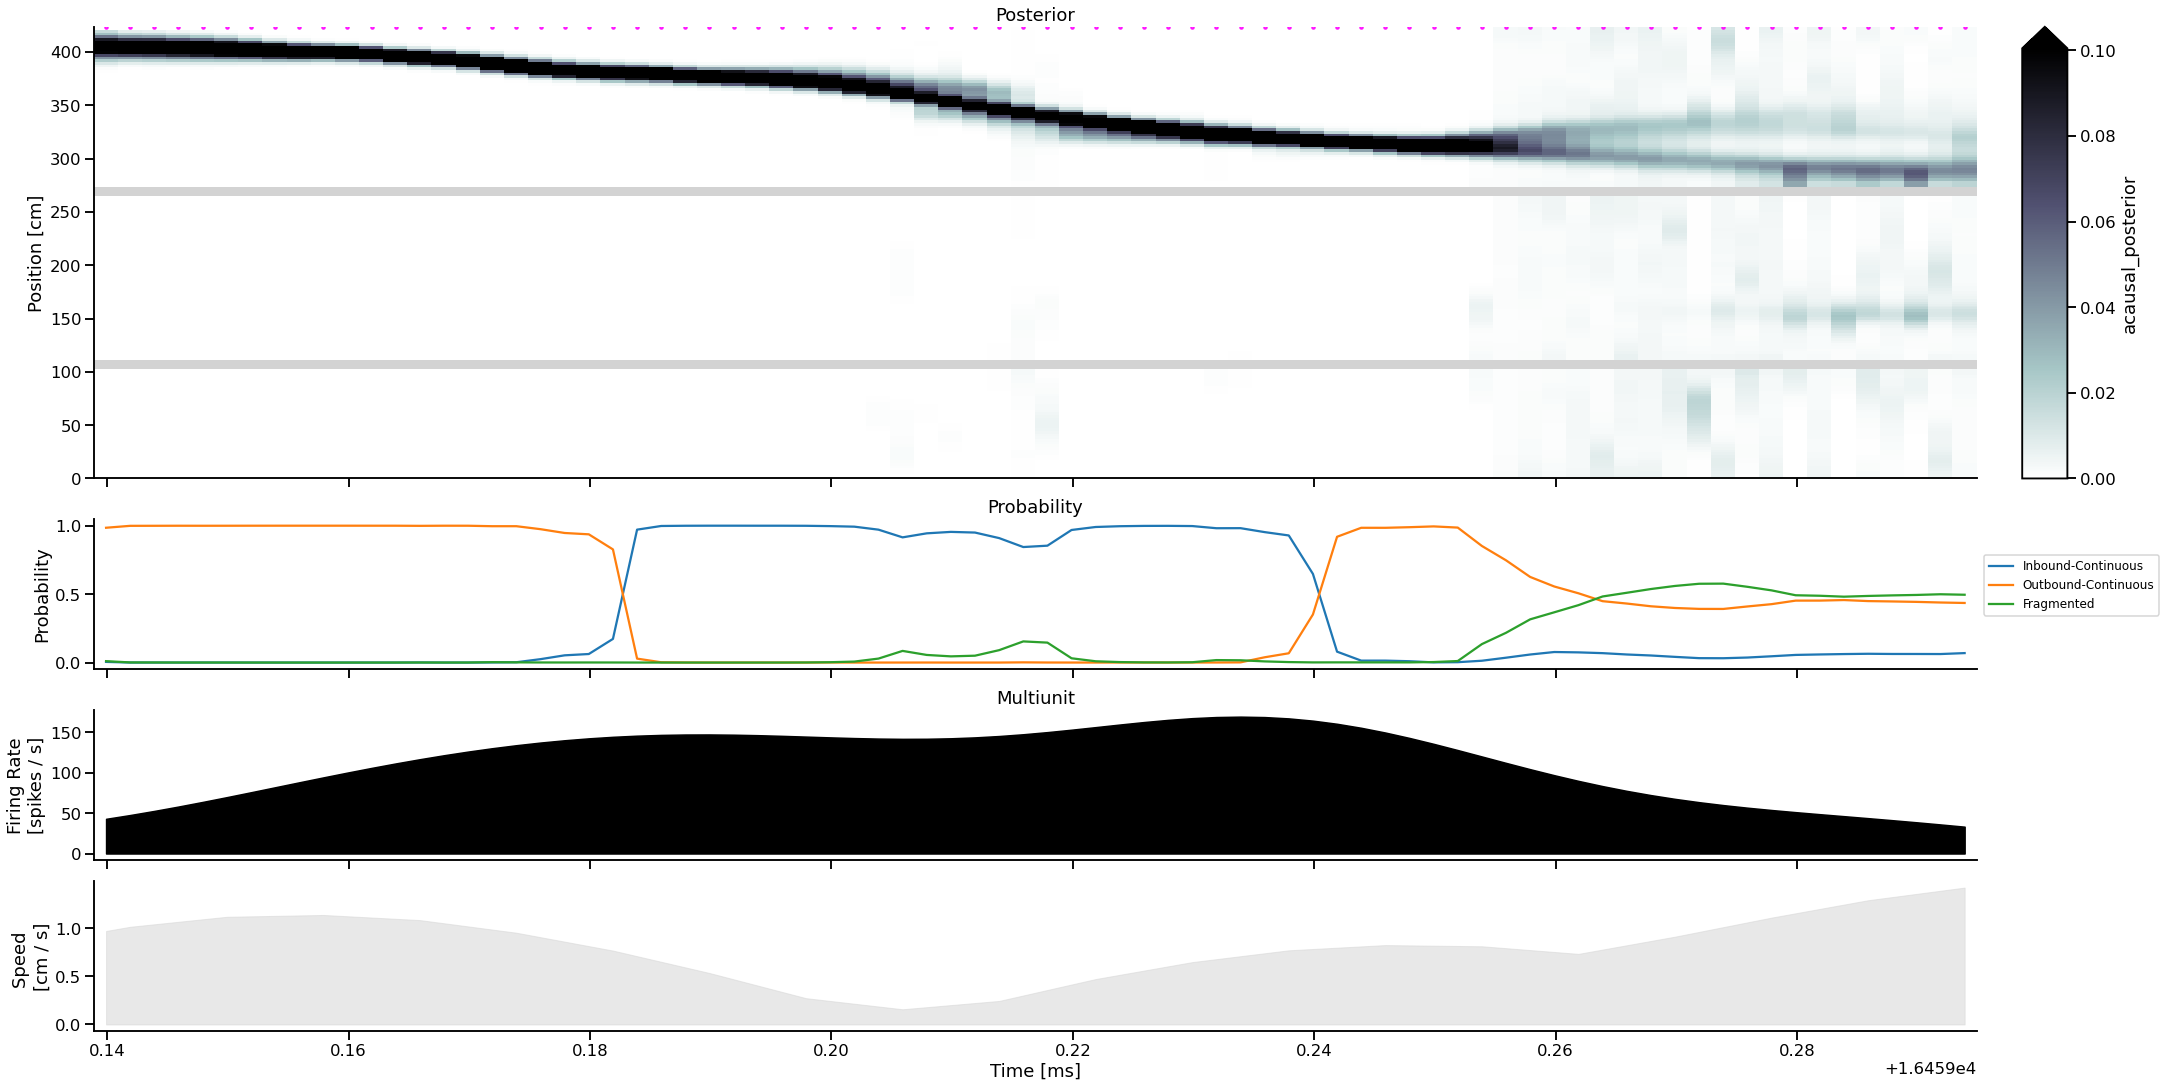

In [32]:
ripple_number = 18

plot_ripple_decode(data, classifier, ripple_number)

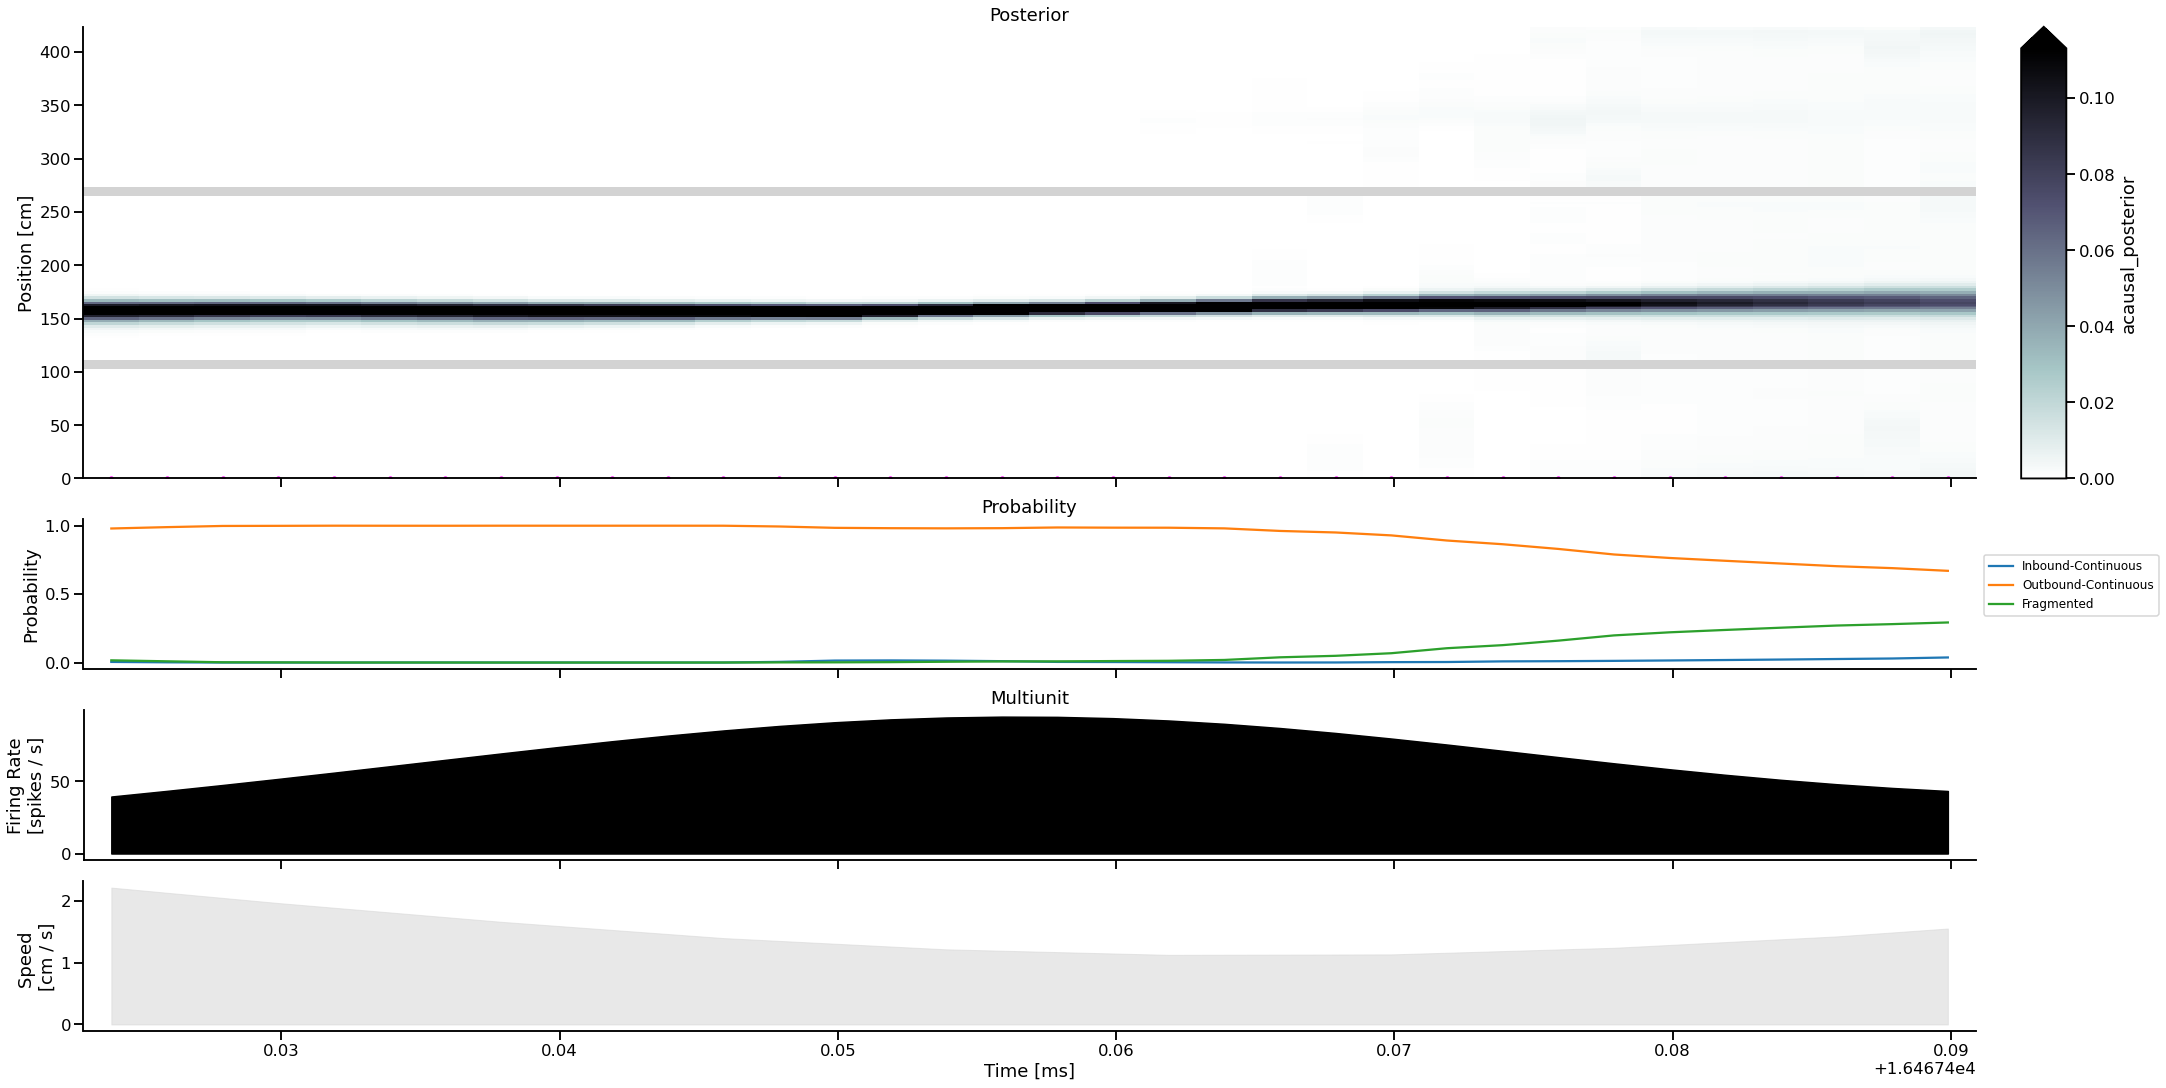

In [33]:
ripple_number = 19

plot_ripple_decode(data, classifier, ripple_number)

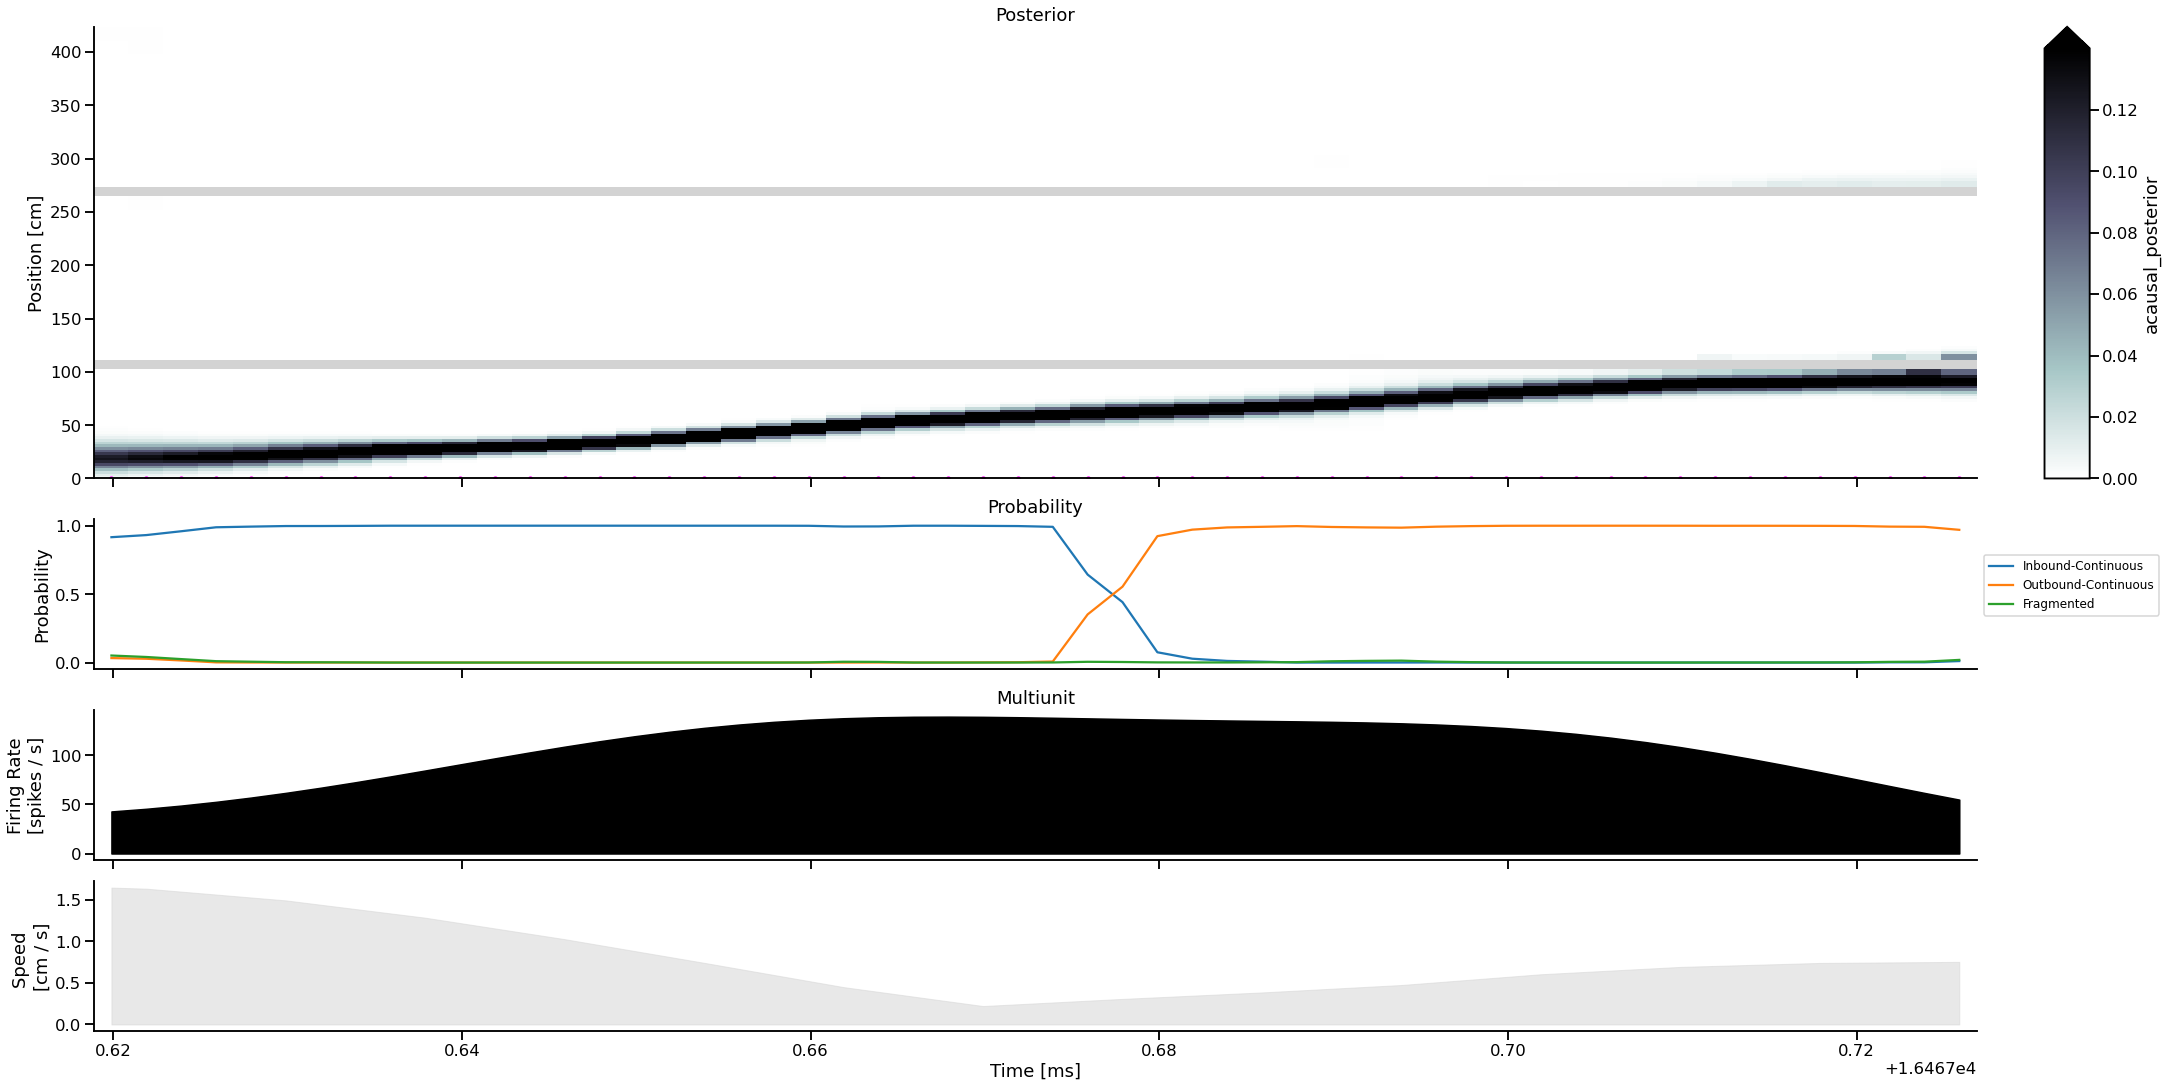

In [34]:
ripple_number = 20

plot_ripple_decode(data, classifier, ripple_number)

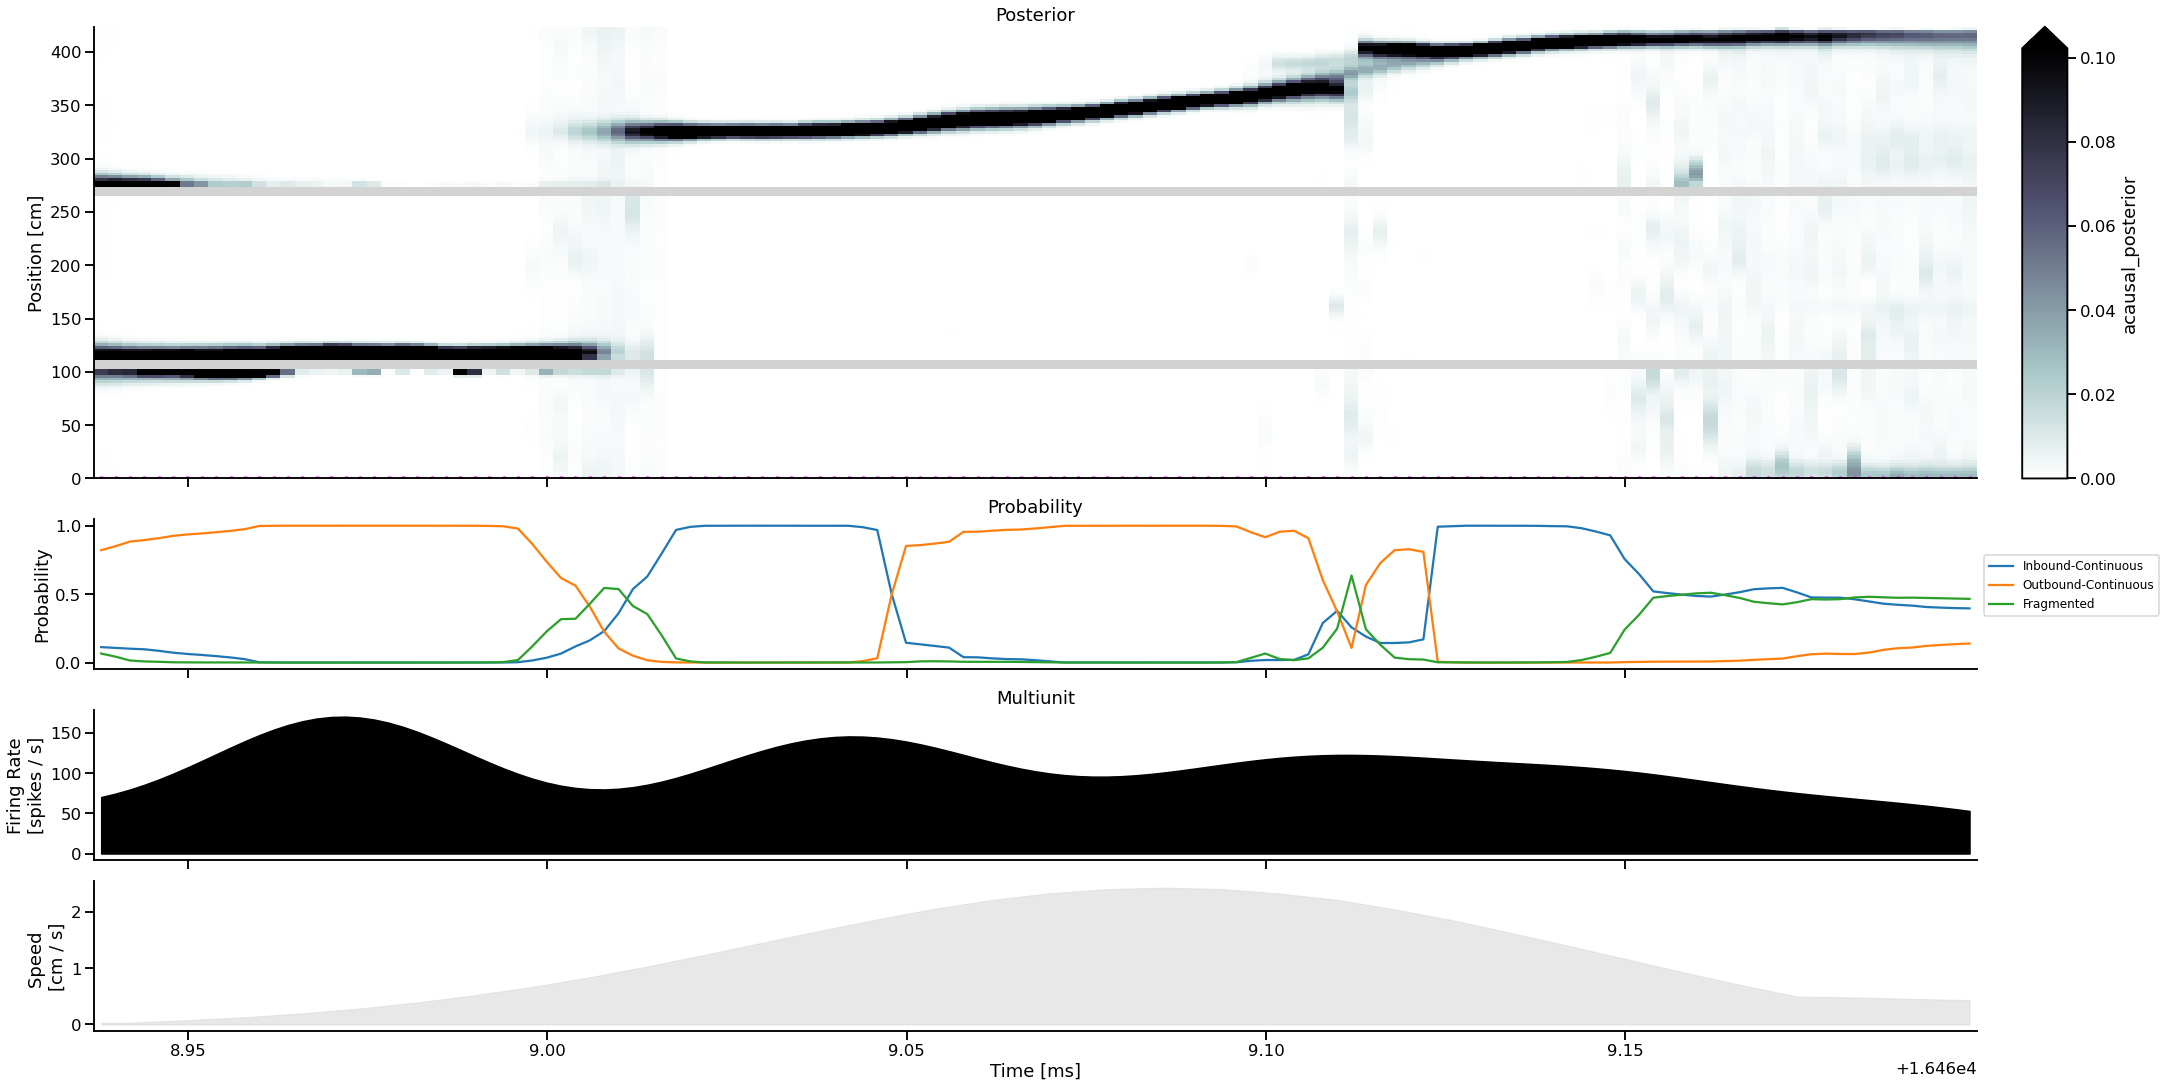

In [35]:
ripple_number = 21

plot_ripple_decode(data, classifier, ripple_number)

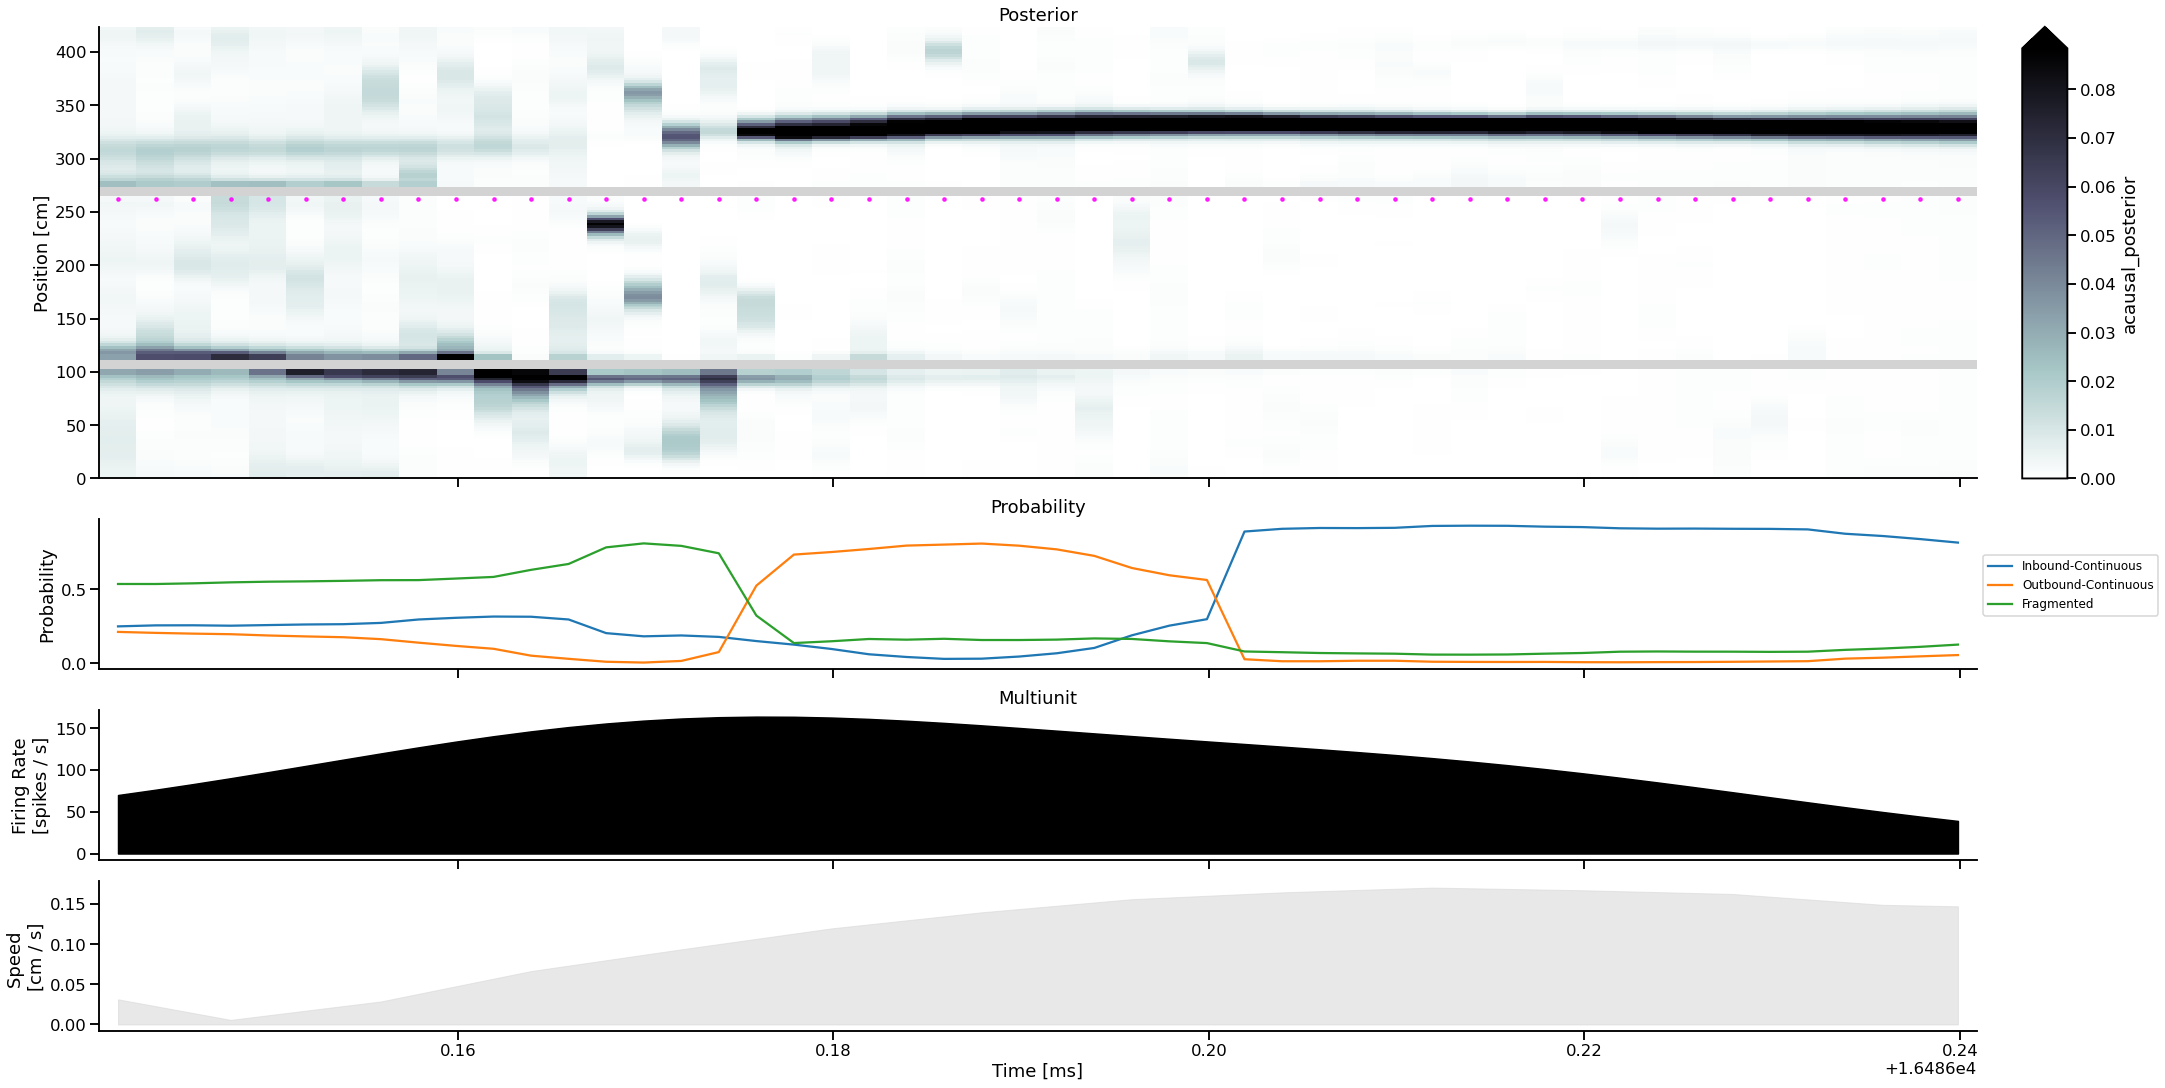

In [36]:
ripple_number = 22

plot_ripple_decode(data, classifier, ripple_number)

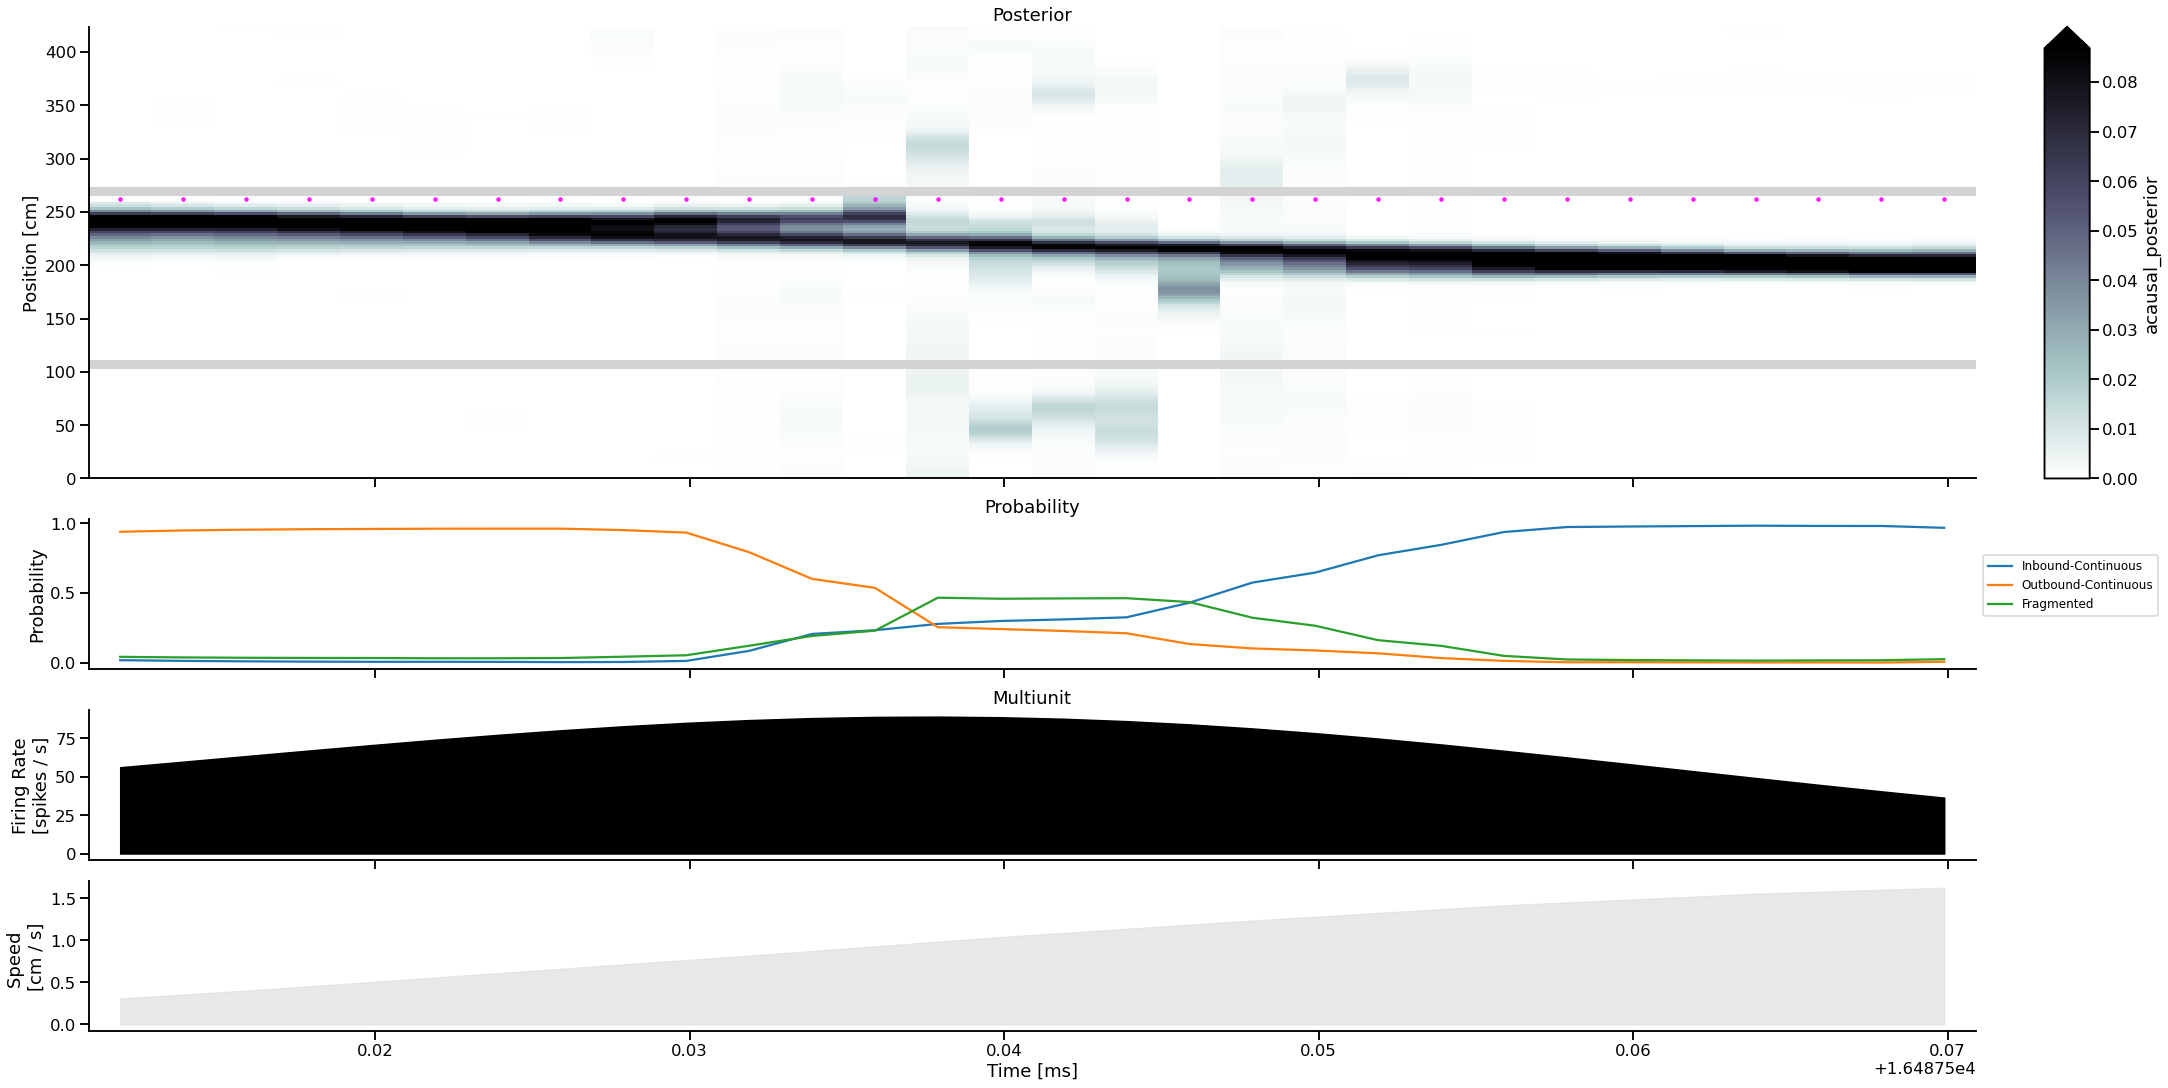

In [37]:
ripple_number = 23

plot_ripple_decode(data, classifier, ripple_number)

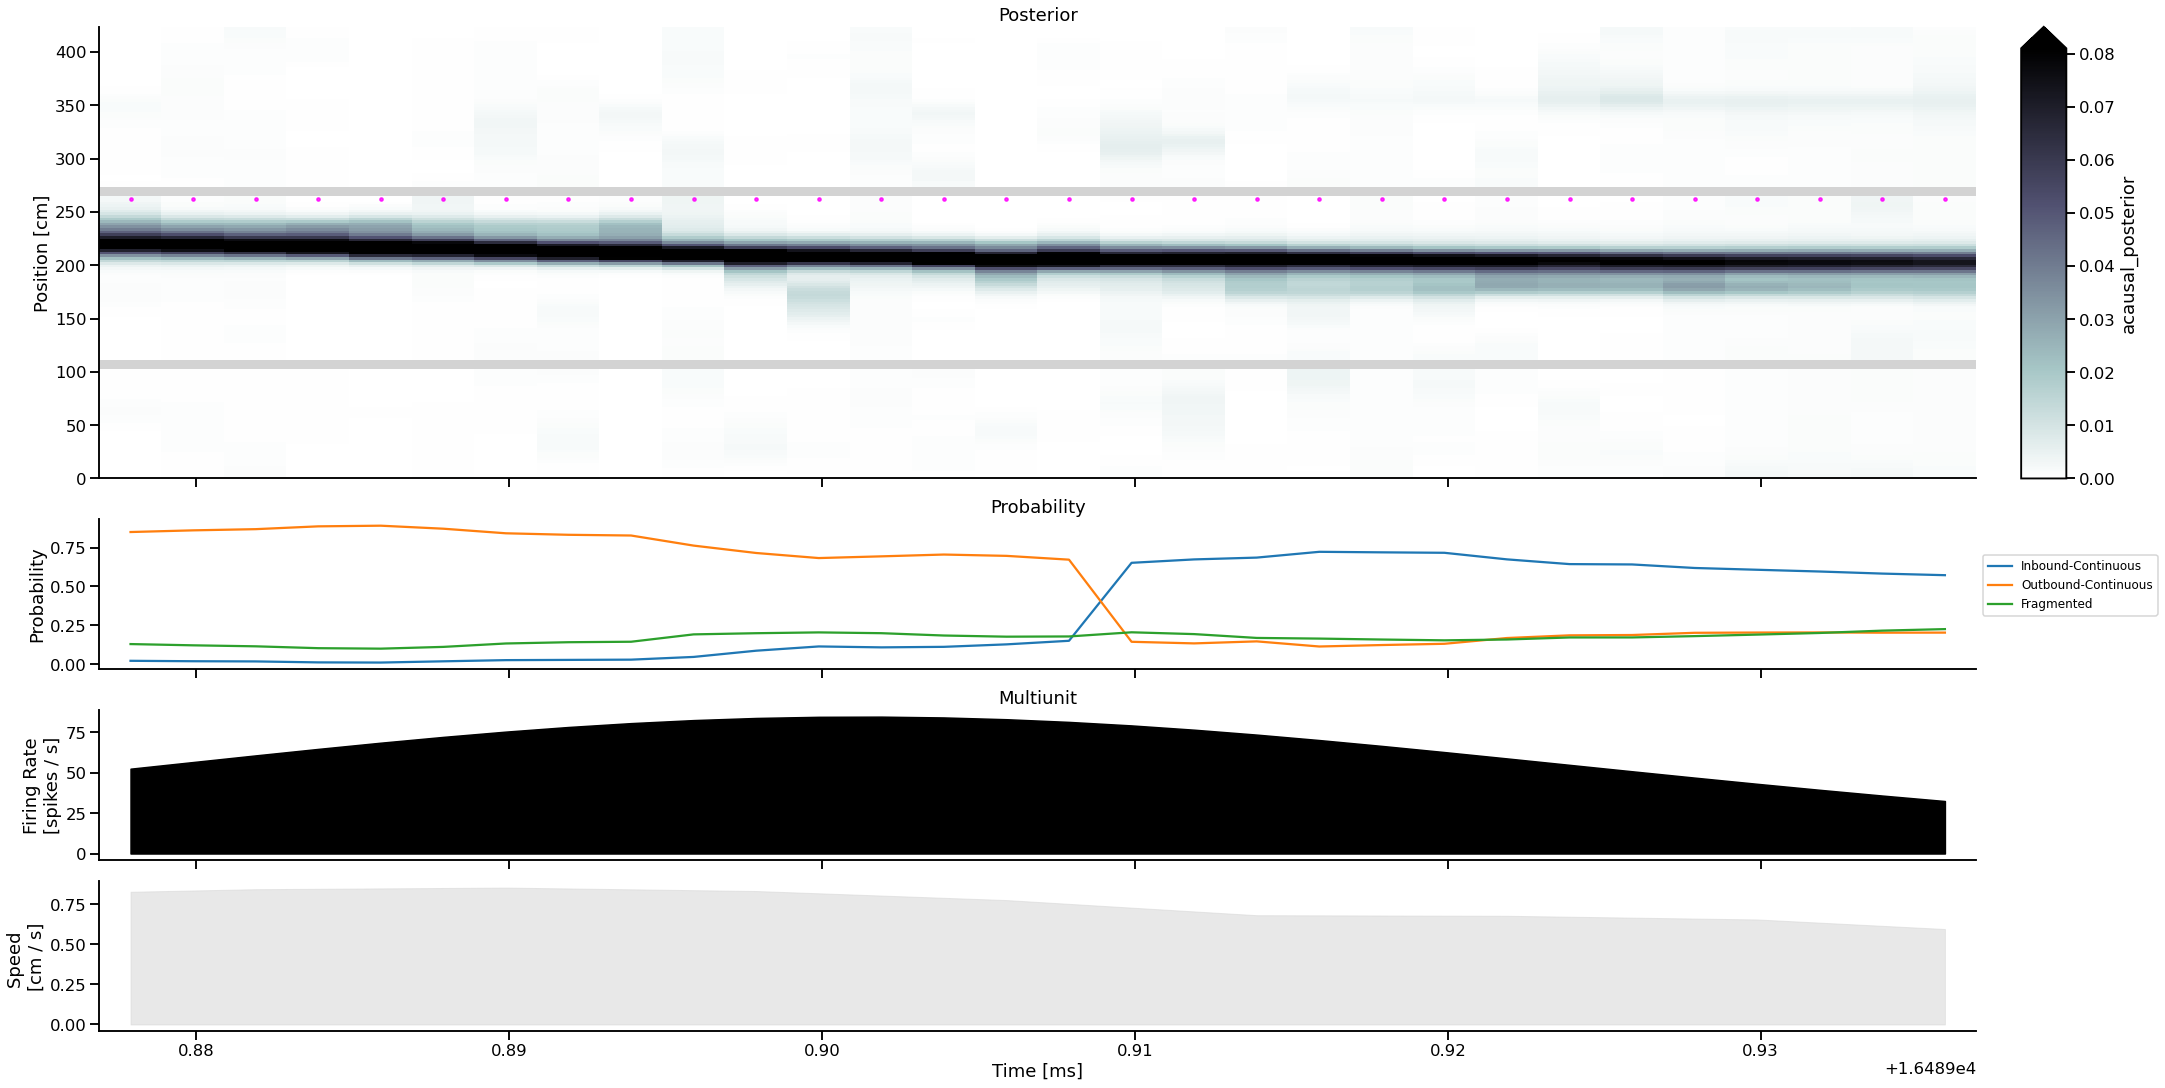

In [38]:
ripple_number = 24

plot_ripple_decode(data, classifier, ripple_number)

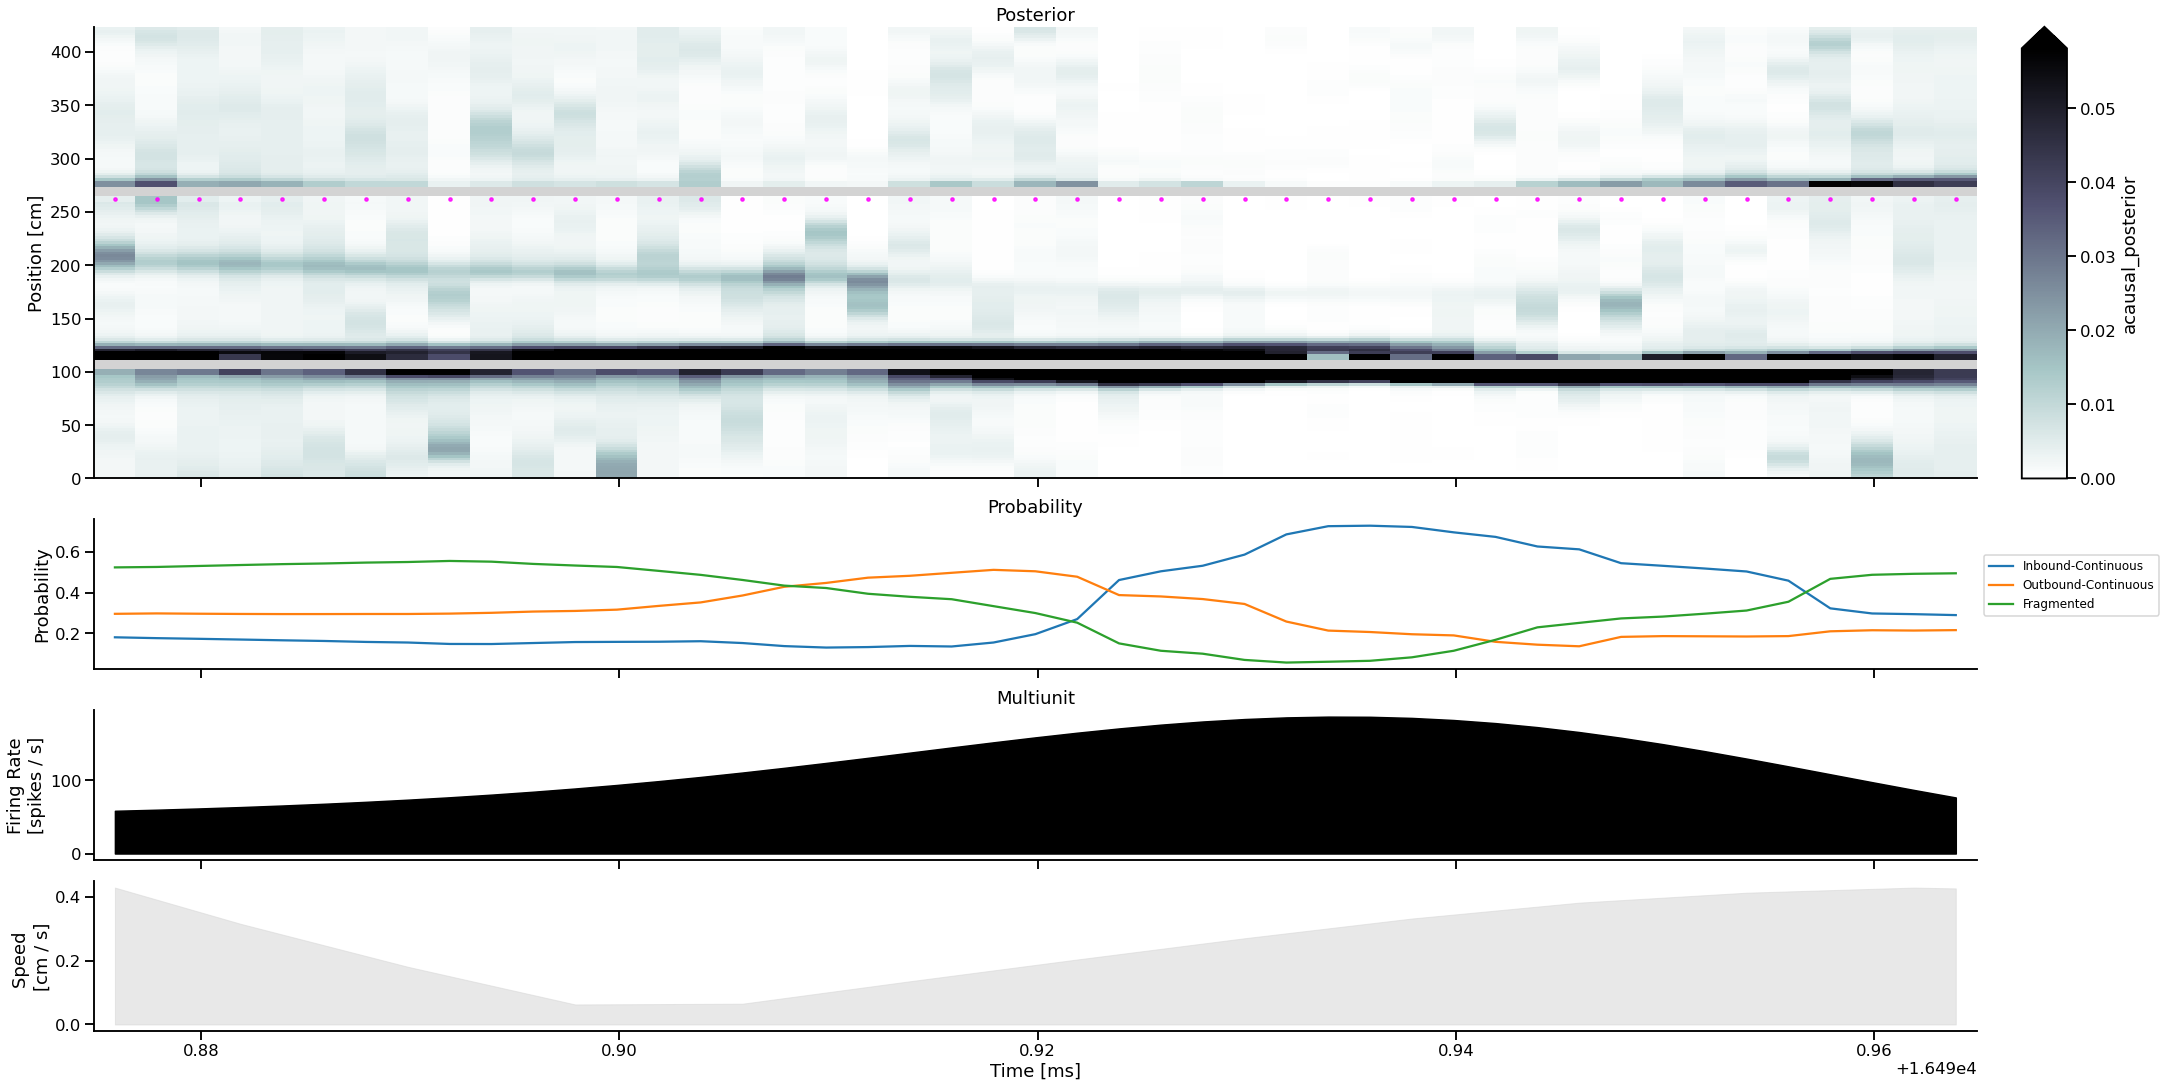

In [39]:
ripple_number = 25

plot_ripple_decode(data, classifier, ripple_number)

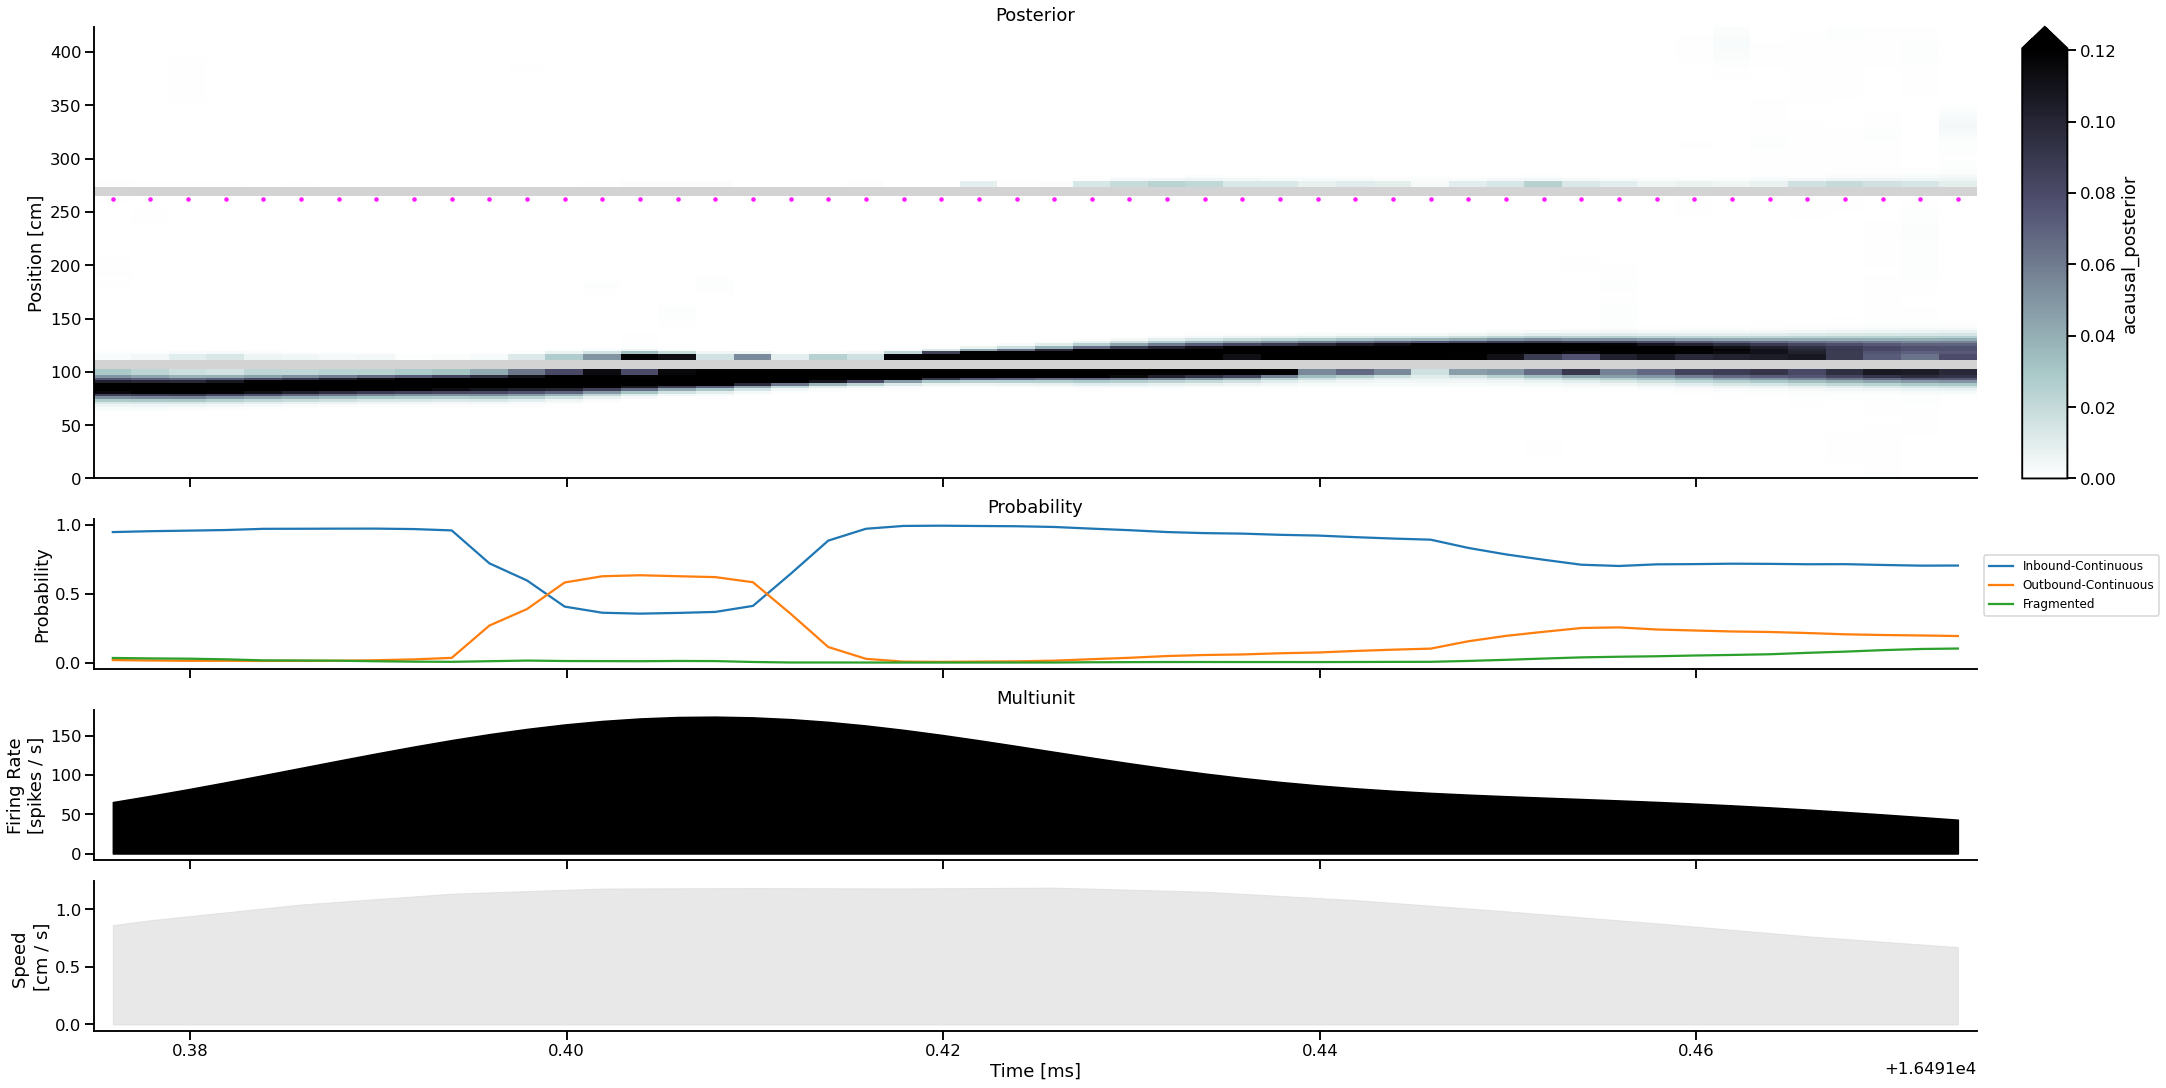

In [53]:
ripple_number = 26

plot_ripple_decode(data, classifier, ripple_number)

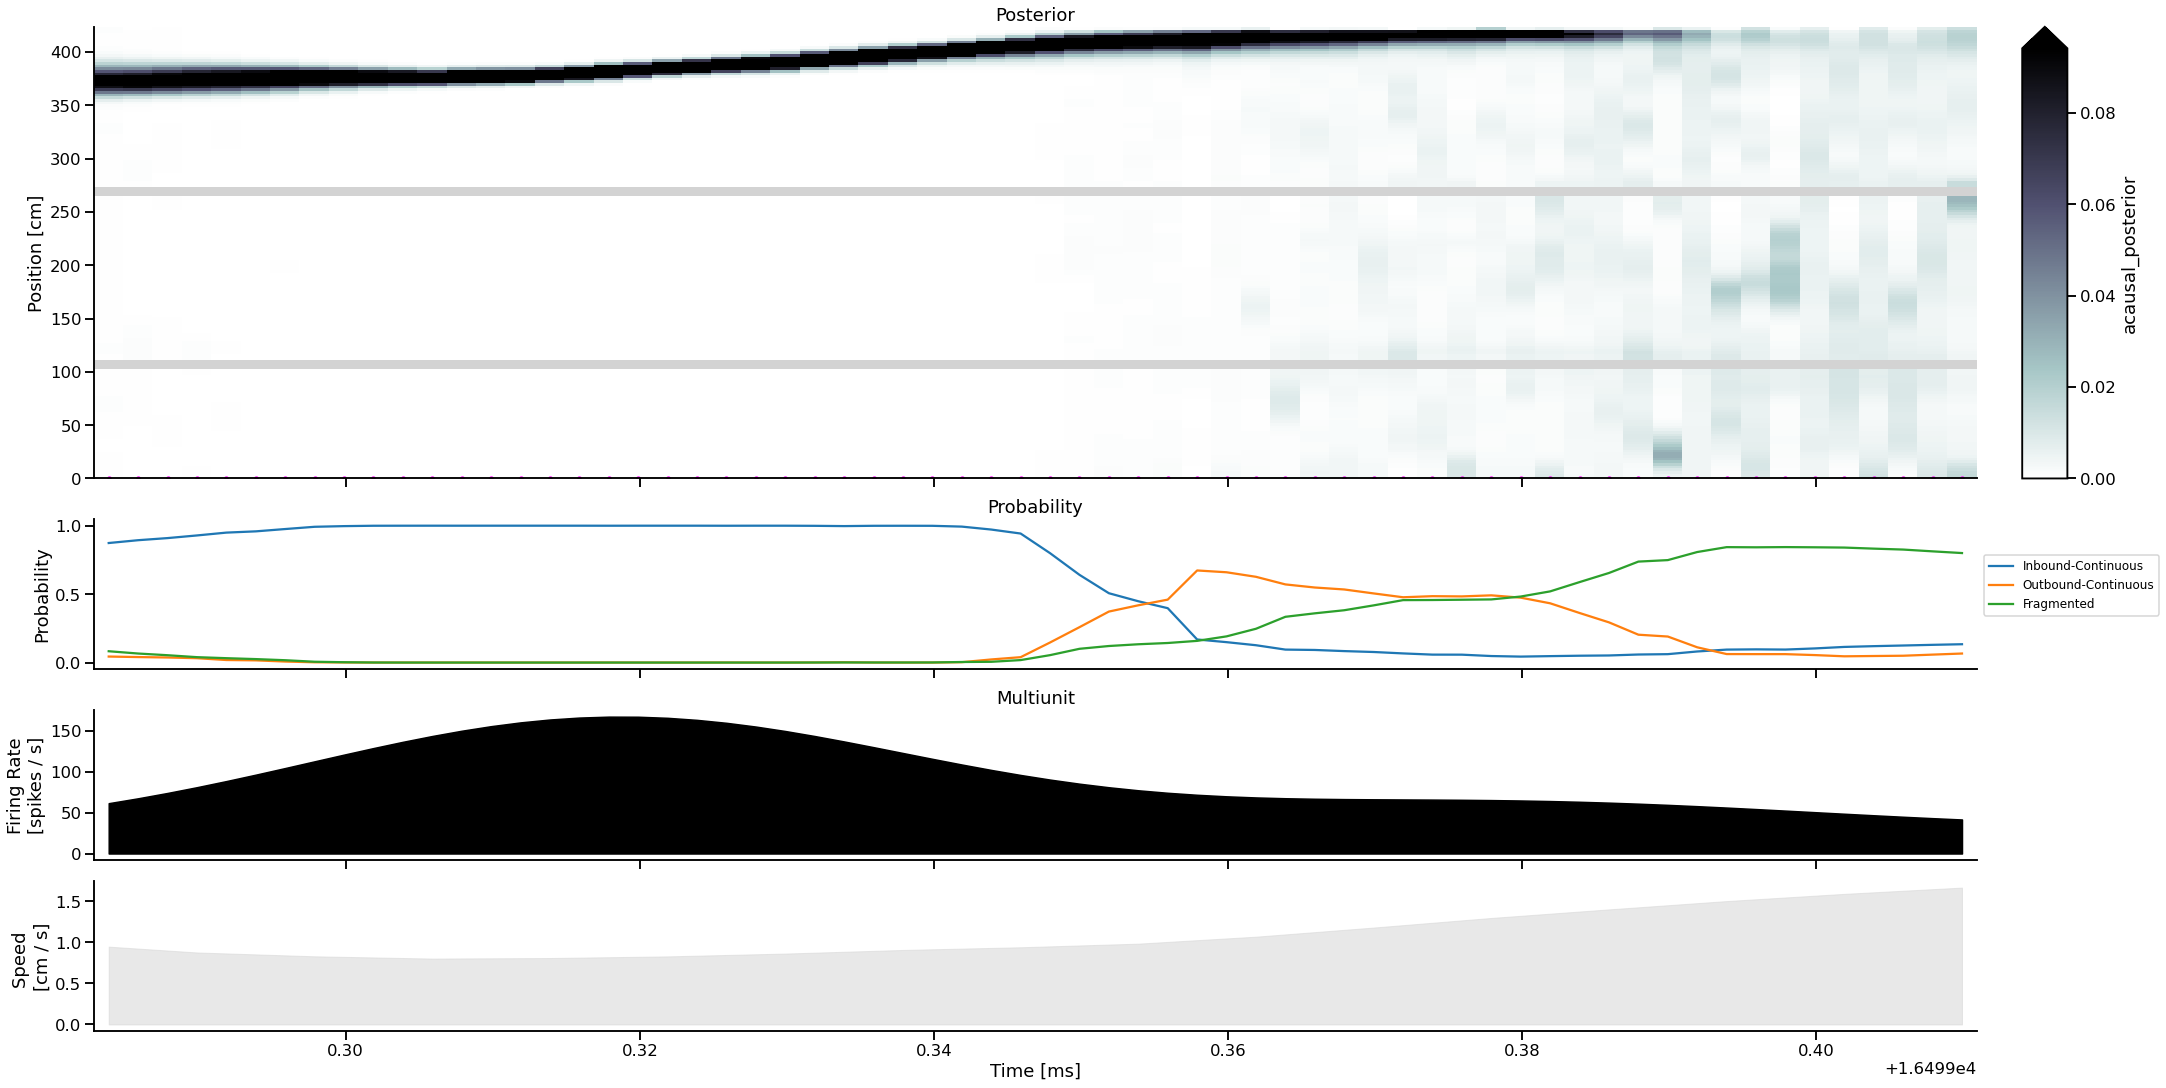

In [54]:
ripple_number = 27

plot_ripple_decode(data, classifier, ripple_number)

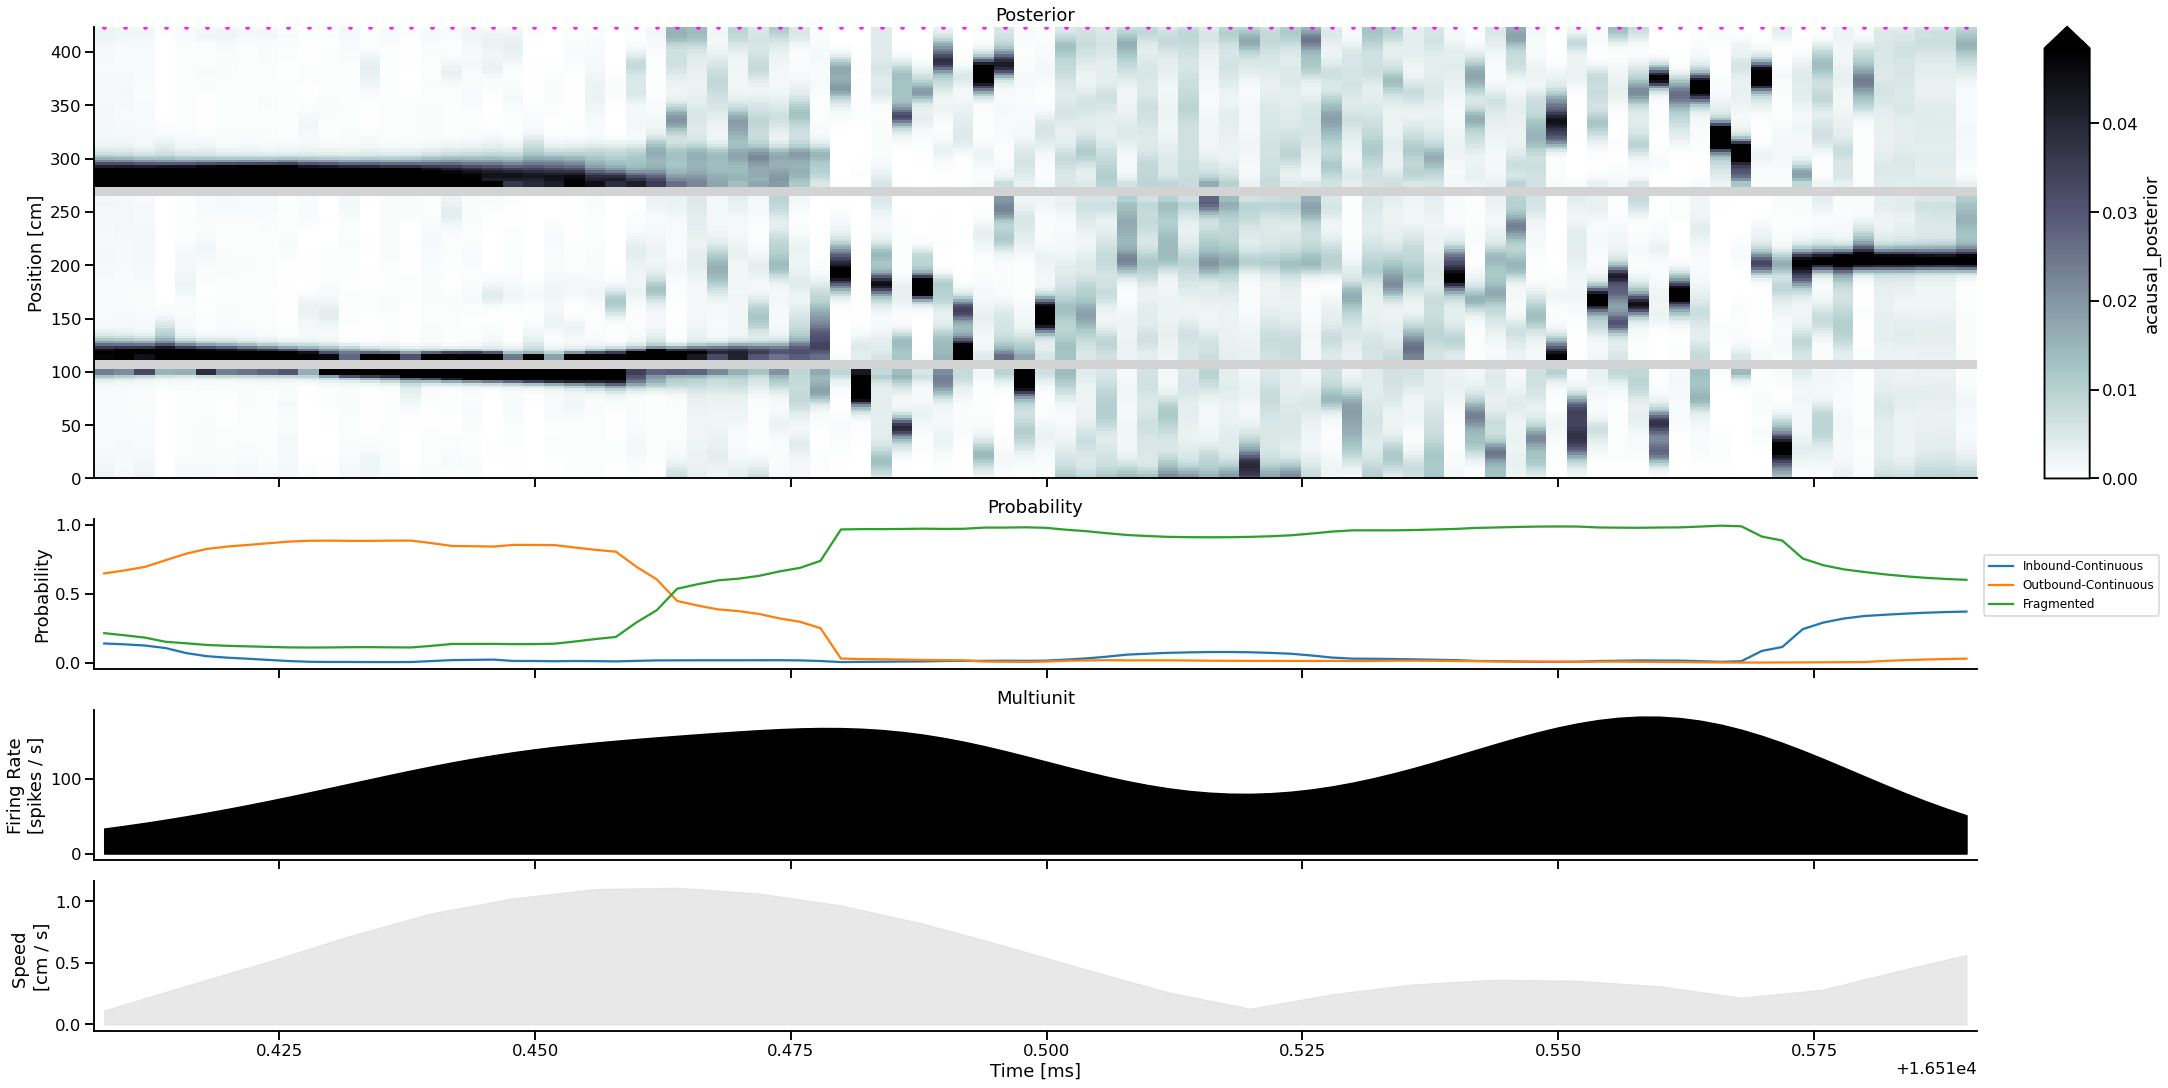

In [55]:
ripple_number = 28

plot_ripple_decode(data, classifier, ripple_number)

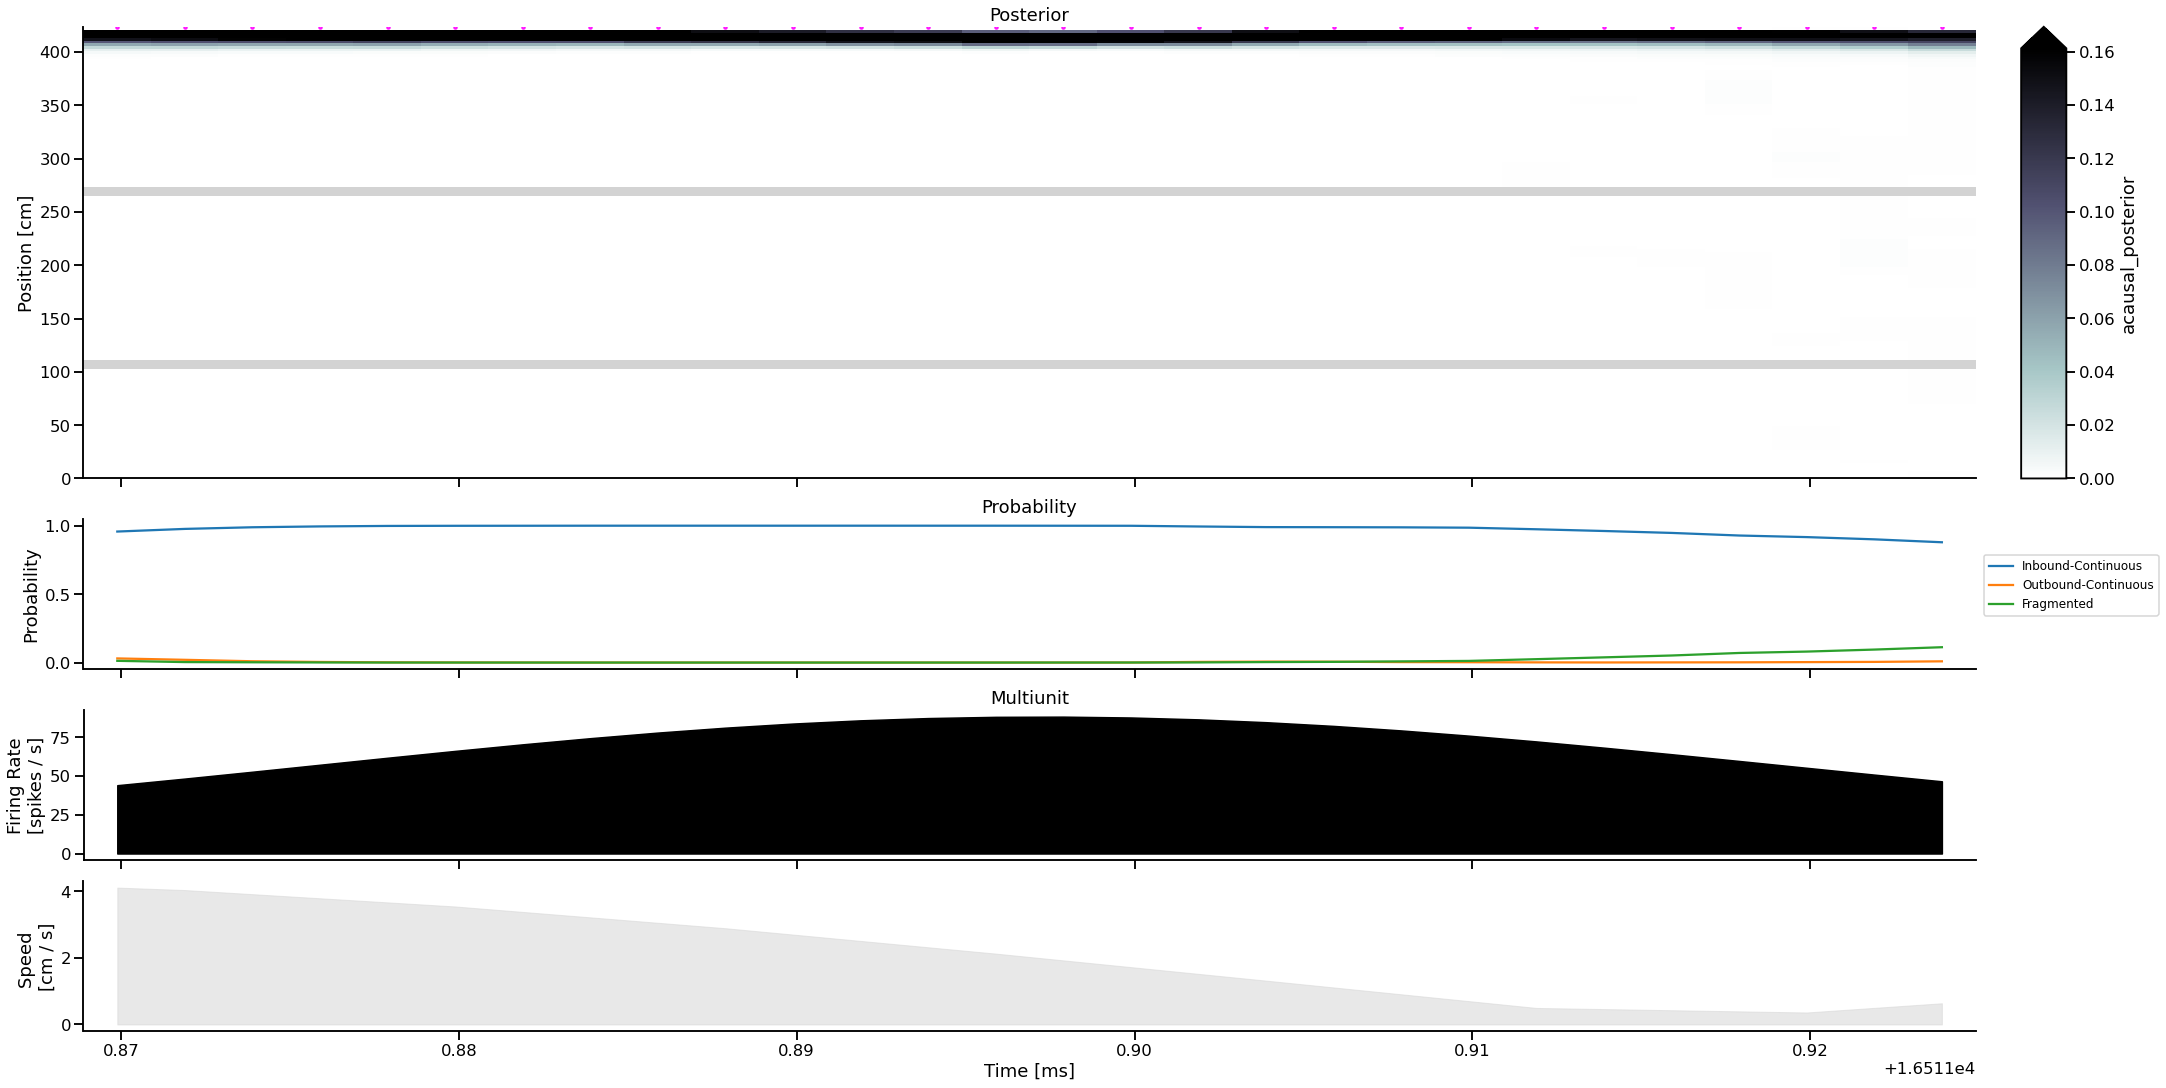

In [56]:
ripple_number = 29

plot_ripple_decode(data, classifier, ripple_number)

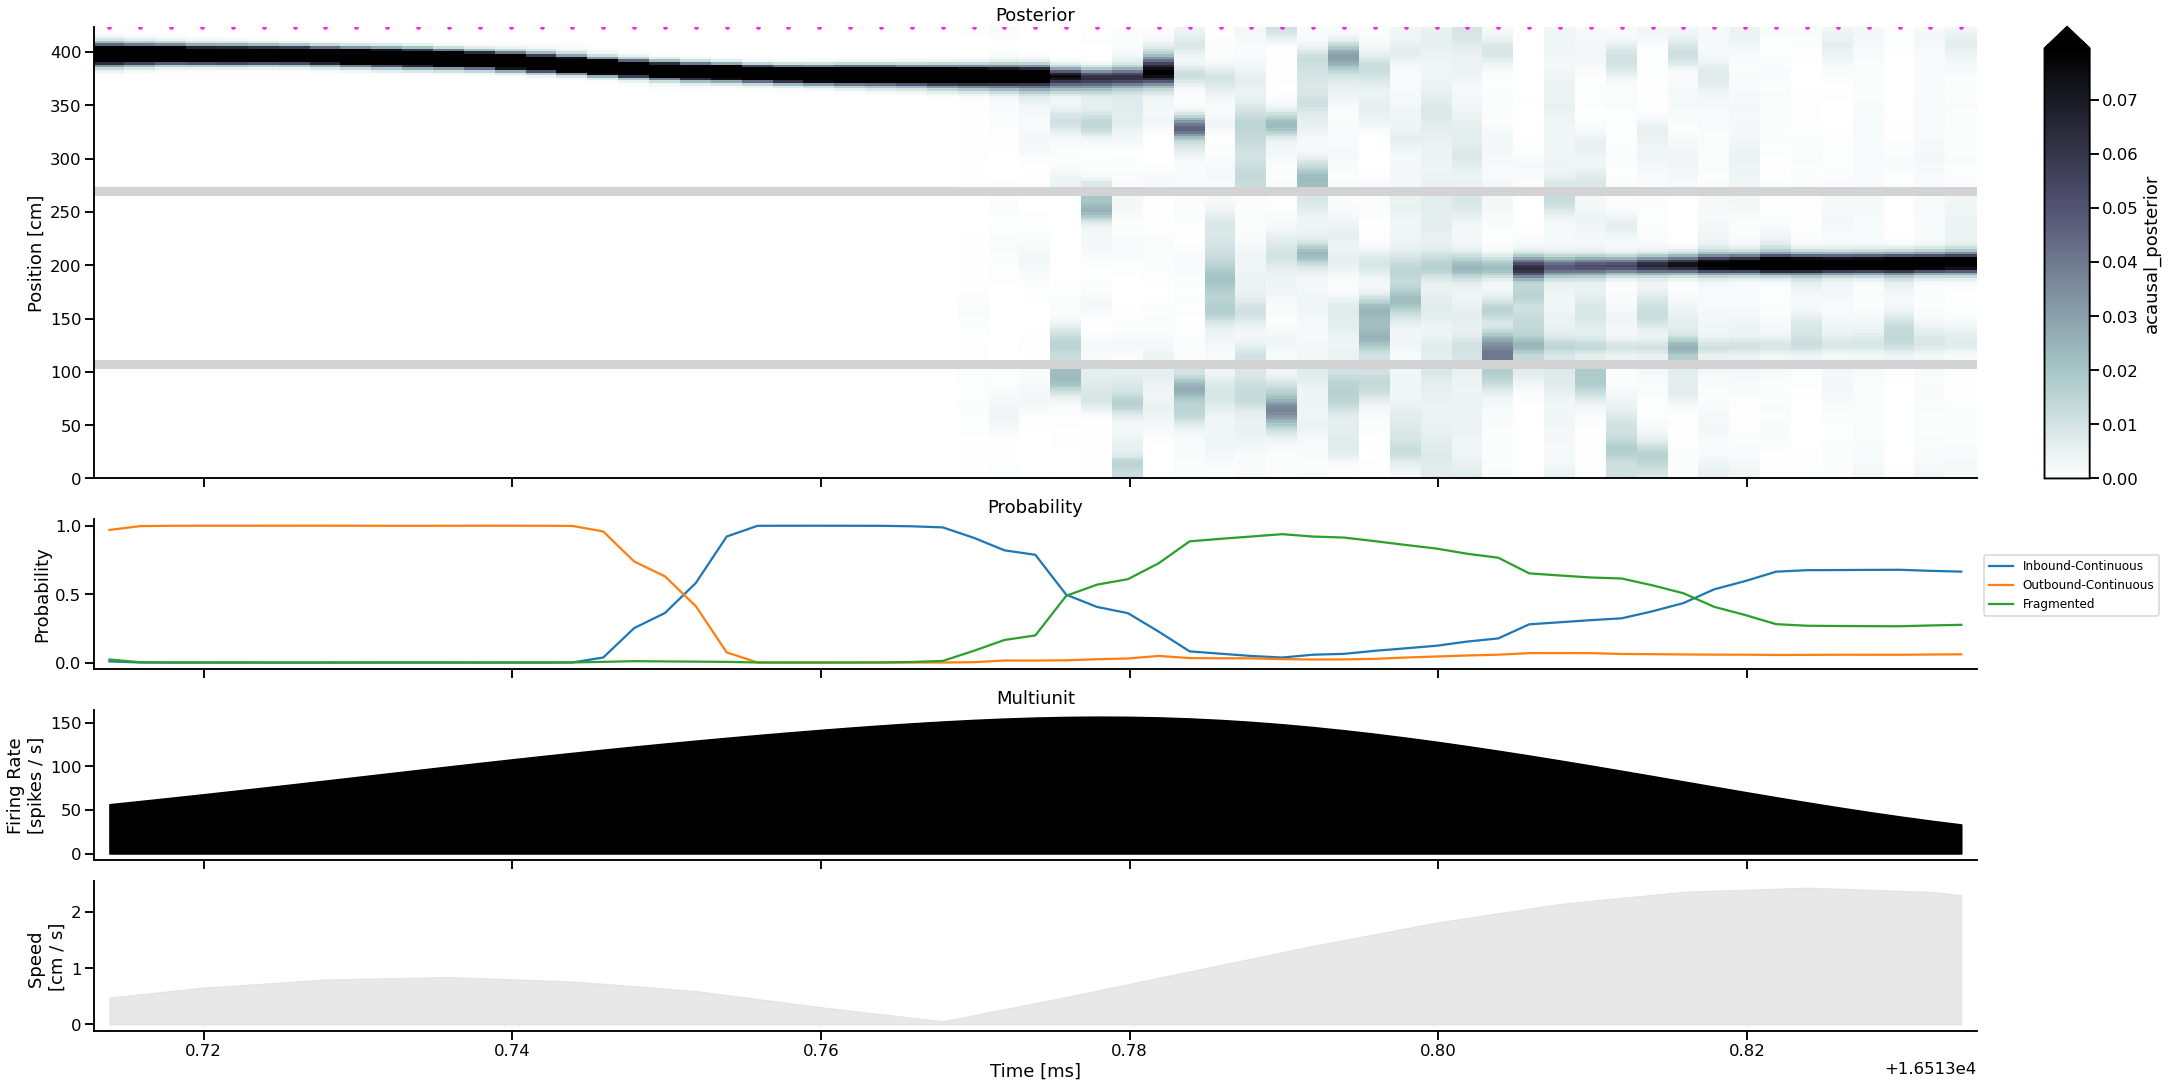

In [57]:
ripple_number = 30

plot_ripple_decode(data, classifier, ripple_number)

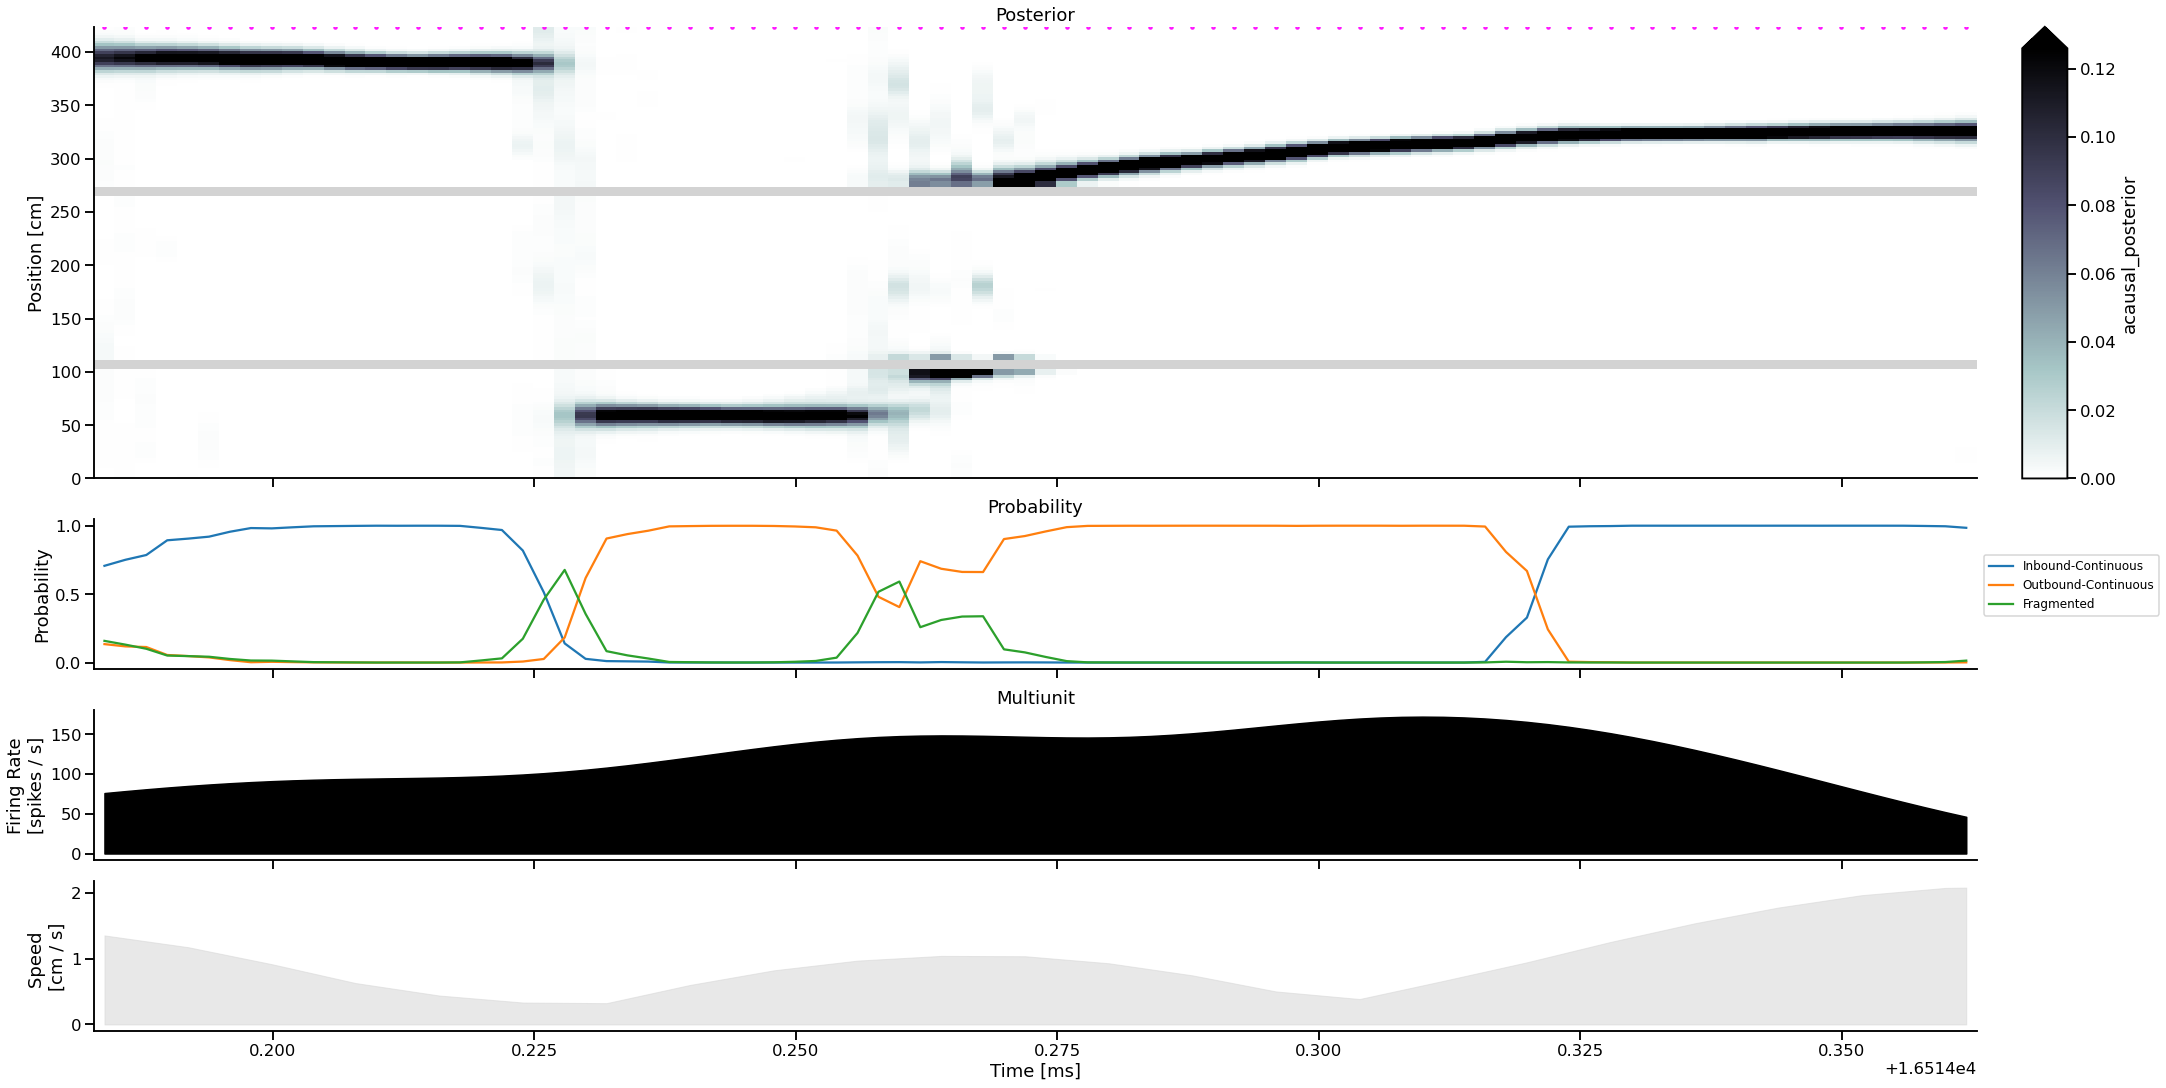

In [58]:
ripple_number = 31

plot_ripple_decode(data, classifier, ripple_number)

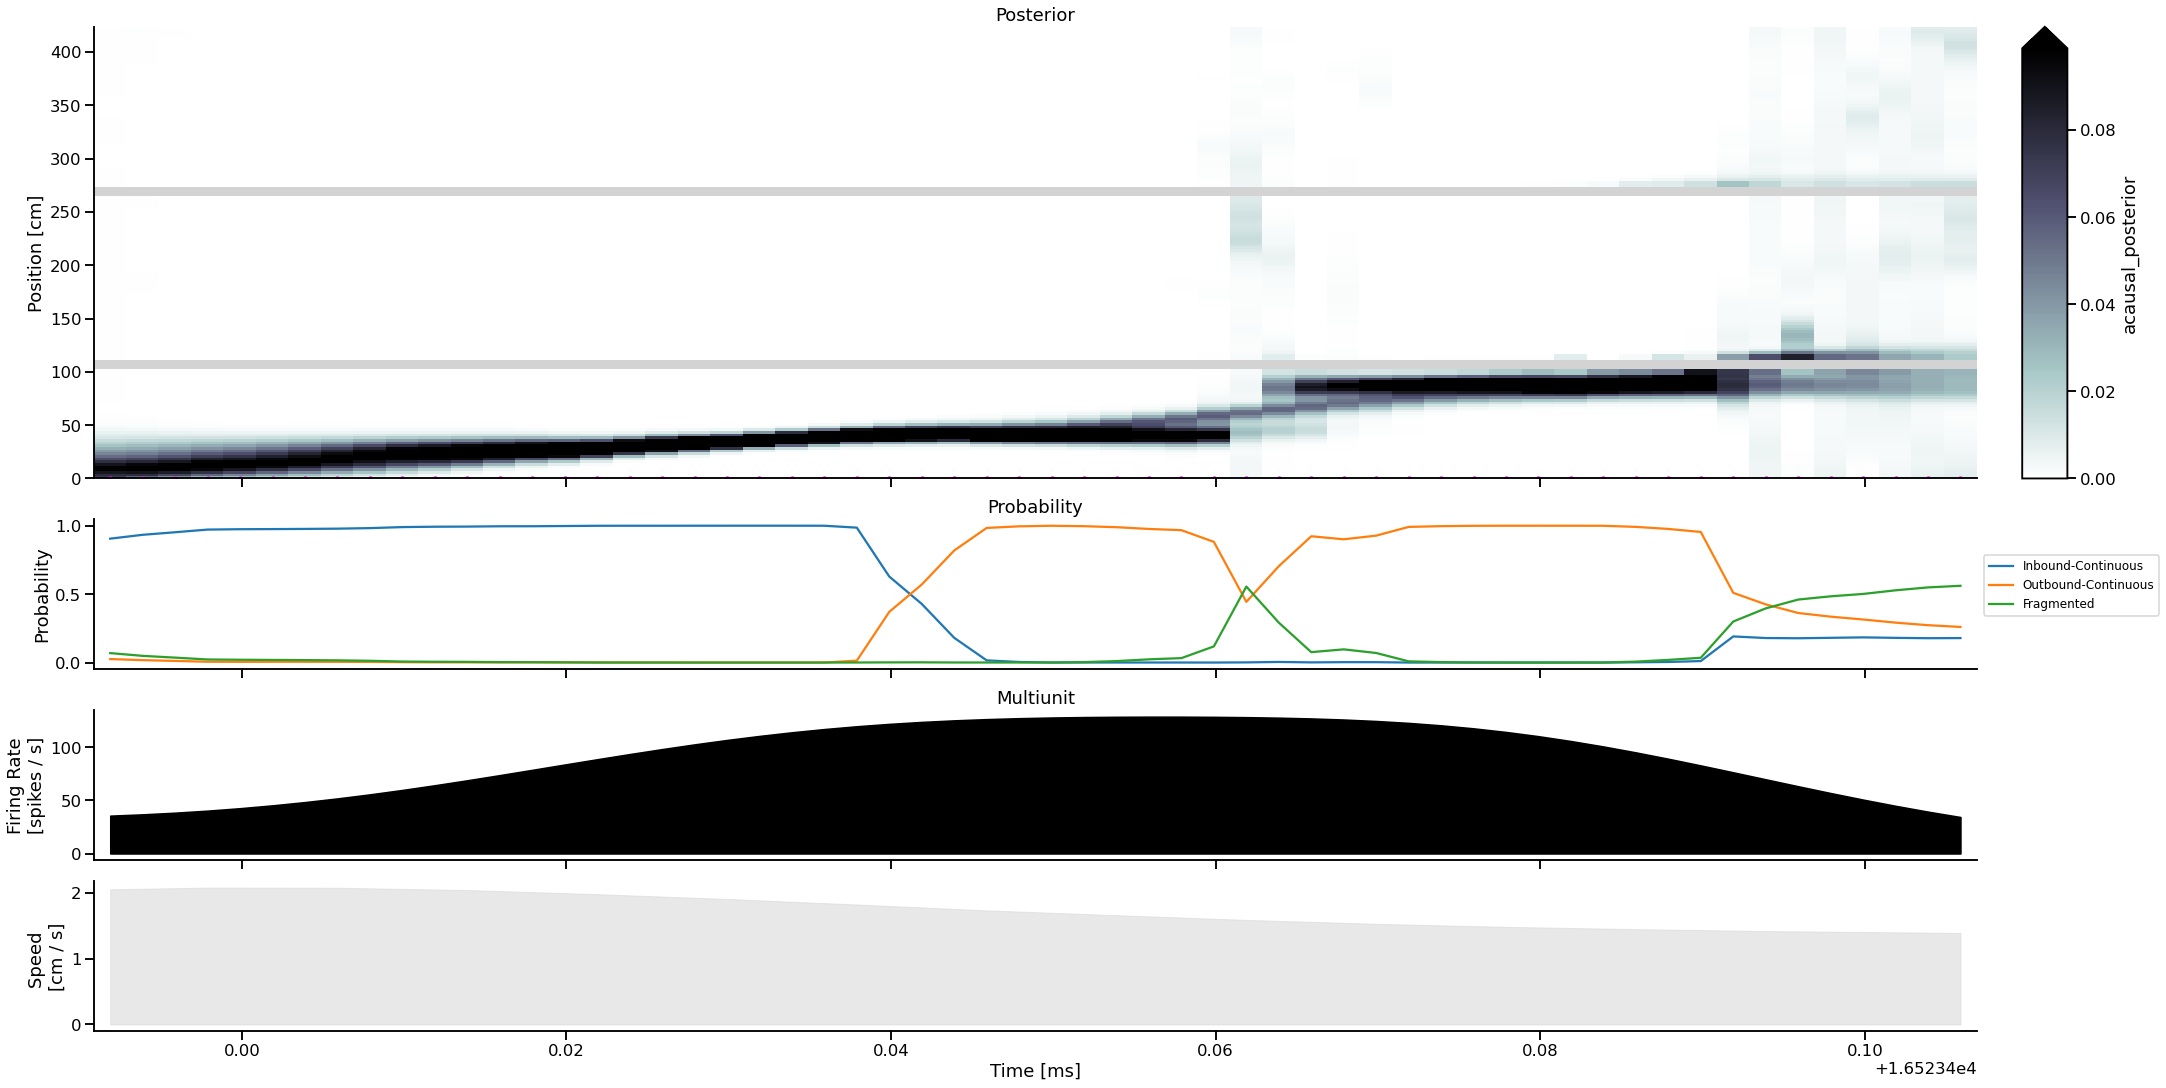

In [59]:
ripple_number = 32

plot_ripple_decode(data, classifier, ripple_number)